# 1 Introduction

In this notebook, I address the core business question:

**"Our revenue has been decreasing over the years. Will asking a loan solve the problem? Does this affects the business directly?"**

To explore this, I used structured data extracted from the company’s database. I accessed the data using SQL and converted the relevant tables to `.csv` format for batch analysis. The tables used include:

* **transactions** (fact table)
* **customers** (dimension table)
* **markets** (dimension table)
* **products** (dimension table)

## Profitability Challenges

The company is currently focused on entering new markets and retaining existing clients in the face of rising competition. As a result, we've been selling products at very low prices—sometimes even at a loss—to avoid losing market share. While this strategy helps maintain customer relationships, it’s affecting our bottom line. With decreasing revenue and thin or negative profit margins, we have less capital to reinvest in growth.

A key question emerged:
**If we take out a loan to boost revenue, will that actually lead to increased profit?**

Another contributing factor to our financial losses is strong competition from other providers. In response, we've had to adopt aggressive pricing strategies that undermine profitability.

## Summary of Findings

Increasing revenue does **not necessarily** lead to increased profit.
To continue tackling profitability losses, we can rely on the Profit per Unit Revenue (PUR) metric to identify transactions that offer better returns and reduce inefficient spending

To assess this, I implemented a **decision tree model** that predicts profitability. This model evaluates combinations of market, product, client, zone, quantity, and cost price to determine whether a transaction is likely to be profitable. It serves as a decision-support tool to help the business identify which opportunities are worth pursuing.

The analysis revealed that while a drop in revenue doesn't directly harm the business, a drop in **profit** does. Therefore, our focus should shift from increasing revenue to improving profitability.



## What you'll find in this notebook

# 2 Business Problem

In this section, I explore how profit and revenue have evolved over time to gain a clearer understanding of the business challenge.
To visualize these trends, I created a custom function that plots any selected metric across different years.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
save_dir = ""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [ ]:
#df is our fact table
df = pd.read_csv(save_dir+'checked_transactions.csv')
df.tail()

product_code market_code  order_date  sales_qty  sales_amount currency  \
154424      Prod280     Mark011  2020-01-09          1            28      INR   
154425      Prod281     Mark011  2020-01-09          1            28      INR   
154426      Prod280     Mark011  2020-02-08          1            28      INR   
154427      Prod281     Mark011  2020-03-08          1            28      INR   
154428      Prod300     Mark011  2020-03-08          1            42      INR   

        profit_margin_percentage  profit_margin  cost_price customer_code  \
154424                     -0.19          -5.32       33.32        Cus037   
154425                      0.19           5.32       22.68        Cus037   
154426                      0.07           1.96       26.04        Cus037   
154427                      0.14           3.92       24.08        Cus037   
154428                     -0.21          -8.82       50.82        Cus037   

        year  
154424  2019  
154425  2019  
154426  2019  
154427  2019  
154428  2019

In [ ]:
len(df)

154429

In [ ]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['year'] = df['order_date'].dt.year

In [ ]:
df.groupby('year')['customer_code'].nunique()

year
2017    10
2018    19
2019    33
2020    38
Name: customer_code, dtype: int64

In [ ]:
# Customers who were in 2017 but not in 2018
customers_2017 = set(df[df['year'] == 2017]['customer_code'])
customers_2018 = set(df[df['year'] == 2018]['customer_code'])
customers_only_2017 = customers_2017 - customers_2018
customers_only_2017 = list(customers_only_2017)
customers_only_2017

[]

In [ ]:
# Customers who were in 2018 but not in 2019
customers_2018 = set(df[df['year'] == 2018]['customer_code'])
customers_2019 = set(df[df['year'] == 2019]['customer_code'])
customers_only_2018 = customers_2018 - customers_2019
print(list(customers_only_2018))
df_only_2018 = df[(df['year'] == 2018) & (df['customer_code'].isin(customers_only_2018))]
df_only_2018

[]


Empty DataFrame
Columns: [product_code, market_code, order_date, sales_qty, sales_amount, currency, profit_margin_percentage, profit_margin, cost_price, customer_code, year]
Index: []

In [ ]:
customers_2019 = set(df[df['year'] == 2019]['customer_code'])
customers_2020 = set(df[df['year'] == 2020]['customer_code'])
customers_only_2019 = customers_2019 - customers_2020
print(customers_only_2019)
df_only_2019 = df[(df['year'] == 2019) & (df['customer_code'].isin(customers_only_2019))]
df_only_2019

set()


Empty DataFrame
Columns: [product_code, market_code, order_date, sales_qty, sales_amount, currency, profit_margin_percentage, profit_margin, cost_price, customer_code, year]
Index: []

In [ ]:
df['order_date'].max()

Timestamp('2020-12-31 00:00:00')

In [ ]:
df['order_date'] = pd.to_datetime(df['order_date'])
year_mean  = df.resample('Y', on='order_date')['sales_amount'].sum().reset_index()
year_mean

<ipython-input-20-85e24063a721>:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  year_mean  = df.resample('Y', on='order_date')['sales_amount'].sum().reset_index()


order_date  sales_amount
0 2017-12-31      92882653
1 2018-12-31     413687163
2 2019-12-31     336312079
3 2020-12-31     142303983

In [ ]:
df['order_date'] = pd.to_datetime(df['order_date'])
#DROP, wrong date
df = df[df['order_date'] < '2020-08-01']

<ipython-input-267-7a426a5f6453>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_date'] = pd.to_datetime(df['order_date'])


<ipython-input-268-513b38ad2746>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df.resample('M', on='order_date')['sales_amount'].sum().reset_index()


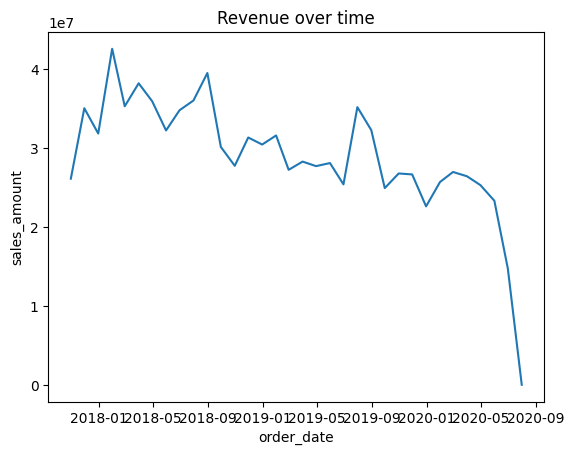

In [ ]:

# Resampling by month reduces the amount of noise
df_resampled = df.resample('M', on='order_date')['sales_amount'].sum().reset_index()

sns.lineplot(data=df_resampled, x='order_date', y='sales_amount')
plt.title('Revenue over time')
plt.show()

<ipython-input-22-513b38ad2746>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df.resample('M', on='order_date')['sales_amount'].sum().reset_index()


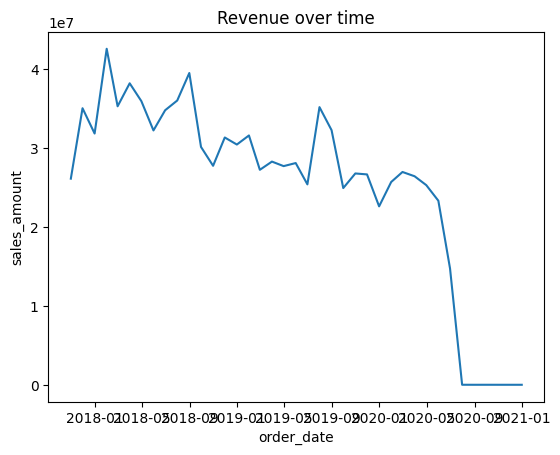

In [ ]:

# Resampling by month reduces the amount of noise
df_resampled = df.resample('M', on='order_date')['sales_amount'].sum().reset_index()

sns.lineplot(data=df_resampled, x='order_date', y='sales_amount')
plt.title('Revenue over time')
plt.show()

<ipython-input-23-502a85ce8853>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df.resample('M', on='order_date')['profit_margin'].sum().reset_index()


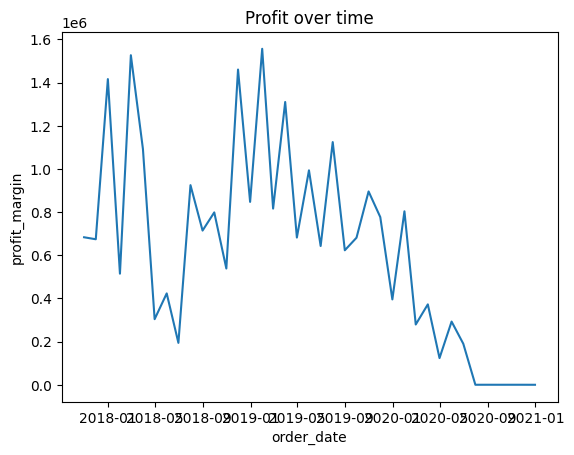

' Another problem statement '

In [ ]:
df_resampled = df.resample('M', on='order_date')['profit_margin'].sum().reset_index()

sns.lineplot(data=df_resampled, x='order_date', y='profit_margin')
plt.title('Profit over time')
plt.show()
''' Another problem statement '''

In [ ]:
def metric_last_years(df=None, metric_col='',date_col = '',agg_func=np.sum):
  """
    Plots a metric across the years 2017 to 2019 starting on October up to September

    Args:
        df (pd.DataFrame): Input DataFrame containing the data.
        metric_col (str): Name of the column containing the metric to be plotted.
        date_col (str): Name of the column containing the dates.
        agg_func (function, optional): Aggregation function to apply
            (e.g., np.sum, np.mean). Defaults to np.sum.

    Raises:
        ValueError: If required parameters are not provided.

    Returns:
        list of pd.DataFrame: Aggregated metric by month for three fiscal years.
  """

  if df is None or metric_col == '' or date_col == '':
    raise ValueError("You should give a data frame, a metric column name, and date column name")
  df = df.copy()

  df[date_col] = pd.to_datetime(df[date_col])


  df['order_month'] = df[date_col].dt.to_period('M')

  # Using SUM
  revenue_by_month = df.groupby('order_month')[metric_col].agg(agg_func)

  revenue_comparison = pd.DataFrame({
      metric_col: revenue_by_month,
  }).dropna().reset_index()

  revenue_comparison['order_month'] = revenue_comparison['order_month'].dt.to_timestamp()
  revenue_comparison.set_index('order_month',inplace=True)
  #Converted month to srt so when I graph it goes from Oct to Sept
  year_2017 = revenue_comparison['2017-10-01':'2018-9-30'].copy().reset_index()
  year_2017['month'] = year_2017['order_month'].dt.strftime('%b')
  year_2018 = revenue_comparison['2018-10-01':'2019-09-30'].copy().reset_index()
  year_2018['month'] = year_2018['order_month'].dt.strftime('%b')
  year_2019 = revenue_comparison['2019-10-01':'2020-09-30'].copy().reset_index()
  year_2019['month'] = year_2019['order_month'].dt.strftime('%b')

  sns.lineplot(data=year_2017, x='month', y=metric_col, label='OCT 2017- SEPT 2018')
  sns.lineplot(data=year_2018, x='month', y=metric_col, label='OCT 2018 - SEPT 2019')
  sns.lineplot(data=year_2019, x='month', y=metric_col, label='OCT 2019 - SEP 2020')
  plt.legend()
  plt.title(metric_col +' Oct-Sep')
  plt.xlabel('Month')
  plt.ylabel(metric_col)
  plt.show()
  return [year_2019,year_2018,year_2017]


<ipython-input-24-143fbbc8238e>:29: FutureWarning: The provided callable <function sum at 0x7a8ba0bece00> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  revenue_by_month = df.groupby('order_month')[metric_col].agg(agg_func)


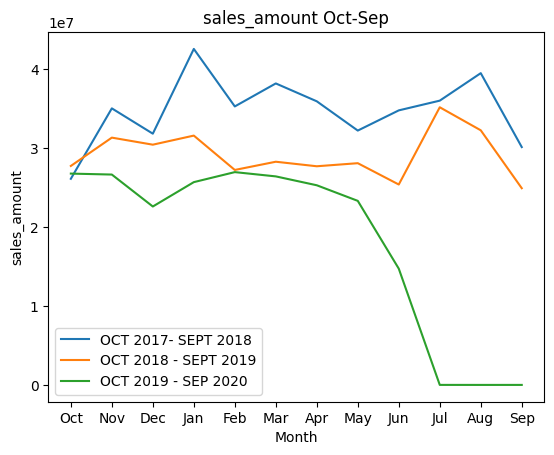

[   order_month  sales_amount month
 0   2019-10-01      26744955   Oct
 1   2019-11-01      26623725   Nov
 2   2019-12-01      22581846   Dec
 3   2020-01-01      25664596   Jan
 4   2020-02-01      26931944   Feb
 5   2020-03-01      26391041   Mar
 6   2020-04-01      25267920   Apr
 7   2020-05-01      23294778   May
 8   2020-06-01      14717345   Jun
 9   2020-07-01          8472   Jul
 10  2020-08-01          5375   Aug
 11  2020-09-01          6474   Sep,
    order_month  sales_amount month
 0   2018-10-01      27713450   Oct
 1   2018-11-01      31296202   Nov
 2   2018-12-01      30404126   Dec
 3   2019-01-01      31553402   Jan
 4   2019-02-01      27206009   Feb
 5   2019-03-01      28246165   Mar
 6   2019-04-01      27673431   Apr
 7   2019-05-01      28061536   May
 8   2019-06-01      25363748   Jun
 9   2019-07-01      35137734   Jul
 10  2019-08-01      32223583   Aug
 11  2019-09-01      24895945   Sep,
    order_month  sales_amount month
 0   2017-10-01      26087

In [ ]:
metric_last_years(df=df,metric_col='sales_amount',date_col='order_date')

<ipython-input-24-143fbbc8238e>:29: FutureWarning: The provided callable <function sum at 0x7a8ba0bece00> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  revenue_by_month = df.groupby('order_month')[metric_col].agg(agg_func)


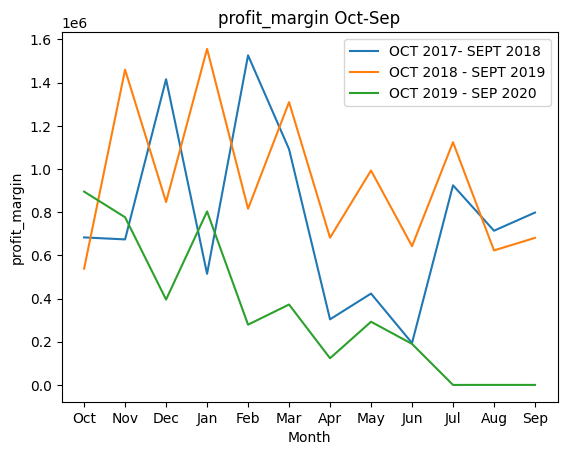

[   order_month  profit_margin month
 0   2019-10-01      895428.86   Oct
 1   2019-11-01      776682.33   Nov
 2   2019-12-01      395480.27   Dec
 3   2020-01-01      803466.83   Jan
 4   2020-02-01      279285.94   Feb
 5   2020-03-01      372486.36   Mar
 6   2020-04-01      123700.35   Apr
 7   2020-05-01      292809.47   May
 8   2020-06-01      190141.92   Jun
 9   2020-07-01         177.69   Jul
 10  2020-08-01         260.43   Aug
 11  2020-09-01         203.28   Sep,
    order_month  profit_margin month
 0   2018-10-01      538597.51   Oct
 1   2018-11-01     1460024.80   Nov
 2   2018-12-01      847106.13   Dec
 3   2019-01-01     1556159.58   Jan
 4   2019-02-01      816038.94   Feb
 5   2019-03-01     1309746.25   Mar
 6   2019-04-01      681946.82   Apr
 7   2019-05-01      993187.17   May
 8   2019-06-01      642823.98   Jun
 9   2019-07-01     1124052.31   Jul
 10  2019-08-01      622992.90   Aug
 11  2019-09-01      681182.44   Sep,
    order_month  profit_margin month

In [ ]:
metric_last_years(df=df,metric_col='profit_margin',date_col='order_date')

<ipython-input-24-143fbbc8238e>:29: FutureWarning: The provided callable <function sum at 0x7a8ba0bece00> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  revenue_by_month = df.groupby('order_month')[metric_col].agg(agg_func)


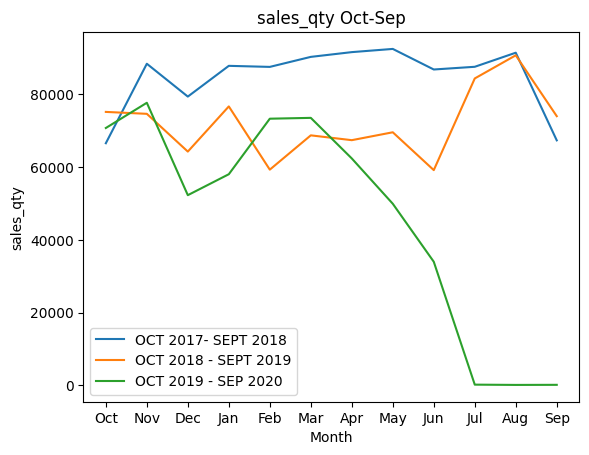

[   order_month  sales_qty month
 0   2019-10-01      70781   Oct
 1   2019-11-01      77718   Nov
 2   2019-12-01      52315   Dec
 3   2020-01-01      58073   Jan
 4   2020-02-01      73340   Feb
 5   2020-03-01      73569   Mar
 6   2020-04-01      62409   Apr
 7   2020-05-01      49954   May
 8   2020-06-01      34004   Jun
 9   2020-07-01        218   Jul
 10  2020-08-01        141   Aug
 11  2020-09-01        166   Sep,
    order_month  sales_qty month
 0   2018-10-01      75207   Oct
 1   2018-11-01      74680   Nov
 2   2018-12-01      64299   Dec
 3   2019-01-01      76718   Jan
 4   2019-02-01      59331   Feb
 5   2019-03-01      68762   Mar
 6   2019-04-01      67435   Apr
 7   2019-05-01      69605   May
 8   2019-06-01      59202   Jun
 9   2019-07-01      84406   Jul
 10  2019-08-01      90767   Aug
 11  2019-09-01      74036   Sep,
    order_month  sales_qty month
 0   2017-10-01      66595   Oct
 1   2017-11-01      88448   Nov
 2   2017-12-01      79419   Dec
 3   201

In [ ]:
metric_last_years(df=df,metric_col='sales_qty',date_col='order_date')


---

# 3 Data Understanding

In this section, I explore the data to understand its structure and quality. I merge the fact table with the dimension tables, clean and standardize column names, and check for missing values. Additionally, I create useful functions to extract insights and generate initial visualizations to better grasp the data patterns.

---


In [ ]:
df.shape

(154429, 11)

## All columns could be used for mergin (considering nan val)

In [ ]:
df.isna().sum()

product_code                0
market_code                 0
order_date                  0
sales_qty                   0
sales_amount                0
currency                    0
profit_margin_percentage    0
profit_margin               0
cost_price                  0
customer_code               0
year                        0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154429 entries, 0 to 154428
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   product_code              154429 non-null  object        
 1   market_code               154429 non-null  object        
 2   order_date                154429 non-null  datetime64[ns]
 3   sales_qty                 154429 non-null  int64         
 4   sales_amount              154429 non-null  int64         
 5   currency                  154429 non-null  object        
 6   profit_margin_percentage  154429 non-null  float64       
 7   profit_margin             154429 non-null  float64       
 8   cost_price                154429 non-null  float64       
 9   customer_code             154429 non-null  object        
 10  year                      154429 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(2), object(4)
m

In [ ]:
df.describe()

order_date      sales_qty  sales_amount  \
count                         154429  154429.000000  1.544290e+05   
mean   2019-01-21 01:19:47.473855488      15.769810  6.379539e+03   
min              2017-10-04 00:00:00       1.000000  5.000000e+00   
25%              2018-05-23 00:00:00       1.000000  1.570000e+02   
50%              2019-01-14 00:00:00       1.000000  4.680000e+02   
75%              2019-09-12 00:00:00       7.000000  2.806000e+03   
max              2020-12-31 00:00:00   14049.000000  1.510944e+06   
std                              NaN     113.156595  2.952035e+04   

       profit_margin_percentage  profit_margin    cost_price           year  
count             154429.000000  154429.000000  1.544290e+05  154429.000000  
mean                   0.024817     159.744604  6.220154e+03    2018.569660  
min                   -0.350000 -369348.500000  3.050000e+00    2017.000000  
25%                   -0.160000     -60.200000  1.460100e+02    2018.000000  
50%                    0.020000       4.980000  4.587000e+02    2019.000000  
75%                    0.210000      95.260000  2.681280e+03    2019.000000  
max                    0.400000  481775.040000  1.846742e+06    2020.000000  
std                    0.219039    6715.282523  2.921874e+04       0.858421

In [ ]:
df.tail()

product_code market_code order_date  sales_qty  sales_amount currency  \
154424      Prod280     Mark011 2020-01-09          1            28      INR   
154425      Prod281     Mark011 2020-01-09          1            28      INR   
154426      Prod280     Mark011 2020-02-08          1            28      INR   
154427      Prod281     Mark011 2020-03-08          1            28      INR   
154428      Prod300     Mark011 2020-03-08          1            42      INR   

        profit_margin_percentage  profit_margin  cost_price customer_code  \
154424                     -0.19          -5.32       33.32        Cus037   
154425                      0.19           5.32       22.68        Cus037   
154426                      0.07           1.96       26.04        Cus037   
154427                      0.14           3.92       24.08        Cus037   
154428                     -0.21          -8.82       50.82        Cus037   

        year  
154424  2020  
154425  2020  
154426  2020  
154427  2020  
154428  2020

In [ ]:
df.describe(include='object')

product_code market_code currency customer_code
count        154429      154429   154429        154429
unique          338          15        2            38
top         Prod065     Mark011      INR        Cus005
freq           3952       53153   154427         19250

## Date and time columns

### order_date column

In [ ]:
df['order_date'][df['order_date'].duplicated()].value_counts()

order_date
2018-06-22    374
2018-07-20    342
2018-12-21    341
2019-03-29    331
2018-06-11    328
             ... 
2020-08-24      1
2020-10-26      1
2020-12-07      1
2020-02-09      1
2020-12-21      1
Name: count, Length: 989, dtype: int64

In [ ]:
#Median of transactions per day
df['order_date'].value_counts().median()

190.0

<ipython-input-36-e6f87fafe9af>:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df.set_index('order_date').resample('Y').size().plot(kind='bar')


<Axes: xlabel='order_date'>

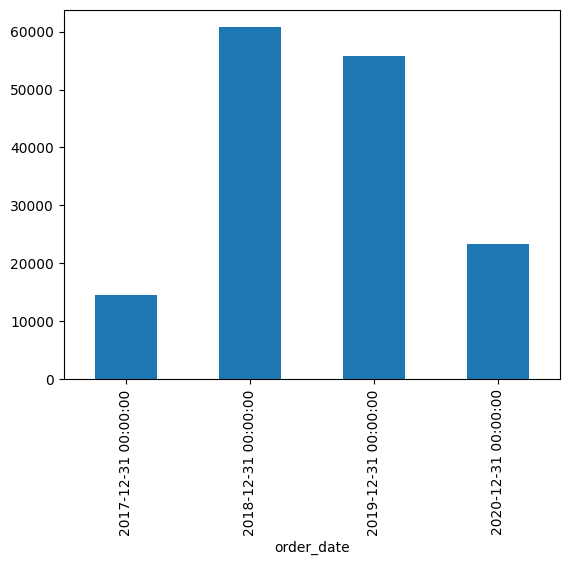

In [ ]:

df.set_index('order_date').resample('Y').size().plot(kind='bar')

In [ ]:

df.set_index('order_date').resample('Y').size()

<ipython-input-37-747c5f483095>:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df.set_index('order_date').resample('Y').size()


order_date
2017-12-31    14557
2018-12-31    60755
2019-12-31    55705
2020-12-31    23412
Freq: YE-DEC, dtype: int64

<ipython-input-38-5e9bb96a86b2>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('order_date').resample('M').size().plot(kind='bar')


<Axes: xlabel='order_date'>

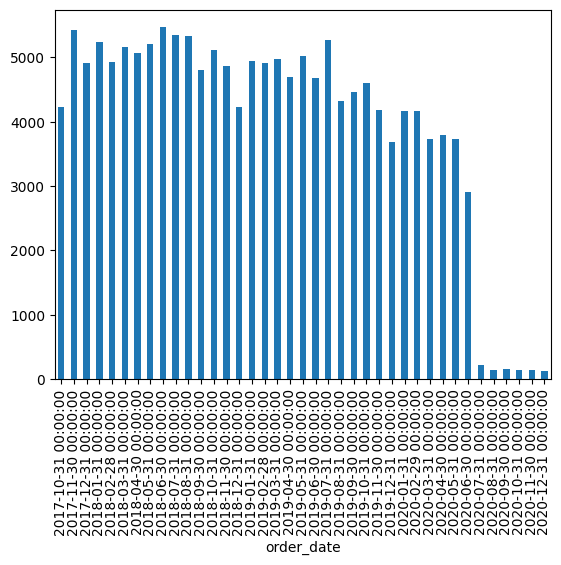

In [ ]:
df.set_index('order_date').resample('M').size().plot(kind='bar')

#### There is not seasonality using number of transactions per month

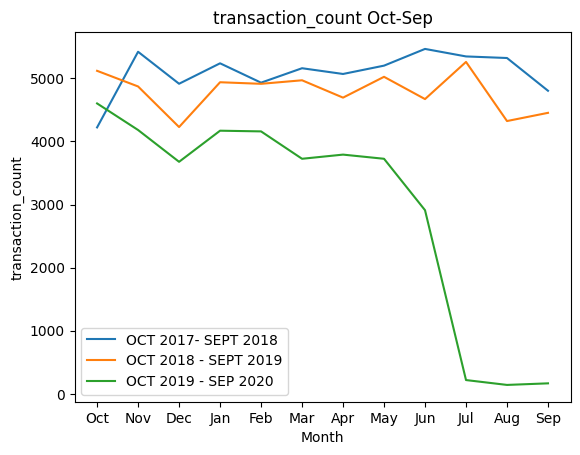

[   order_month  transaction_count month
 0   2019-10-01               4602   Oct
 1   2019-11-01               4181   Nov
 2   2019-12-01               3677   Dec
 3   2020-01-01               4170   Jan
 4   2020-02-01               4159   Feb
 5   2020-03-01               3725   Mar
 6   2020-04-01               3791   Apr
 7   2020-05-01               3725   May
 8   2020-06-01               2910   Jun
 9   2020-07-01                218   Jul
 10  2020-08-01                141   Aug
 11  2020-09-01                166   Sep,
    order_month  transaction_count month
 0   2018-10-01               5119   Oct
 1   2018-11-01               4871   Nov
 2   2018-12-01               4228   Dec
 3   2019-01-01               4938   Jan
 4   2019-02-01               4913   Feb
 5   2019-03-01               4969   Mar
 6   2019-04-01               4694   Apr
 7   2019-05-01               5024   May
 8   2019-06-01               4671   Jun
 9   2019-07-01               5260   Jul
 10  2019-08-01

In [ ]:
df['transaction_count'] = 1  # Each row represents a transaction
metric_last_years(df=df,metric_col='transaction_count',date_col='order_date',agg_func='count')


In [ ]:
#Checking for outliers
monthly = df.resample('m', on='order_date').size()
monthly[monthly > monthly.mean() + 2*monthly.std()]


<ipython-input-40-4cb6288a604d>:2: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('m', on='order_date').size()


Series([], Freq: ME, dtype: int64)

### Do we really work on weekend or we have 525 rows with wrong date?

In [ ]:
df['is_weekend'] = df['order_date'].dt.day_of_week >= 5

In [ ]:
(df['is_weekend'].sum() / len(df)) * 100

np.float64(1.3553153876538733)

In [ ]:
df['is_weekend'].sum()

np.int64(2093)

In [ ]:
'''Other days we've done around 20% of sales,
 sat + sun we have less than 1% '''

"Other days we've done around 20% of sales,\n sat + sun we have less than 1% "

In [ ]:
import calendar
for i in range(7):
  mask = df['order_date'].dt.dayofweek == i
  pctg = (mask.sum() / len(df)) * 100
  day_name = calendar.day_name[i]
  print(day_name,round(pctg,2))


Monday 16.91
Tuesday 19.4
Wednesday 19.31
Thursday 19.67
Friday 23.36
Saturday 1.05
Sunday 0.31


## Categorical columns

## Helpfull functions for cat columns

In [ ]:
def group_categories(df, cat_columns, top_n=5, other_label='Other'):
    """
    Create new columns with '_top' suffix where rare categories are grouped as 'Other'.
    Keeps only the top_n most frequent categories in each specified column.

    Parameters:
    - df: pandas DataFrame
    - cat_columns: list of column names (categorical) to process
    - top_n: number of most frequent categories to keep
    - other_label: label used for rare categories

    Returns:
    - df_copy: a copy of the original DataFrame with new '_top' columns added
    """
    df_copy = df.copy()

    for col in cat_columns:
        new_col = f"{col}_top"
        if df_copy[col].nunique() <= top_n:
            df_copy[new_col] = df_copy[col]
        else:
            top_categories = df_copy[col].value_counts().nlargest(top_n).index
            df_copy[new_col] = df_copy[col].apply(lambda x: x if x in top_categories else other_label)

    return df_copy


In [ ]:
def plot_weekly_distribution_by_category(df=None, cat_col='', date_col='order_date', top_n=10):
    """
    Plots a heatmap showing the distribution of orders by day of the week for the top N most frequent categories.
    Less frequent categories are grouped into 'Other'.

    Parameters:
    -----------
    df : pd.DataFrame
        The input dataframe containing a categorical column and a datetime column.
    cat_col : str
        Name of the categorical column to analyze (e.g. product_code, region, user_id).
    date_col : str
        Name of the column containing datetime data (default is 'order_date').
    top_n : int
        Number of top categories to show; others are grouped into 'Other'.

    Returns:
    --------
    None
        Displays a heatmap.
    """

    # Ensure date column is in datetime format
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col])

    # Extract day of week as name
    df['day_of_week'] = df[date_col].dt.day_name()

    # Group less frequent categories as "Other"
    top_categories = df[cat_col].value_counts().head(top_n).index
    df['category_grouped'] = df[cat_col].where(df[cat_col].isin(top_categories), 'Other')

    # Create normalized crosstab
    summary = pd.crosstab(df['category_grouped'], df['day_of_week'], normalize='index') * 100

    # Optional: order days correctly
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    summary = summary[day_order]  # reorders columns if all days are present

    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(summary, annot=True, fmt=".1f", cmap="YlGnBu")
    plt.xlabel("Day of Week")
    plt.ylabel(cat_col)
    plt.title(f"Weekly Distribution by {cat_col} (Top {top_n} + 'Other')")
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_distribution_heatmap(df,
                               row_col,
                               col_col,
                               top_n=10,
                               normalize='index',
                               show_percent=True,
                               title=None):
    """
    Plots a heatmap showing the distribution of one categorical variable (`col_col`)
    across the most frequent values of another (`row_col`). Less frequent categories
    in both dimensions are grouped into 'Other'.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame.
    row_col : str
        Column name to group rows by (e.g., product code).
    col_col : str
        Column name to group columns by (e.g., day of week, region).
    top_n : int
        Number of top categories in both `row_col` and `col_col` to show; others grouped as 'Other'.
    normalize : {'index', 'columns', None}
        Normalization for the crosstab.
    show_percent : bool
        Whether to multiply values by 100 and show as percentages.
    title : str or None
        Optional custom title for the plot.

    Returns:
    --------
    None
        Displays a heatmap.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    df = df.copy()

    # Keep top N categories for rows and columns
    top_rows = df[row_col].value_counts(ascending=False).nlargest(top_n).index
    top_cols = df[col_col].value_counts(ascending=False).nlargest(top_n).index

    # Replace less frequent categories with 'Other'
    df['__row__'] = df[row_col].where(df[row_col].isin(top_rows), 'Other')
    df['__col__'] = df[col_col].where(df[col_col].isin(top_cols), 'Other')

    # Convert to string to avoid type comparison errors during sorting
    df['__row__'] = df['__row__'].astype(str)
    df['__col__'] = df['__col__'].astype(str)

    # Crosstab
    summary = pd.crosstab(df['__row__'], df['__col__'], normalize=normalize)

    # Convert to percentage if requested
    if show_percent:
        summary *= 100
        fmt = ".1f"
    else:
        fmt = "d"

    # Sort rows and columns safely
    summary = summary.loc[sorted(summary.index, key=str)]
    summary = summary[sorted(summary.columns, key=str)]

    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(summary, annot=True, fmt=fmt, cmap="YlGnBu")
    plt.xlabel(col_col)
    plt.ylabel(row_col)
    plot_title = title or f"Distribution of {row_col} by {col_col} (Top {top_n} + 'Other')"
    plt.title(plot_title)
    plt.tight_layout()
    plt.show()


In [ ]:
from itertools import combinations

def column_pairs(cat_columns = []):
  pairs = list(combinations(cat_cols, 2))
  return pairs


### customer_code column

#### We have 38 customers

In [ ]:
print(len(df['customer_code'].unique()))
df['customer_code'].value_counts(ascending=False, normalize=True)*100

38


customer_code
Cus005    12.465275
Cus006    10.329666
Cus003     7.040776
Cus020     6.906734
Cus001     5.501557
Cus007     5.425147
Cus019     5.045037
Cus017     4.460950
Cus022     4.055585
Cus037     3.752534
Cus024     3.553737
Cus002     3.021453
Cus010     2.978715
Cus035     2.514424
Cus021     2.439956
Cus018     2.009985
Cus016     1.955591
Cus027     1.504899
Cus023     1.477054
Cus033     1.317758
Cus008     1.308044
Cus012     1.272429
Cus011     1.185658
Cus004     1.103420
Cus014     1.043845
Cus029     0.927287
Cus036     0.911098
Cus026     0.834688
Cus013     0.796483
Cus031     0.560776
Cus032     0.539406
Cus025     0.530988
Cus030     0.327011
Cus009     0.264847
Cus034     0.248658
Cus038     0.141813
Cus028     0.134690
Cus015     0.112026
Name: proportion, dtype: float64

### Customer table

In [ ]:
customer = pd.read_csv(save_dir+'customers.csv')
customer.head()


customer_code    custmer_name   customer_type
0        Cus001    Surge Stores  Brick & Mortar
1        Cus002    Nomad Stores  Brick & Mortar
2        Cus003    Excel Stores  Brick & Mortar
3        Cus004  Surface Stores  Brick & Mortar
4        Cus005  Premium Stores  Brick & Mortar

#### Customer_name not sepelled correctly, we've got custmer_nma

In [ ]:
customer.columns = ['customer_code', 'customer_name', 'customer_type']
customer.head(1)

customer_code customer_name   customer_type
0        Cus001  Surge Stores  Brick & Mortar

In [ ]:
#Checking for duplicates
(customer['customer_name'].value_counts() > 1).any()

np.False_

In [ ]:
customer['customer_code'].duplicated().sum()

np.int64(0)

#### Half of our clients are type E-Commerce, the other half if Brick&Mortar

In [ ]:
customer['customer_type'].value_counts()

customer_type
Brick & Mortar    19
E-Commerce        19
Name: count, dtype: int64

### Merge customer table with transactions table

In [ ]:
df = pd.merge(left=df, right=customer,how='left', on='customer_code').copy()
df.shape

(154429, 15)

In [ ]:
df['customer_name'].value_counts().head(10)

customer_name
Premium Stores              19250
Electricalsara Stores       15952
Excel Stores                10873
Nixon                       10666
Surge Stores                 8496
Info Stores                  8378
Electricalsopedia Stores     7791
Epic Stores                  6889
Electricalslytical           6263
Propel                       5795
Name: count, dtype: int64

### Product code column

#### Each of our top 5 products accounts for 2% of total sales. We currently offer 338 products in total

In [ ]:
print(len(df['product_code'].unique()))
freq_prod = df['product_code'].value_counts(ascending=False, normalize=True) * 100
freq_prod

338


product_code
Prod065    2.559105
Prod334    2.518957
Prod053    2.467801
Prod295    2.351890
Prod294    2.206192
             ...   
Prod173    0.000648
Prod200    0.000648
Prod028    0.000648
Prod144    0.000648
Prod073    0.000648
Name: proportion, Length: 338, dtype: float64

#### We could use a mean average since we don't have days or products with something 'very' far away from the mean

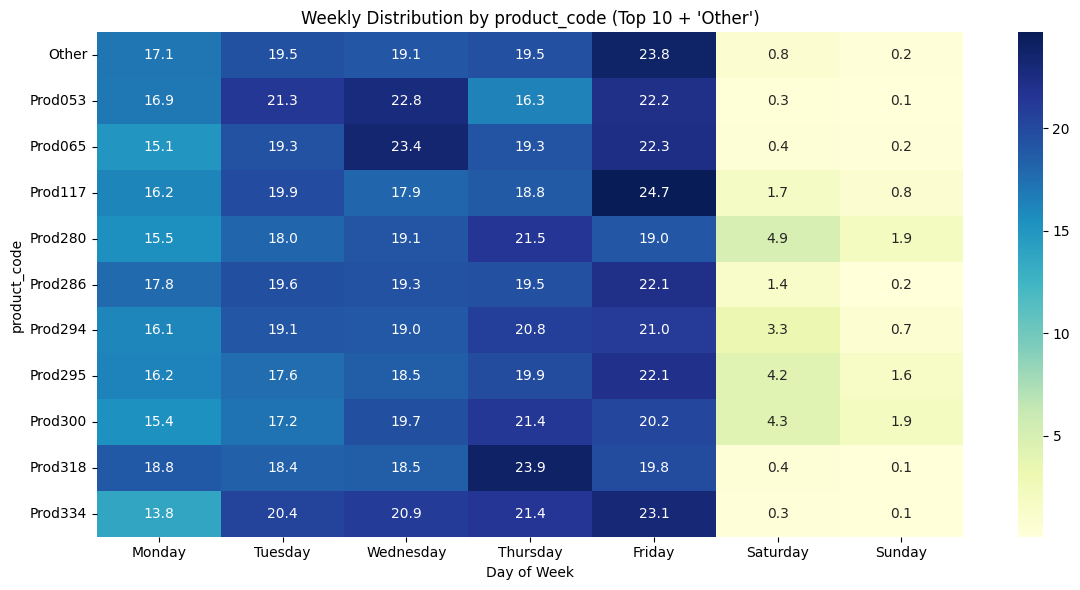

In [ ]:
plot_weekly_distribution_by_category(df=df, cat_col='product_code', date_col='order_date', top_n=10)


#### MOST orders go to customers outside the top 5 (`Other` column). This means it's mostly bought by smaller or less frequent customers.

Long tail: the large percentages under `'Other'` columns/rows indicate many low-volume products or customers—an opportunity to simplify inventory or find cross-sell patterns.

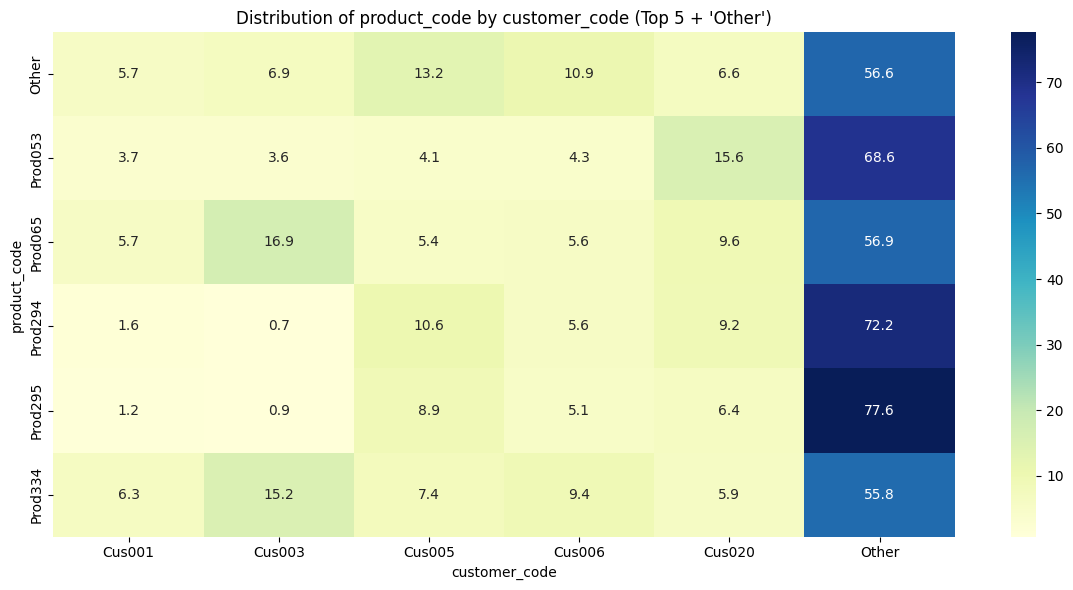

In [ ]:
plot_distribution_heatmap(df=df,
                               row_col='product_code',
                               col_col='customer_code',
                               top_n=5)

<Axes: xlabel='product_code'>

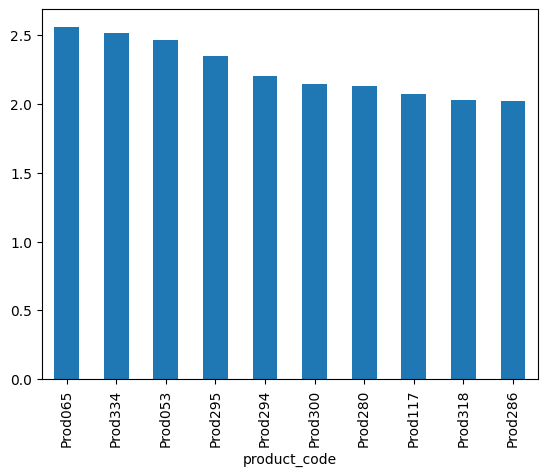

In [ ]:
freq_prod.head(10).plot(kind='bar')


### Merge products table with transactions table

#### Why we don't have product name col?

In [ ]:
products = pd.read_csv(save_dir+'products.csv')
products.tail()

product_code    product_type
274      Prod275     Own Brand\r
275      Prod276     Own Brand\r
276      Prod277     Own Brand\r
277      Prod278  Distribution\r
278      Prod279  Distribution\r

In [ ]:
#Checking if products table is clean
products['product_type'] = products['product_type'].str.strip()
products['product_type'].value_counts()

product_type
Own Brand       191
Distribution     88
Name: count, dtype: int64

In [ ]:
(products['product_code'].value_counts() > 1).any()

np.False_

In [ ]:
df = pd.merge(left=df, right=products, how='left', on='product_code').copy()
df.shape

(154429, 16)

### Merge markets table with transactions table

In [ ]:
market = pd.read_csv(save_dir+'markets.csv')
market.tail()

markets_code  markets_name     zone
12      Mark013        Bhopal  Central
13      Mark014     Hyderabad    South
14      Mark015  Bhubaneshwar    South
15      Mark097      New York      NaN
16      Mark999         Paris      NaN

In [ ]:
#Checking if market df is clean
(market['markets_code'].value_counts() > 1).any()

np.False_

In [ ]:
market['zone'].unique()

array(['South', 'Central', 'North', nan], dtype=object)

In [ ]:
df = pd.merge(left=df,right=market,how='left',left_on='market_code',right_on='markets_code').copy()
print(df.shape)
df.head()

(154429, 19)


product_code market_code order_date  sales_qty  sales_amount currency  \
0      Prod279     Mark011 2017-10-11          1           102      INR   
1      Prod279     Mark011 2017-10-18          1           102      INR   
2      Prod279     Mark011 2017-10-19          1           102      INR   
3      Prod279     Mark011 2017-11-08          1           102      INR   
4      Prod279     Mark011 2018-03-09          1           102      INR   

   profit_margin_percentage  profit_margin  cost_price customer_code  year  \
0                      0.39          39.78       62.22        Cus020  2017   
1                     -0.12         -12.24      114.24        Cus020  2017   
2                      0.29          29.58       72.42        Cus020  2017   
3                      0.36          36.72       65.28        Cus020  2017   
4                     -0.35         -35.70      137.70        Cus033  2018   

   transaction_count  is_weekend customer_name customer_type  product_type  \
0                  1       False         Nixon    E-Commerce  Distribution   
1                  1       False         Nixon    E-Commerce  Distribution   
2                  1       False         Nixon    E-Commerce  Distribution   
3                  1       False         Nixon    E-Commerce  Distribution   
4                  1       False       All-Out    E-Commerce  Distribution   

  markets_code markets_name     zone  
0      Mark011       Nagpur  Central  
1      Mark011       Nagpur  Central  
2      Mark011       Nagpur  Central  
3      Mark011       Nagpur  Central  
4      Mark011       Nagpur  Central

### Markets name column

In [ ]:
df['markets_name'].value_counts(ascending=False, normalize=True) *100

markets_name
Nagpur          34.419053
Delhi NCR       28.971890
Ahmedabad       12.979427
Bhopal           8.629208
Mumbai           7.336057
Kochi            3.191110
Kanpur           1.820254
Hyderabad        1.317110
Chennai          0.665678
Surat            0.260961
Patna            0.260314
Bhubaneshwar     0.072525
Lucknow          0.067345
Bengaluru        0.009066
Name: proportion, dtype: float64

In [ ]:
#Checking if data only contains records from India as I was told
df[df['markets_name'].isin(['New York', 'Paris'])]


Empty DataFrame
Columns: [product_code, market_code, order_date, sales_qty, sales_amount, currency, profit_margin_percentage, profit_margin, cost_price, customer_code, year, transaction_count, is_weekend, customer_name, customer_type, product_type, markets_code, markets_name, zone]
Index: []

### Currency column

In [ ]:
df['currency'].value_counts()

currency
INR    154427
USD         2
Name: count, dtype: int64

In [ ]:
# Droping USD rows as I was told
df = df[df['currency'] != 'USD'].copy()

### Checking for all cat

In [ ]:
cat_cols = ['product_code','sales_qty',
            'customer_name','customer_type',
            'markets_name','zone','customer_type']

#### * How much profit I have from selling just one product (segmentation) Specially for 053,117 065,334. ALsot this products but other sales qty
* How much profit represent 'Other' customers
* Ho much negative profit I have on Eccomerce compared to brick and mortar
*Come back to product code by market for segmentation
*also customer name by markets name, customer name by prodct and link that info to markets name
* Nagpur is ecommerce, that's the market with most profit?

product_code sales_qty


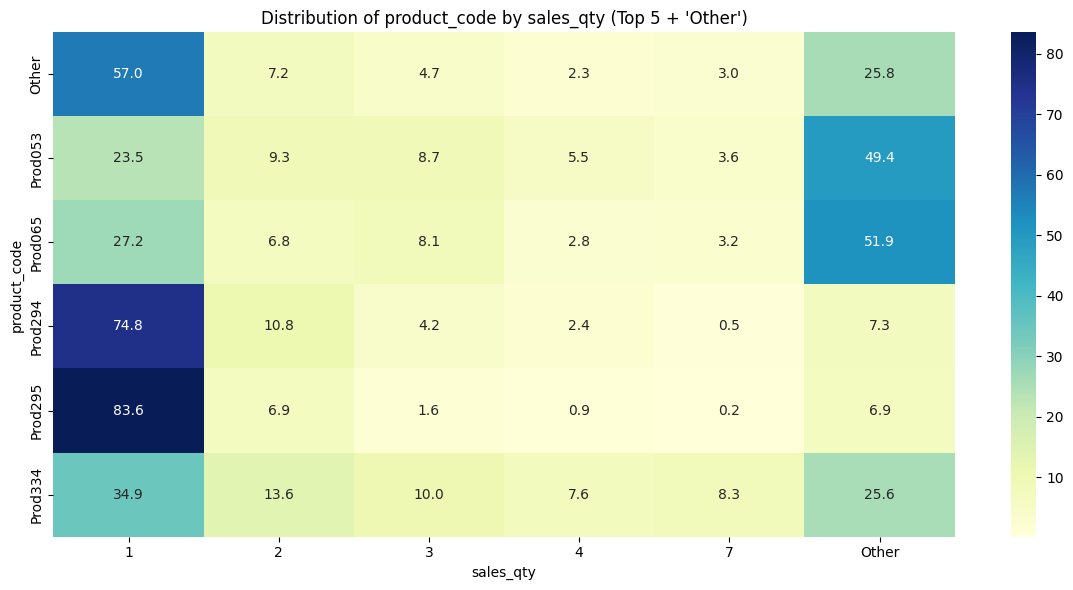

product_code customer_name


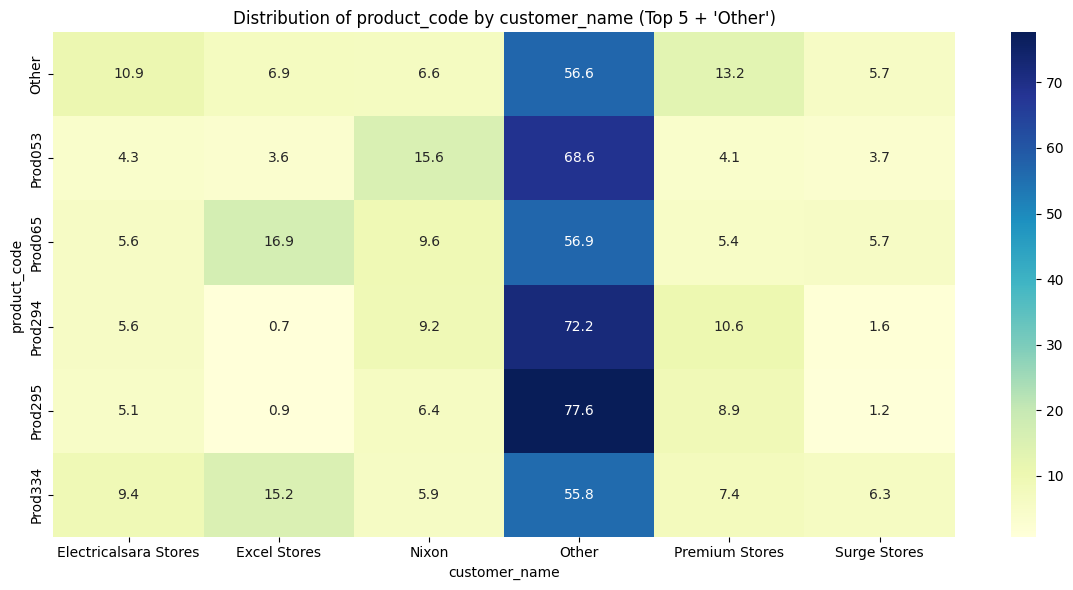

product_code customer_type


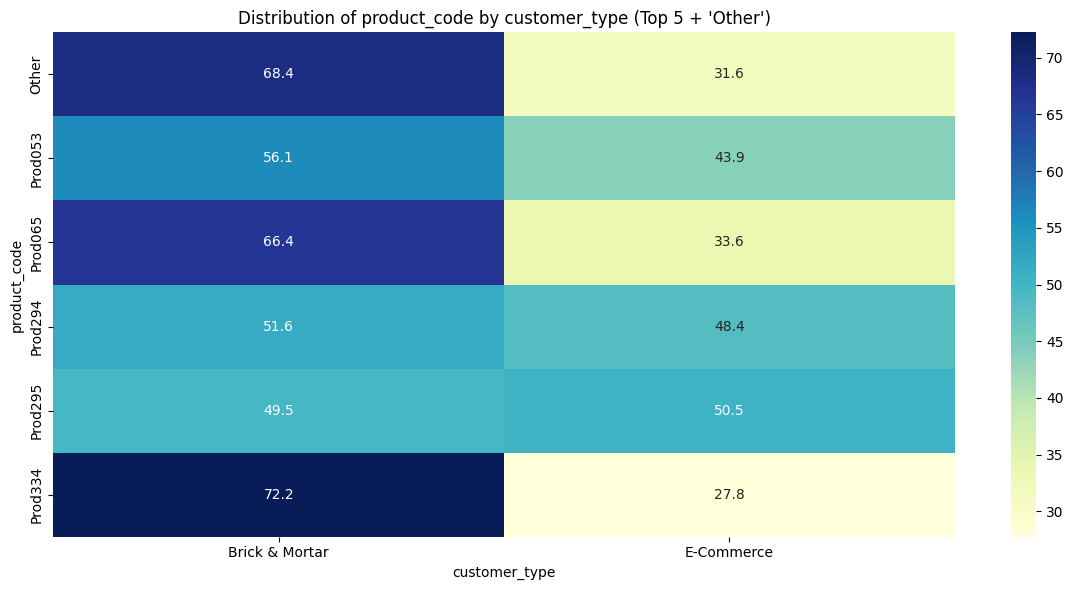

product_code markets_name


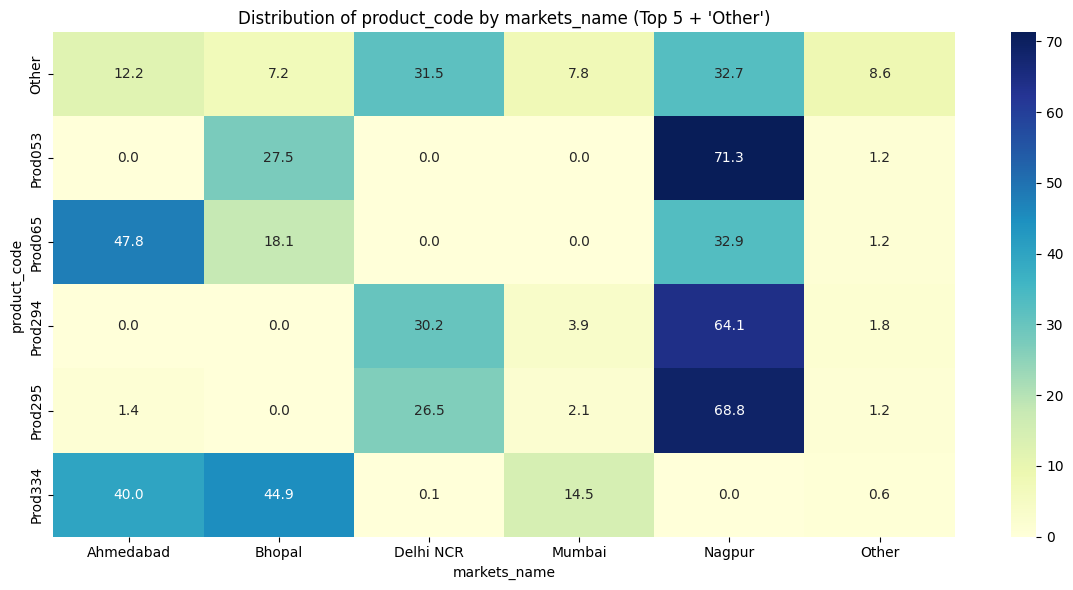

product_code zone


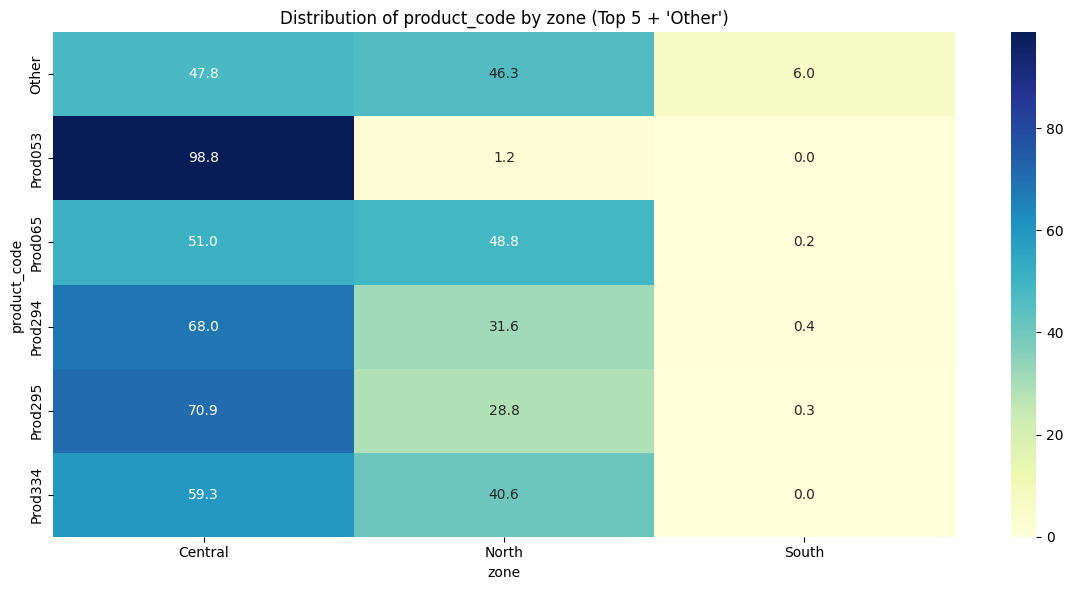

product_code customer_type


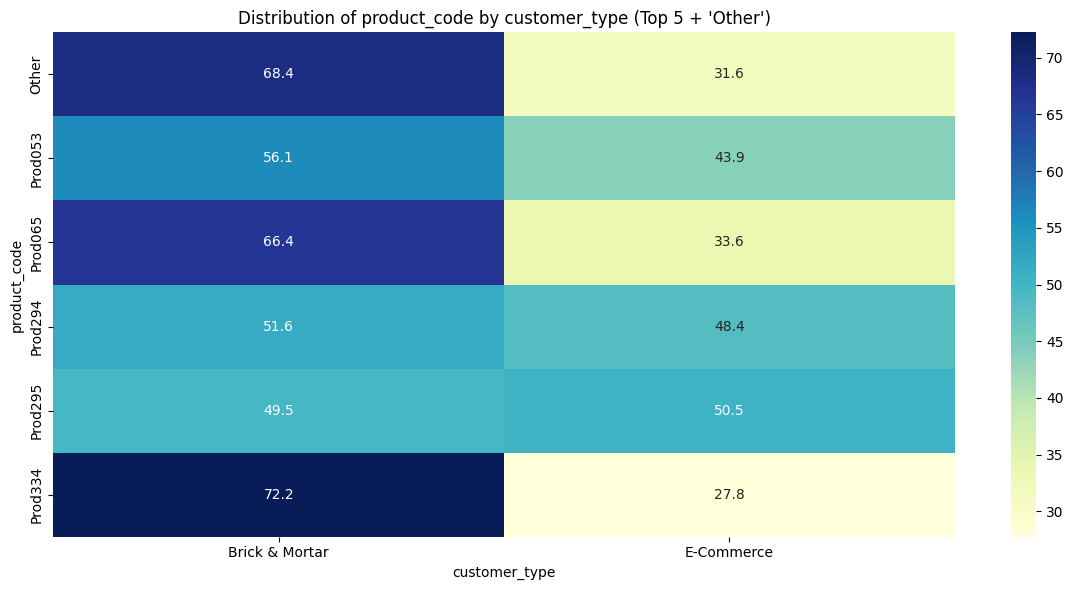

sales_qty customer_name


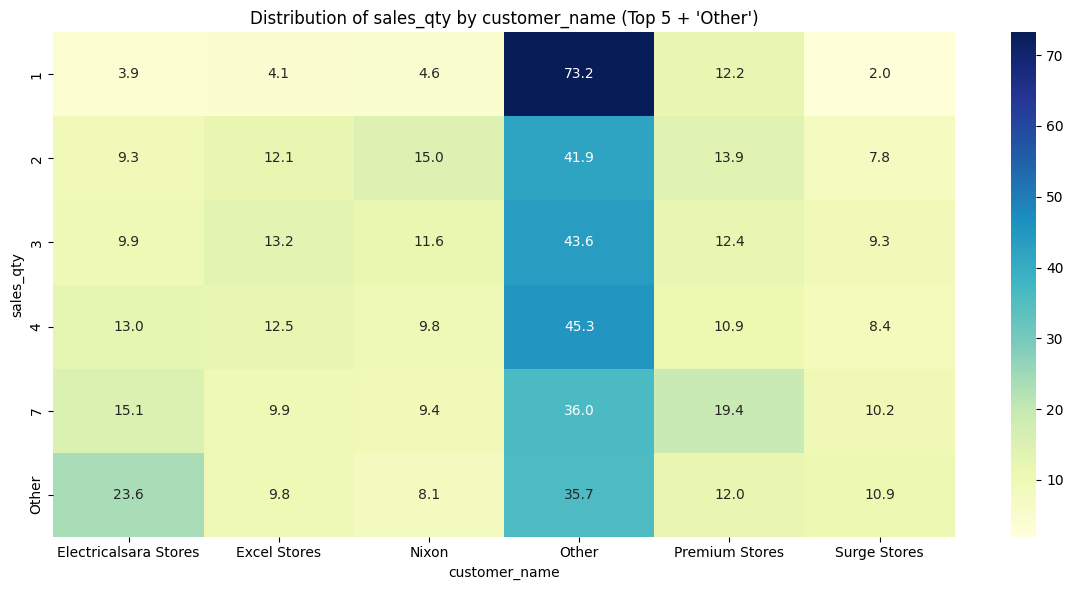

sales_qty customer_type


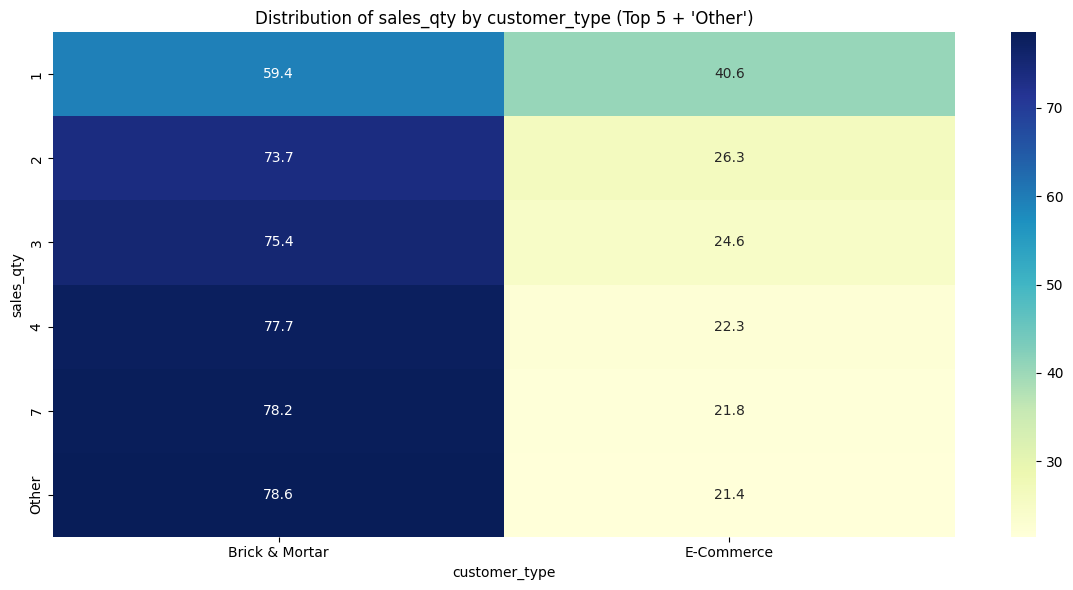

sales_qty markets_name


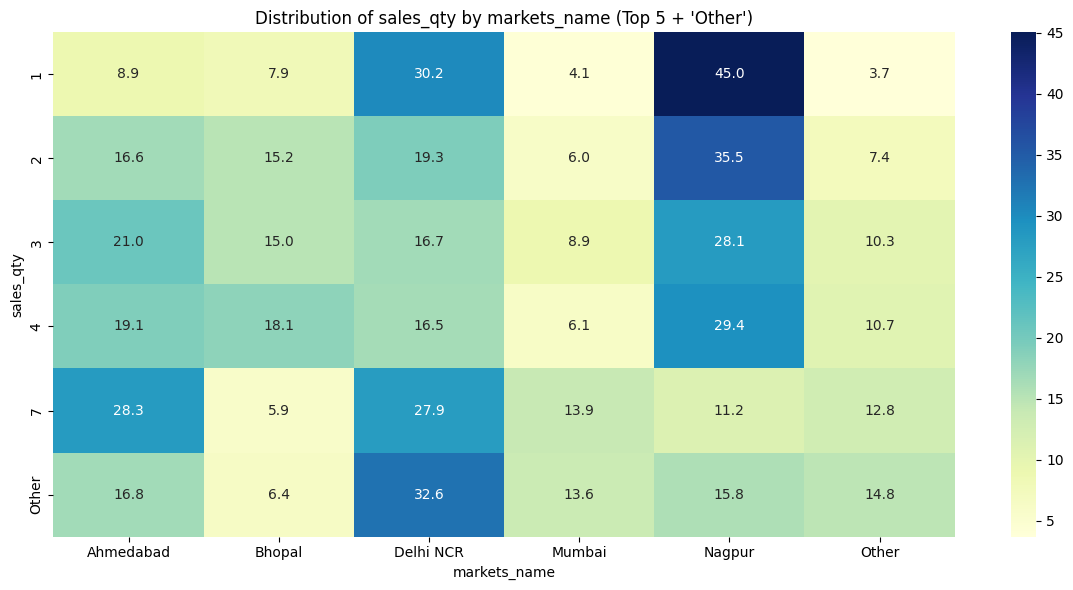

sales_qty zone


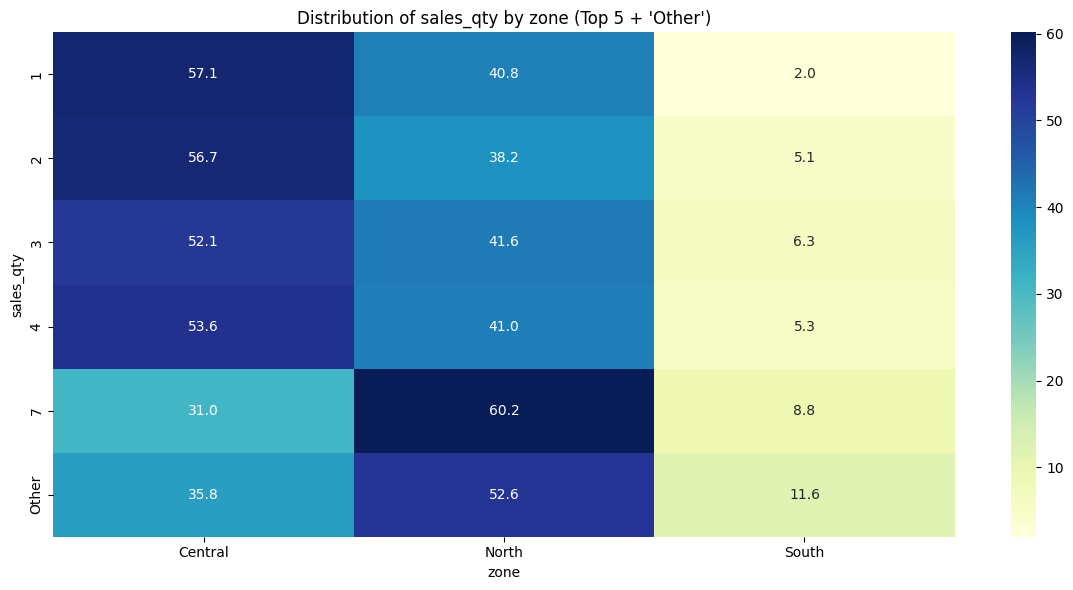

sales_qty customer_type


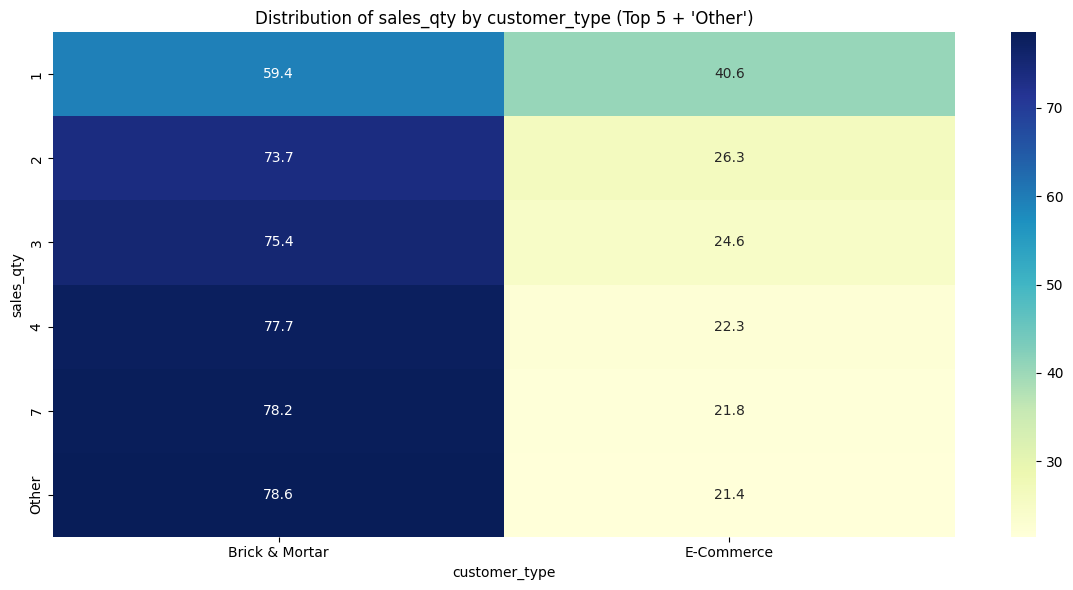

customer_name customer_type


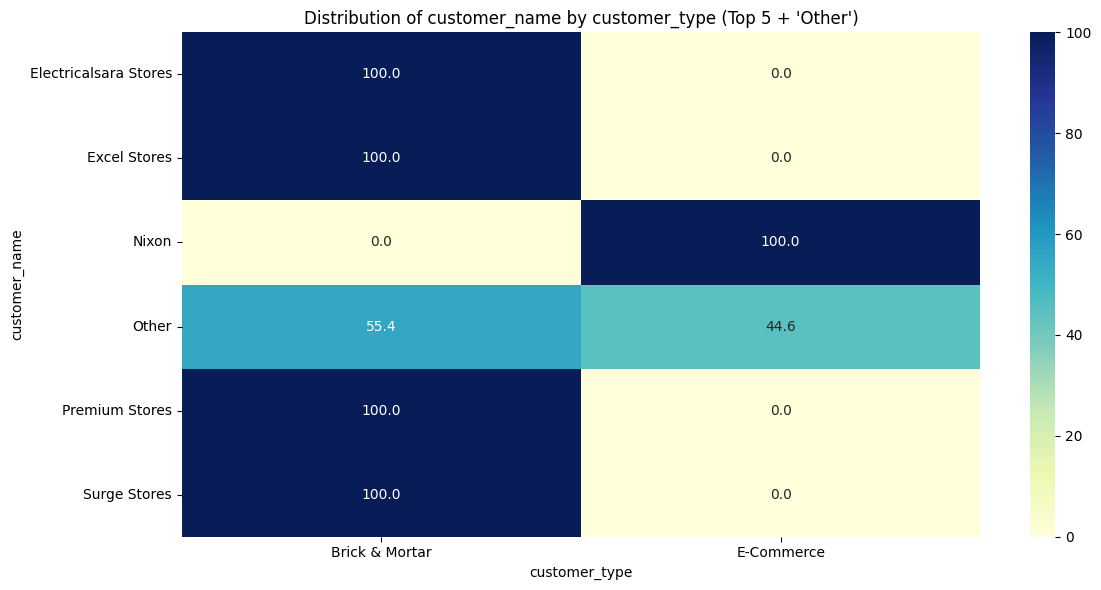

customer_name markets_name


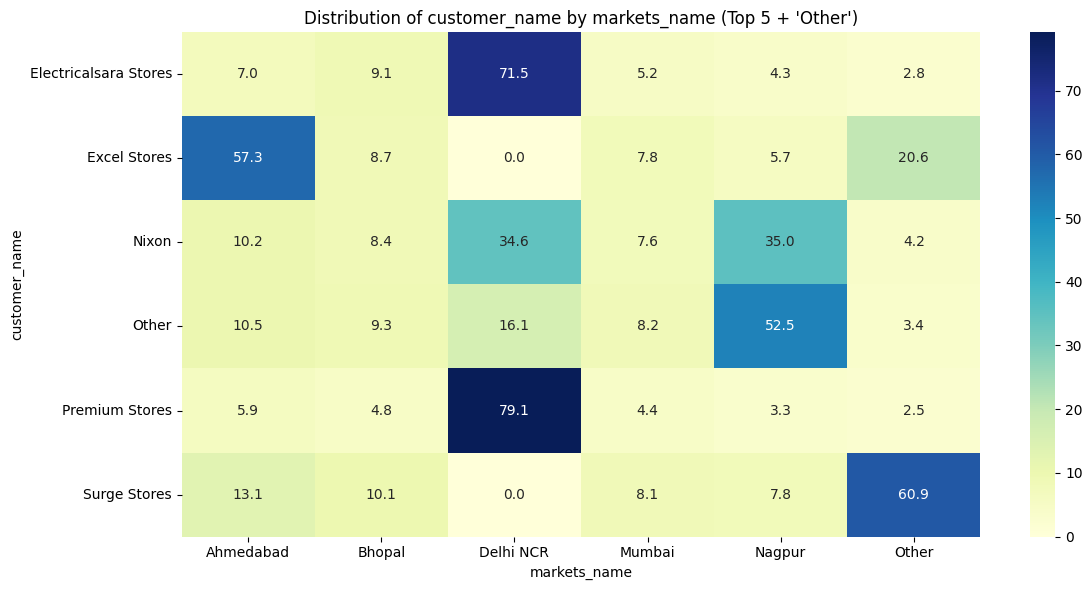

customer_name zone


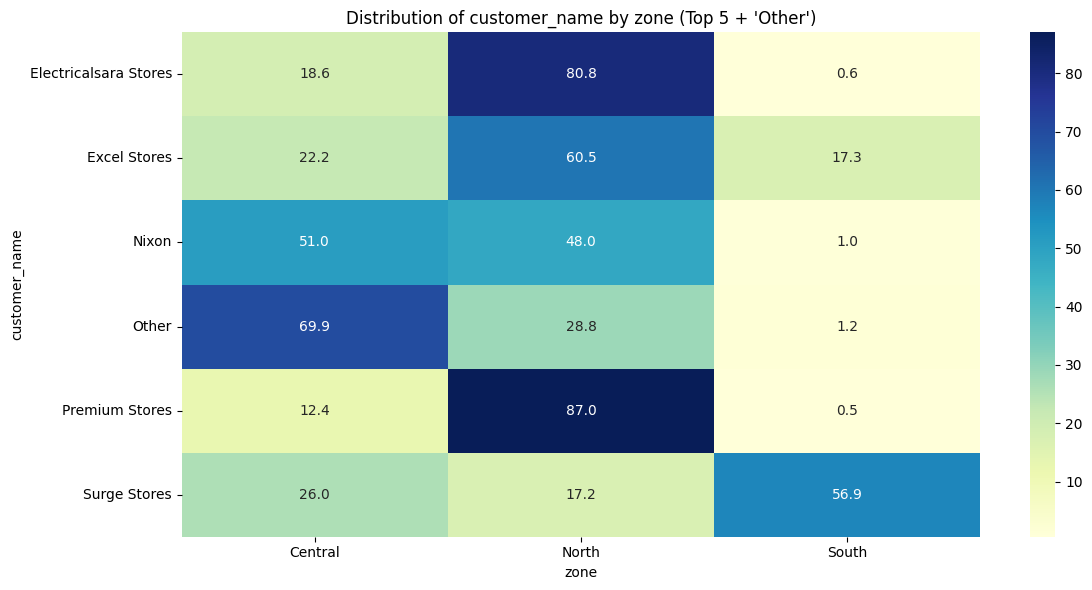

customer_name customer_type


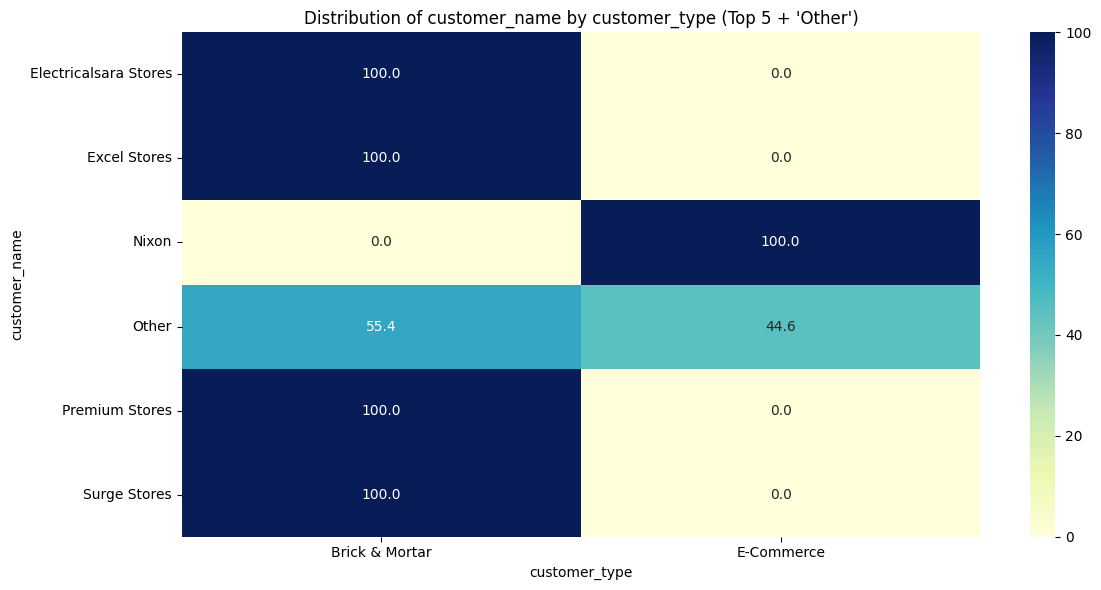

customer_type markets_name


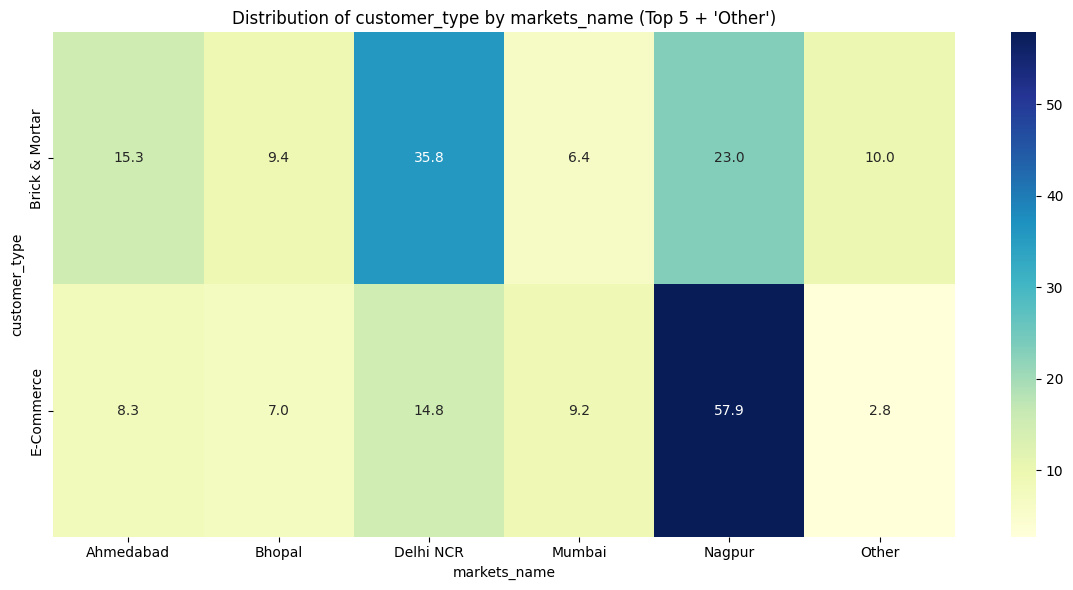

customer_type zone


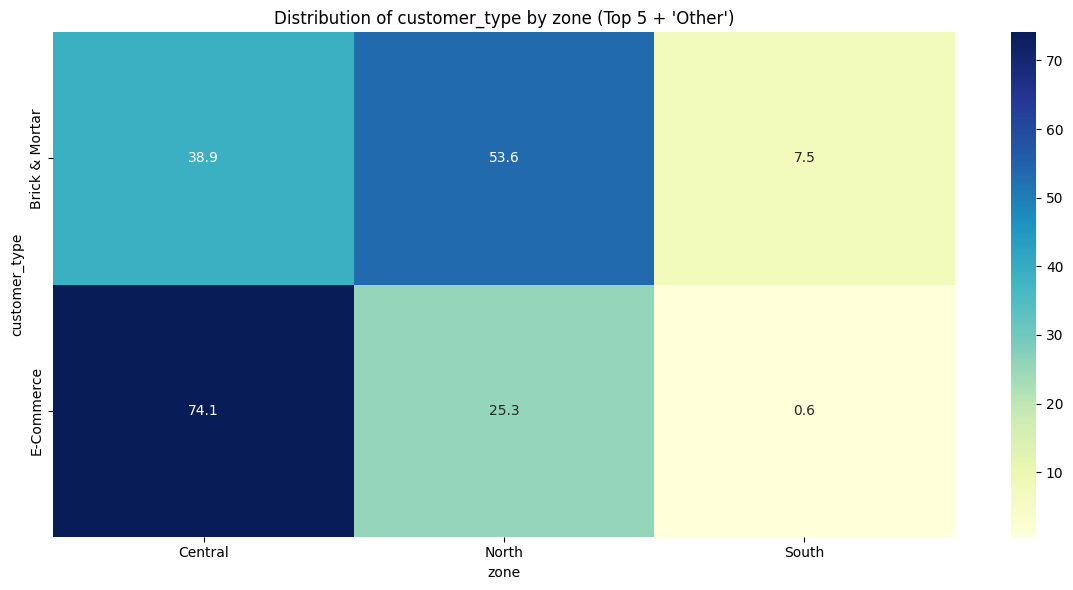

customer_type customer_type


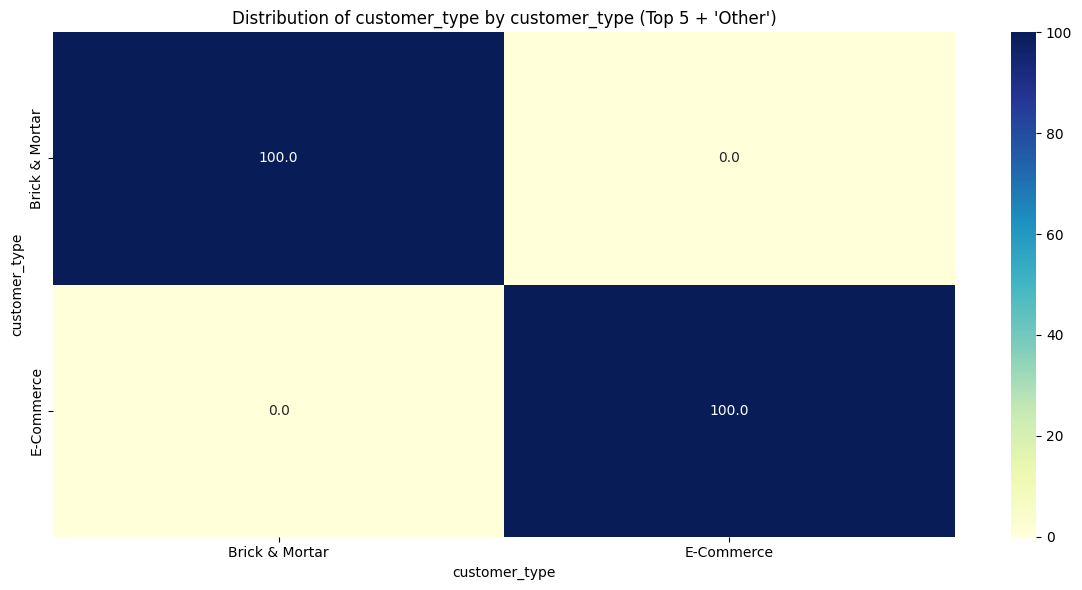

markets_name zone


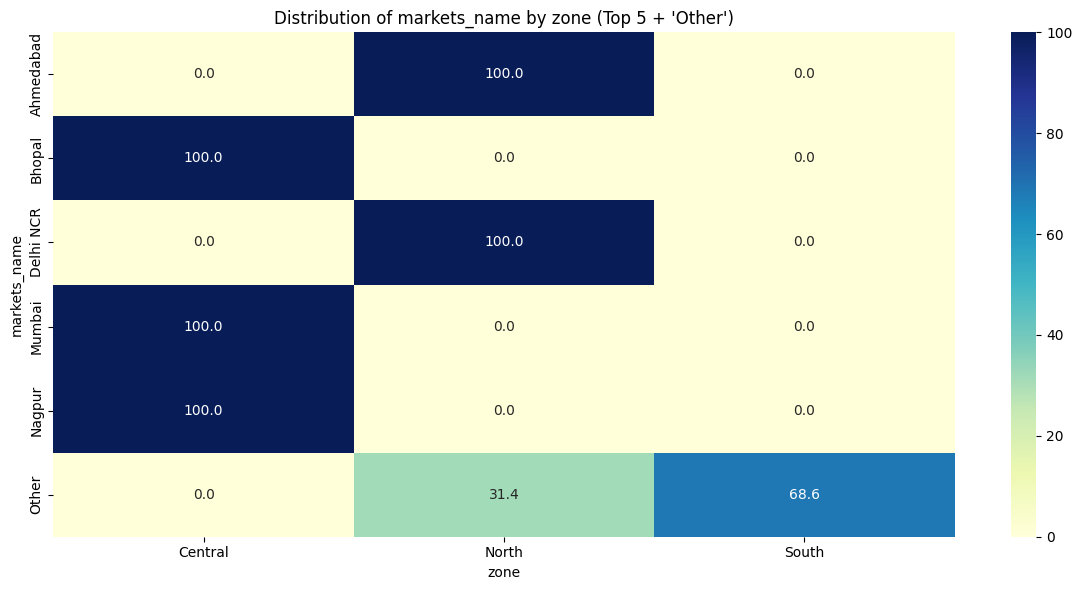

markets_name customer_type


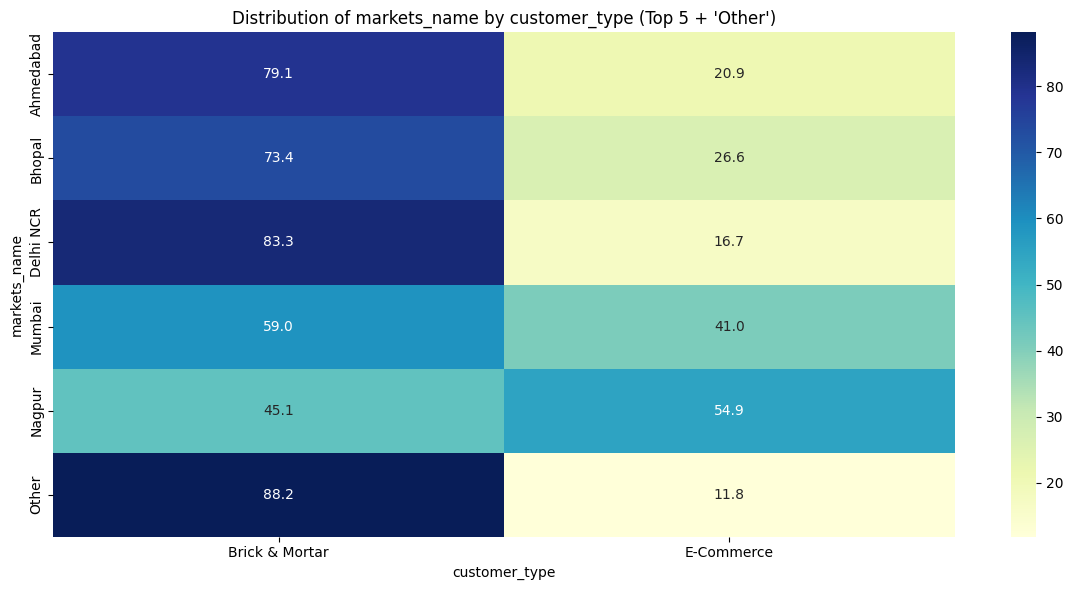

zone customer_type


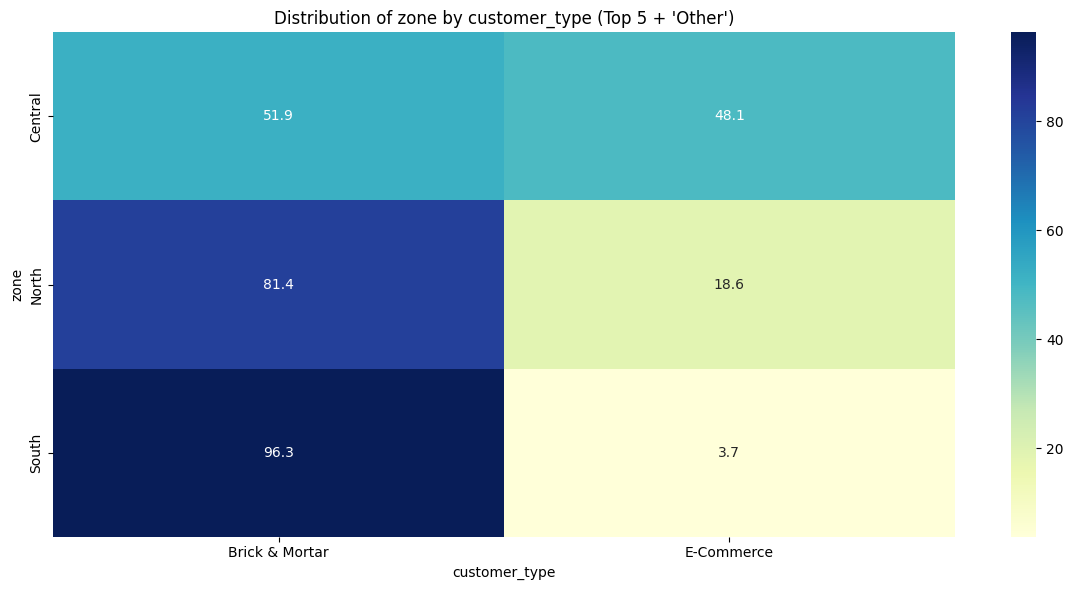

In [ ]:
for c in column_pairs(cat_columns = cat_cols):
  print(c[0],c[1])
  plot_distribution_heatmap(df=df,
                               row_col=c[0],
                               col_col=c[1],
                               top_n=5)

## Numeric columns

### Sales qty column

In [ ]:
df['sales_qty'].min(), df['sales_qty'].max()

(1, 14049)

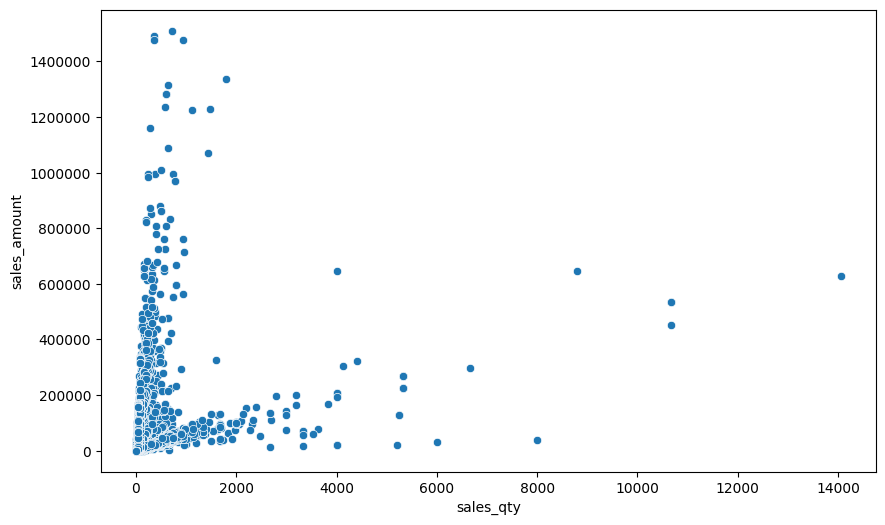

In [ ]:
#Checking sales qty by sales amount
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='sales_qty',y='sales_amount')
plt.ticklabel_format(style='plain', axis='both', useOffset=False)
plt.show()

#### There are a lot of points grouped on the left bottom corner
This indicates we sell a reduced number of items at reduced sales amount
I have to check this over the years

<Axes: xlabel='sales_qty', ylabel='sales_amount'>

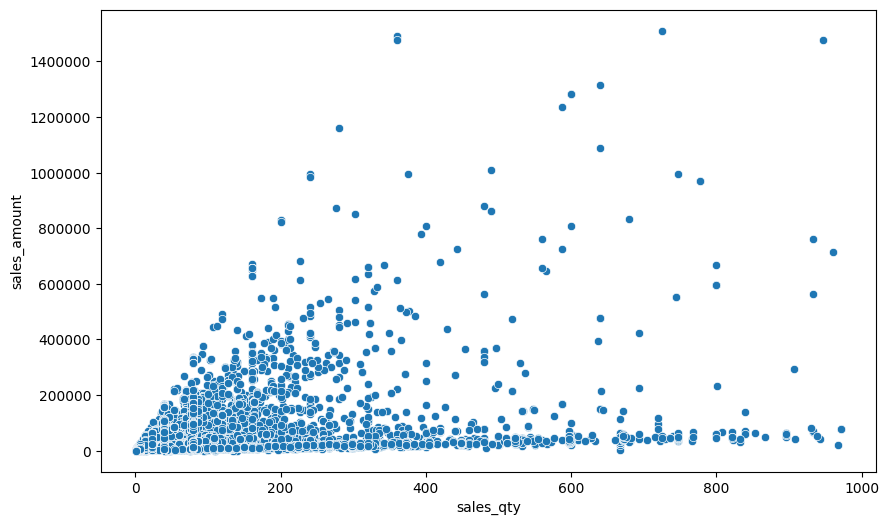

In [ ]:
plt.figure(figsize=(10,6))

temp = df[df['sales_qty'] <1000].copy()
plt.ticklabel_format(style='plain', axis='both', useOffset=False)
sns.scatterplot(data=temp, x='sales_qty',y='sales_amount')


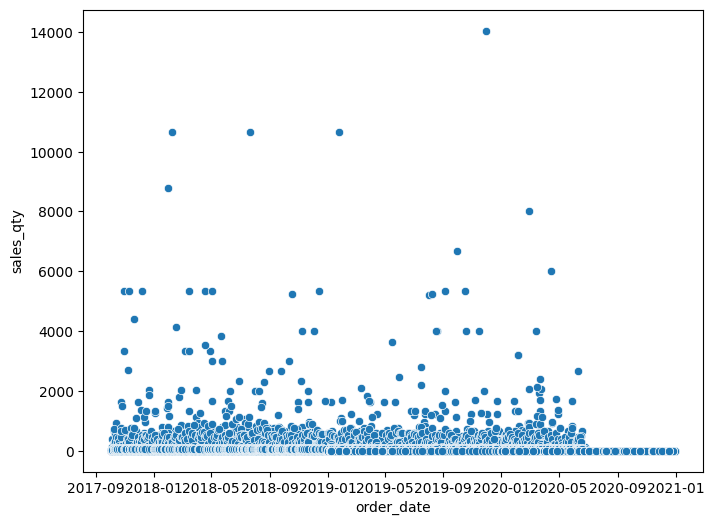

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='order_date',y='sales_qty')
plt.show()

### Sales amount column

#### By a reduced qty, we generate a big sales amount
Maybe we could focuss on these products?

In [ ]:

sales_amount_mean = df['sales_amount'].mean()
is2 = df[(df['sales_amount']>2*sales_amount_mean) & (df['sales_qty']<1000) ]
is2['product_code'].value_counts().head(7)

product_code
Prod318    1269
Prod334     585
Prod316     523
Prod324     398
Prod018     340
Prod060     324
Prod159     315
Name: count, dtype: int64

### Sales amount column

In [ ]:
df['sales_amount'].min(), df['sales_amount'].max()

(5, 1510944)

<Axes: >

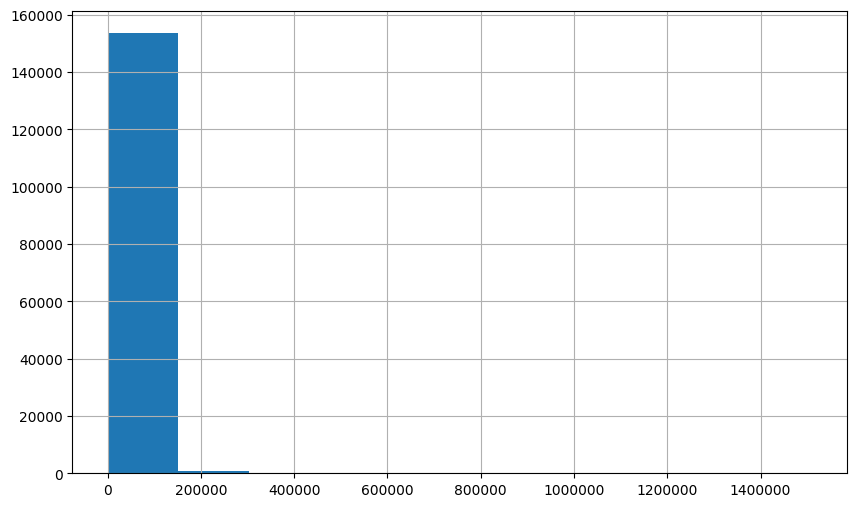

In [ ]:
plt.figure(figsize=(10,6))
plt.ticklabel_format(style='plain', axis='both', useOffset=False)

df['sales_amount'].hist()

<Axes: >

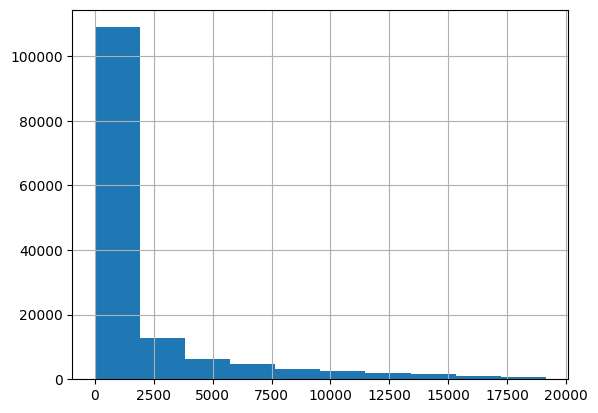

In [ ]:
temp = df[df['sales_amount']< 3*sales_amount_mean].copy()
temp['sales_amount'].hist()

#### This confirms that we have tons of sales at low sales_amount

<Axes: >

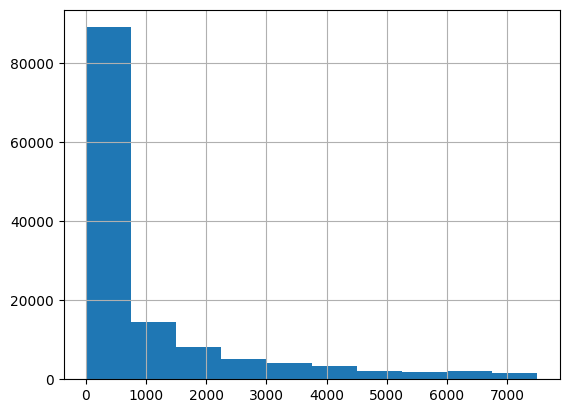

In [ ]:
temp = df[df['sales_amount']< 7500].copy()
temp['sales_amount'].hist()


### cost price column

In [ ]:
cost_price_mean =  df['cost_price'].mean()
df['cost_price'].min(), df['cost_price'].max(), cost_price_mean

(3.05, 1846742.5, np.float64(6219.966333866488))

<Axes: >

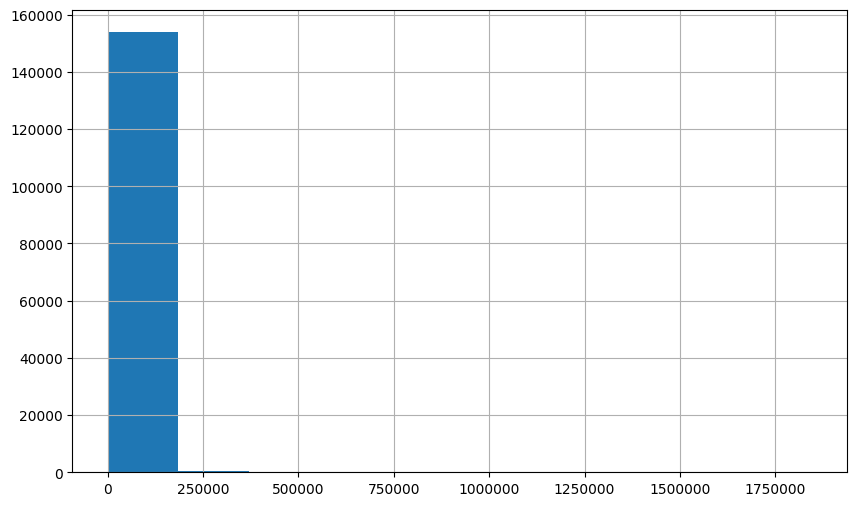

In [ ]:
plt.figure(figsize=(10,6))
plt.ticklabel_format(style='plain', axis='both', useOffset=False)
df['cost_price'].hist()

#### This shows that most of our products are low cost price
I could expect that most of our sales amount came from low cost price products

<Axes: >

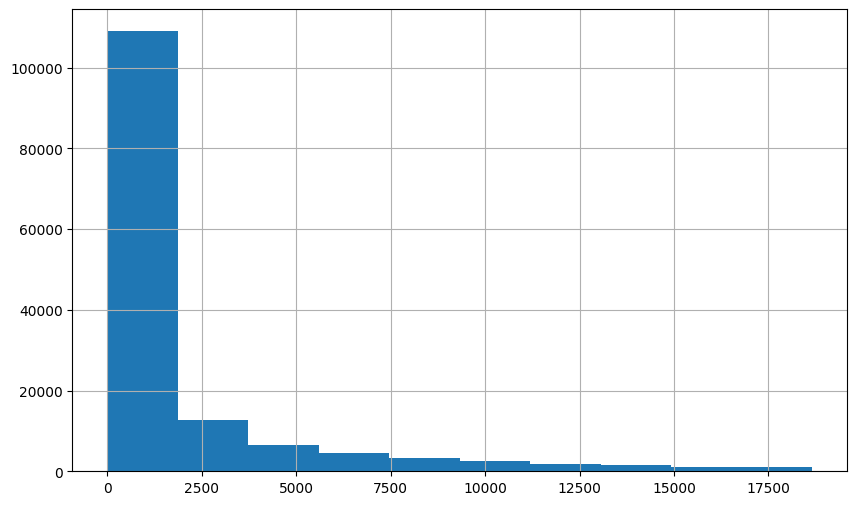

In [ ]:
temp = df[df['cost_price'] < 3*cost_price_mean]
plt.figure(figsize=(10,6))
plt.ticklabel_format(style='plain', axis='both', useOffset=False)
temp['cost_price'].hist()


<Axes: xlabel='cost_price', ylabel='sales_amount'>

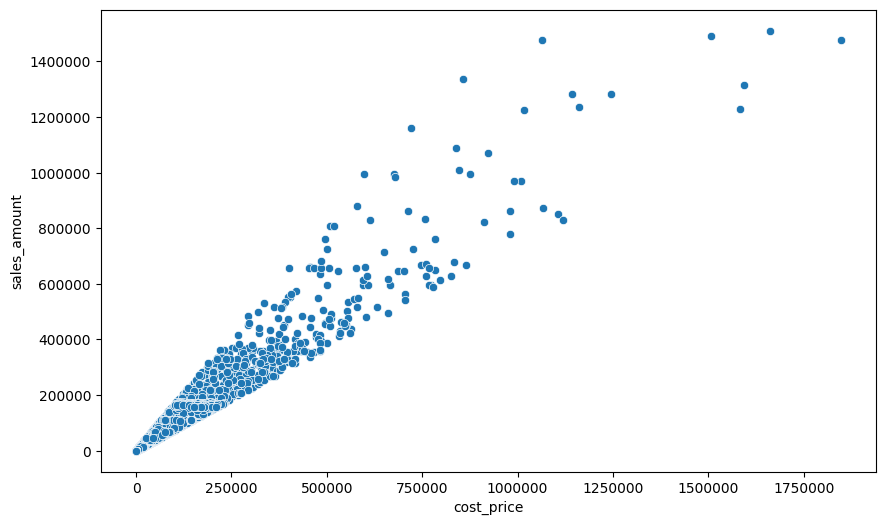

In [ ]:
plt.figure(figsize=(10,6))

plt.ticklabel_format(style='plain', axis='both', useOffset=False)
sns.scatterplot(data=df, x='cost_price',y='sales_amount')


#### I have two types of data to compare with profit
Where we have most of our data and
Where we have 'outliers'

<Axes: xlabel='cost_price', ylabel='sales_amount'>

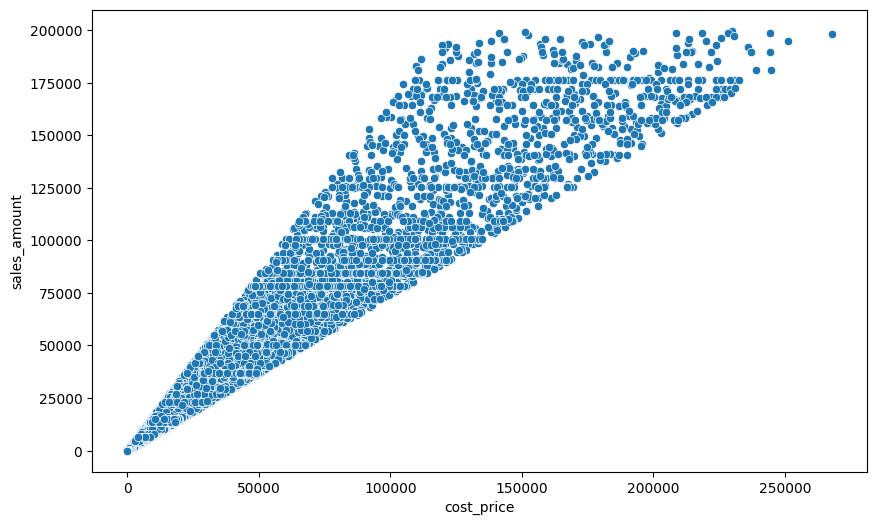

In [ ]:
#Most of our sales are on this area
plt.figure(figsize=(10,6))
temp = df[(df['cost_price']<500000)& (df['sales_amount']<200000)]
plt.ticklabel_format(style='plain', axis='both', useOffset=False)
sns.scatterplot(data=temp, x='cost_price',y='sales_amount')


### Profit margin column

In [ ]:
df['profit_margin'].min(),df['profit_margin'].max(),df['profit_margin'].mean()

(-369348.5, 481775.04, np.float64(159.6507538189565))

#### Here there area lot of neg profit values because we want to get into new markets

In [ ]:
df[df['profit_margin'] <0]

product_code market_code order_date  sales_qty  sales_amount currency  \
1           Prod279     Mark011 2017-10-18          1           102      INR   
4           Prod279     Mark011 2018-03-09          1           102      INR   
6           Prod279     Mark011 2018-03-22          1           102      INR   
7           Prod279     Mark011 2018-03-23          1           102      INR   
9           Prod279     Mark011 2018-04-16          1           102      INR   
...             ...         ...        ...        ...           ...      ...   
154419      Prod238     Mark011 2020-11-28          1            42      INR   
154421      Prod238     Mark011 2020-12-18          1            42      INR   
154423      Prod300     Mark011 2020-12-18          1            42      INR   
154424      Prod280     Mark011 2020-01-09          1            28      INR   
154428      Prod300     Mark011 2020-03-08          1            42      INR   

        profit_margin_percentage  profit_margin  cost_price customer_code  \
1                          -0.12         -12.24      114.24        Cus020   
4                          -0.35         -35.70      137.70        Cus033   
6                          -0.35         -35.70      137.70        Cus008   
7                          -0.35         -35.70      137.70        Cus030   
9                          -0.06          -6.12      108.12        Cus038   
...                          ...            ...         ...           ...   
154419                     -0.30         -12.60       54.60        Cus037   
154421                     -0.28         -11.76       53.76        Cus037   
154423                     -0.26         -10.92       52.92        Cus037   
154424                     -0.19          -5.32       33.32        Cus037   
154428                     -0.21          -8.82       50.82        Cus037   

        year  transaction_count  is_weekend     customer_name   customer_type  \
1       2017                  1       False             Nixon      E-Commerce   
4       2018                  1       False           All-Out      E-Commerce   
6       2018                  1       False  Acclaimed Stores  Brick & Mortar   
7       2018                  1       False         Synthetic      E-Commerce   
9       2018                  1       False            Leader      E-Commerce   
...      ...                ...         ...               ...             ...   
154419  2020                  1        True            Propel      E-Commerce   
154421  2020                  1       False            Propel      E-Commerce   
154423  2020                  1       False            Propel      E-Commerce   
154424  2020                  1       False            Propel      E-Commerce   
154428  2020                  1        True            Propel      E-Commerce   

        product_type markets_code markets_name     zone  
1       Distribution      Mark011       Nagpur  Central  
4       Distribution      Mark011       Nagpur  Central  
6       Distribution      Mark011       Nagpur  Central  
7       Distribution      Mark011       Nagpur  Central  
9       Distribution      Mark011       Nagpur  Central  
...              ...          ...          ...      ...  
154419     Own Brand      Mark011       Nagpur  Central  
154421     Own Brand      Mark011       Nagpur  Central  
154423           NaN      Mark011       Nagpur  Central  
154424           NaN      Mark011       Nagpur  Central  
154428           NaN      Mark011       Nagpur  Central  

[71199 rows x 19 columns]

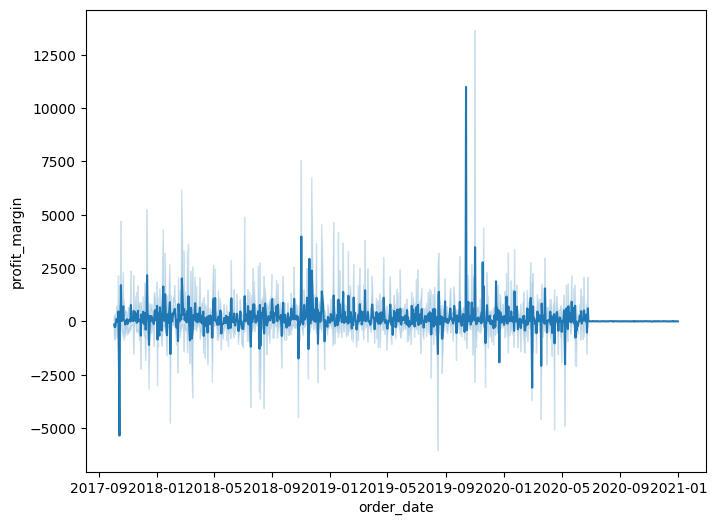

In [ ]:
plt.figure(figsize=(8,6))
sns.lineplot(data=df, x='order_date',y='profit_margin')
plt.show()

In [ ]:
monthly_mean  = df.resample('m', on='order_date')['profit_margin'].median().reset_index()
monthly_mean.head()

<ipython-input-93-a0e93a0c8a90>:1: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_mean  = df.resample('m', on='order_date')['profit_margin'].median().reset_index()


order_date  profit_margin
0 2017-10-31           4.51
1 2017-11-30           5.60
2 2017-12-31           6.86
3 2018-01-31           5.24
4 2018-02-28           4.15

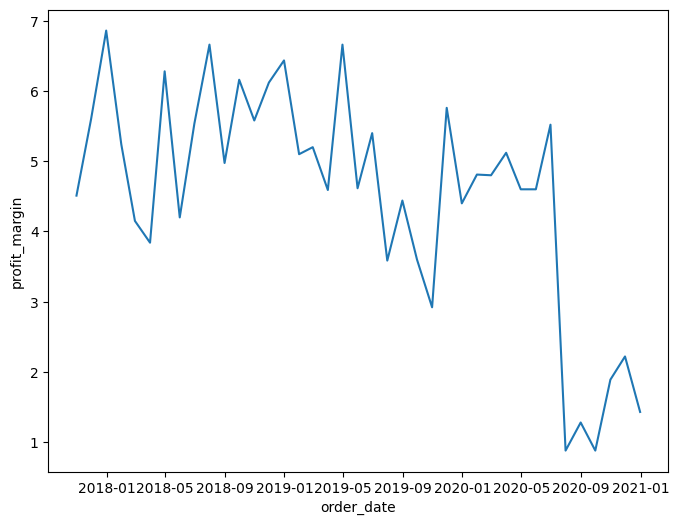

In [ ]:
plt.figure(figsize=(8,6))
sns.lineplot(data=monthly_mean, x='order_date',y='profit_margin')
plt.show()

### Profit margin percentage column

<ipython-input-95-7af13333a223>:1: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_mean1  = df.resample('m', on='order_date')['profit_margin_percentage'].median().reset_index()


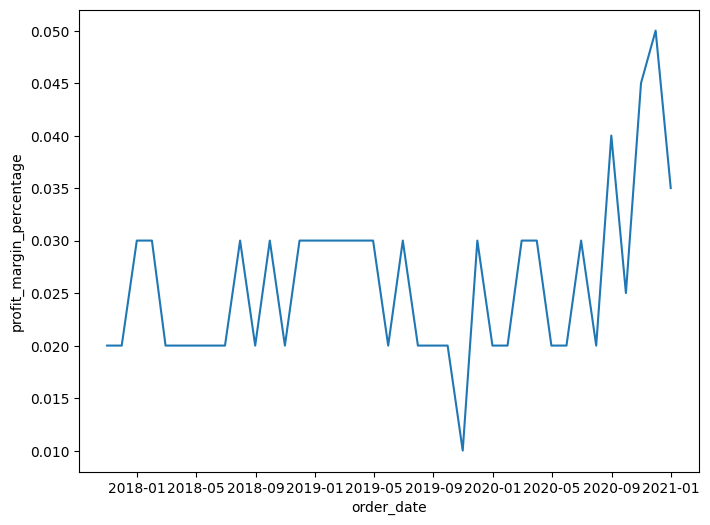

In [ ]:
monthly_mean1  = df.resample('m', on='order_date')['profit_margin_percentage'].median().reset_index()
plt.figure(figsize=(8,6))
sns.lineplot(data=monthly_mean1, x='order_date',y='profit_margin_percentage')
plt.show()

### Sales amount column

In [ ]:
df['sales_amount'].min(),df['sales_amount'].max(),df['sales_amount'].mean()

(5, 1510944, np.float64(6379.617087685444))

<Axes: >

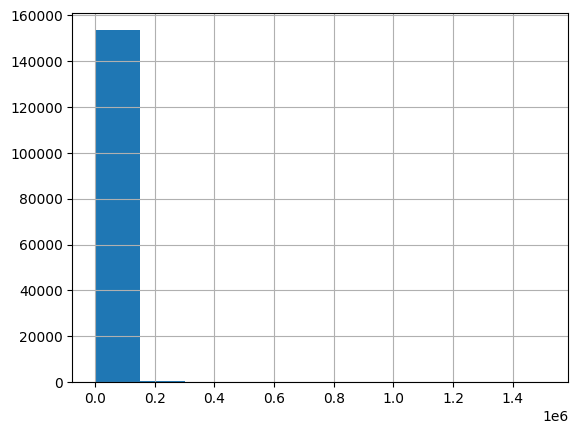

In [ ]:
df['sales_amount'].hist()

<ipython-input-98-3372ec95d308>:1: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_mean1  = df.resample('m', on='order_date')['sales_amount'].median().reset_index()


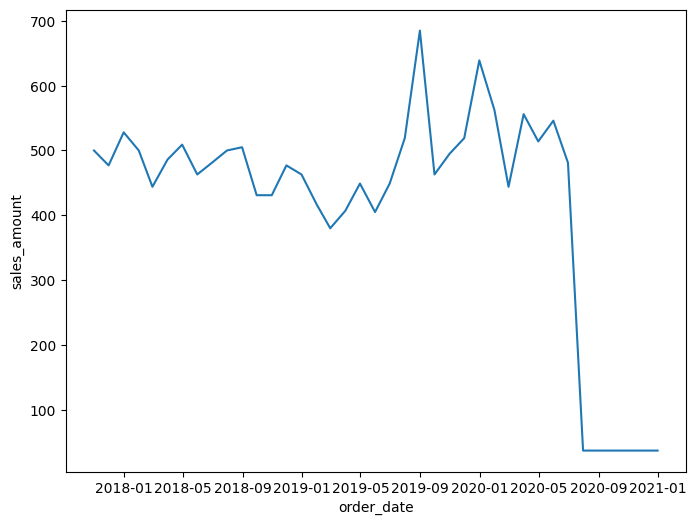

In [ ]:
monthly_mean1  = df.resample('m', on='order_date')['sales_amount'].median().reset_index()
plt.figure(figsize=(8,6))
sns.lineplot(data=monthly_mean1, x='order_date',y='sales_amount')
plt.show()

### Checking for all numerical cols

In [ ]:
df.head()

product_code market_code order_date  sales_qty  sales_amount currency  \
0      Prod279     Mark011 2017-10-11          1           102      INR   
1      Prod279     Mark011 2017-10-18          1           102      INR   
2      Prod279     Mark011 2017-10-19          1           102      INR   
3      Prod279     Mark011 2017-11-08          1           102      INR   
4      Prod279     Mark011 2018-03-09          1           102      INR   

   profit_margin_percentage  profit_margin  cost_price customer_code  year  \
0                      0.39          39.78       62.22        Cus020  2017   
1                     -0.12         -12.24      114.24        Cus020  2017   
2                      0.29          29.58       72.42        Cus020  2017   
3                      0.36          36.72       65.28        Cus020  2017   
4                     -0.35         -35.70      137.70        Cus033  2018   

   transaction_count  is_weekend customer_name customer_type  product_type  \
0                  1       False         Nixon    E-Commerce  Distribution   
1                  1       False         Nixon    E-Commerce  Distribution   
2                  1       False         Nixon    E-Commerce  Distribution   
3                  1       False         Nixon    E-Commerce  Distribution   
4                  1       False       All-Out    E-Commerce  Distribution   

  markets_code markets_name     zone  
0      Mark011       Nagpur  Central  
1      Mark011       Nagpur  Central  
2      Mark011       Nagpur  Central  
3      Mark011       Nagpur  Central  
4      Mark011       Nagpur  Central

In [ ]:
numerical = ['sales_qty','sales_amount',
             'profit_margin_percentage','profit_margin',
             'cost_price']

#### Skewed data: Sales qty, sales amount, cost ptice, profit margin

<Axes: xlabel='profit_margin'>

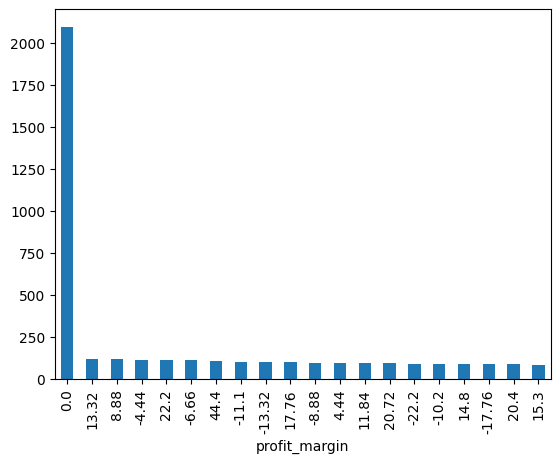

In [ ]:
df['profit_margin'].value_counts().head(20).plot(kind='bar')

<Axes: xlabel='cost_price'>

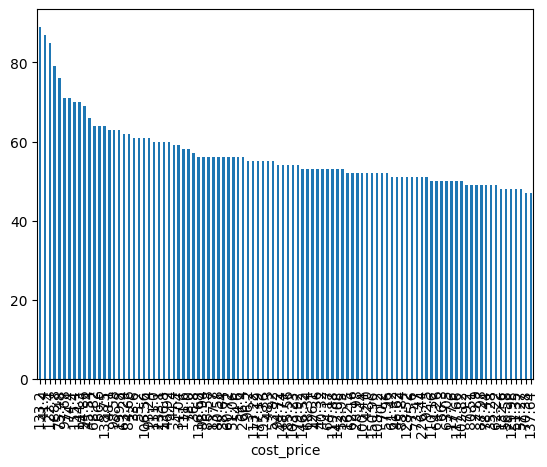

In [ ]:
df['cost_price'].value_counts().head(100).plot(kind='bar')

In [ ]:
'''for col in numerical:
  print(f"Plotting {col}")
  plt.figure(figsize=(12, 6))
  plt.title(f"Distribution of {col}")
  sns.histplot(data=df, x=col, kde=True)
  plt.show()'''


'for col in numerical:\n  print(f"Plotting {col}")\n  plt.figure(figsize=(12, 6))\n  plt.title(f"Distribution of {col}")\n  sns.histplot(data=df, x=col, kde=True)\n  plt.show()'

### Sales qty + Cat

In [ ]:
grouped = group_categories(df, cat_cols, top_n=5, other_label='Other')
grouped.head()

product_code market_code order_date  sales_qty  sales_amount currency  \
0      Prod279     Mark011 2017-10-11          1           102      INR   
1      Prod279     Mark011 2017-10-18          1           102      INR   
2      Prod279     Mark011 2017-10-19          1           102      INR   
3      Prod279     Mark011 2017-11-08          1           102      INR   
4      Prod279     Mark011 2018-03-09          1           102      INR   

   profit_margin_percentage  profit_margin  cost_price customer_code  ...  \
0                      0.39          39.78       62.22        Cus020  ...   
1                     -0.12         -12.24      114.24        Cus020  ...   
2                      0.29          29.58       72.42        Cus020  ...   
3                      0.36          36.72       65.28        Cus020  ...   
4                     -0.35         -35.70      137.70        Cus033  ...   

   product_type  markets_code  markets_name     zone product_code_top  \
0  Distribution       Mark011        Nagpur  Central            Other   
1  Distribution       Mark011        Nagpur  Central            Other   
2  Distribution       Mark011        Nagpur  Central            Other   
3  Distribution       Mark011        Nagpur  Central            Other   
4  Distribution       Mark011        Nagpur  Central            Other   

  sales_qty_top customer_name_top customer_type_top markets_name_top zone_top  
0             1             Nixon        E-Commerce           Nagpur  Central  
1             1             Nixon        E-Commerce           Nagpur  Central  
2             1             Nixon        E-Commerce           Nagpur  Central  
3             1             Nixon        E-Commerce           Nagpur  Central  
4             1             Other        E-Commerce           Nagpur  Central  

[5 rows x 25 columns]

Plotting product_code


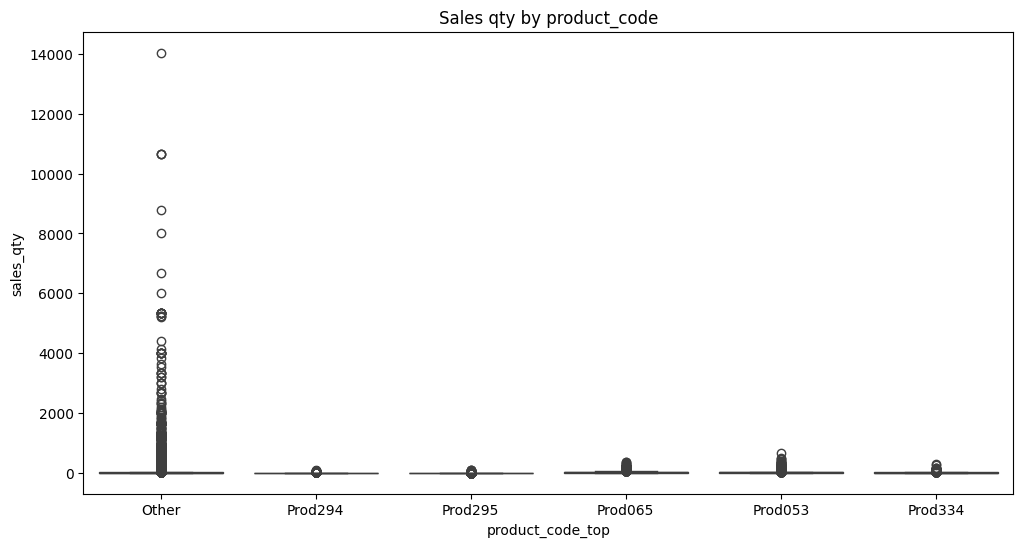

Plotting sales_qty


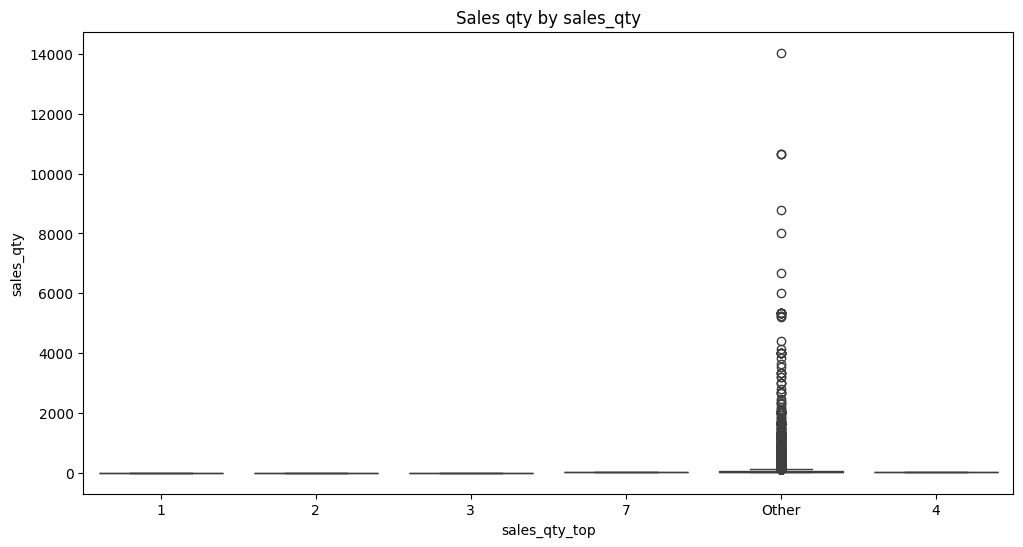

Plotting customer_name


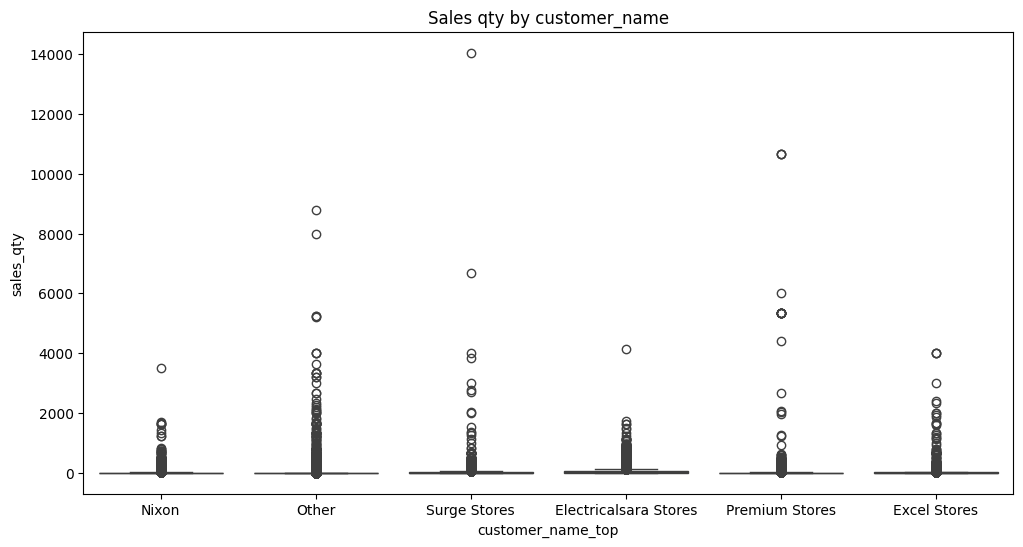

Plotting customer_type


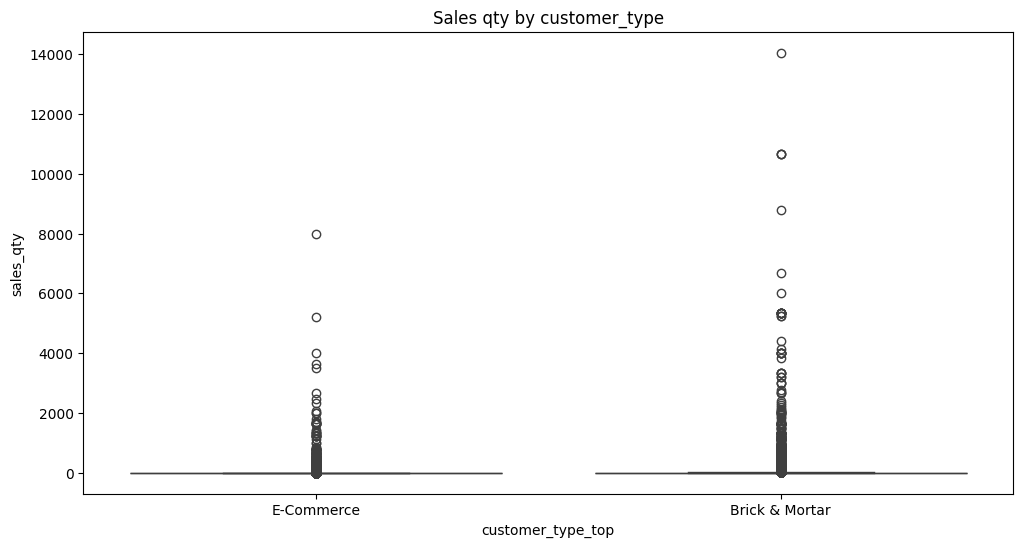

Plotting markets_name


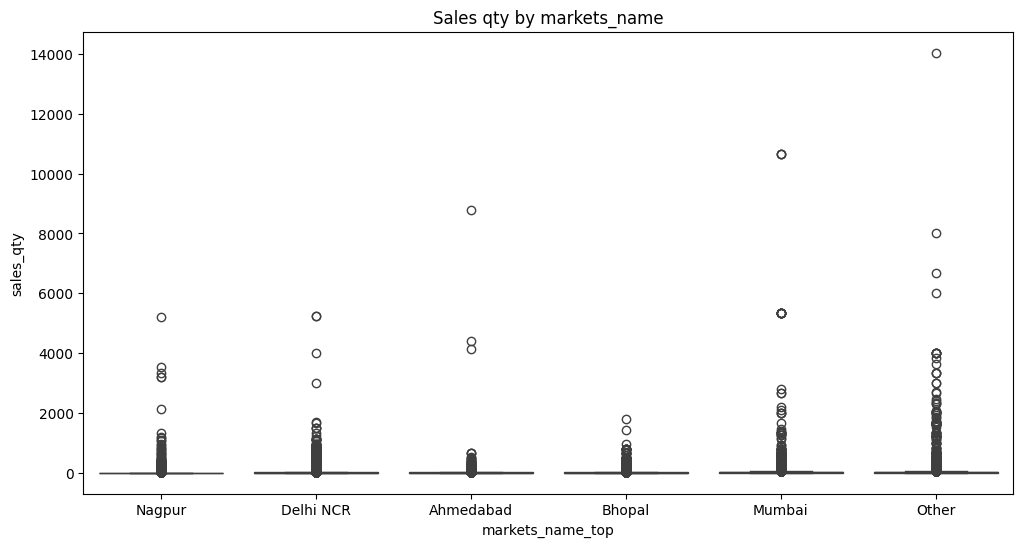

Plotting zone


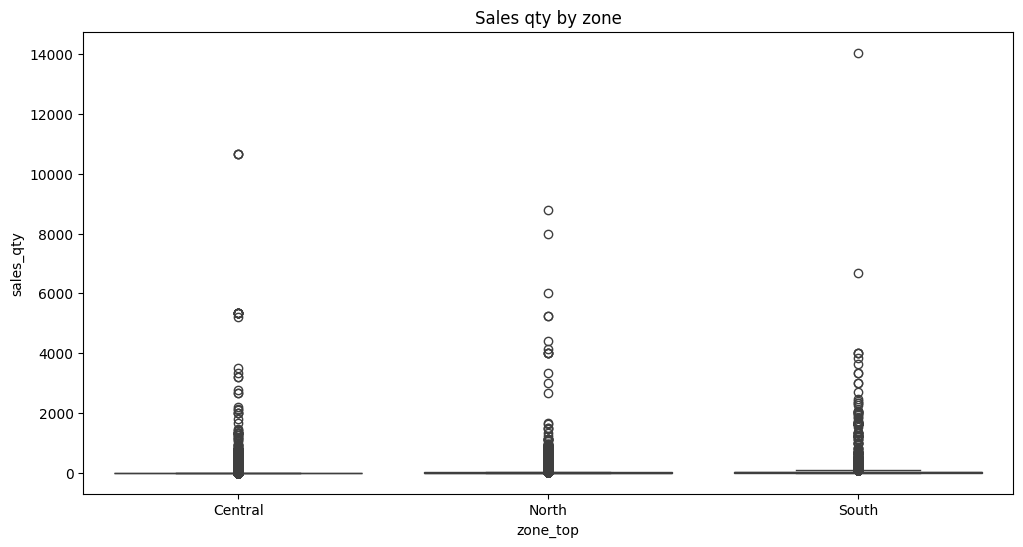

Plotting customer_type


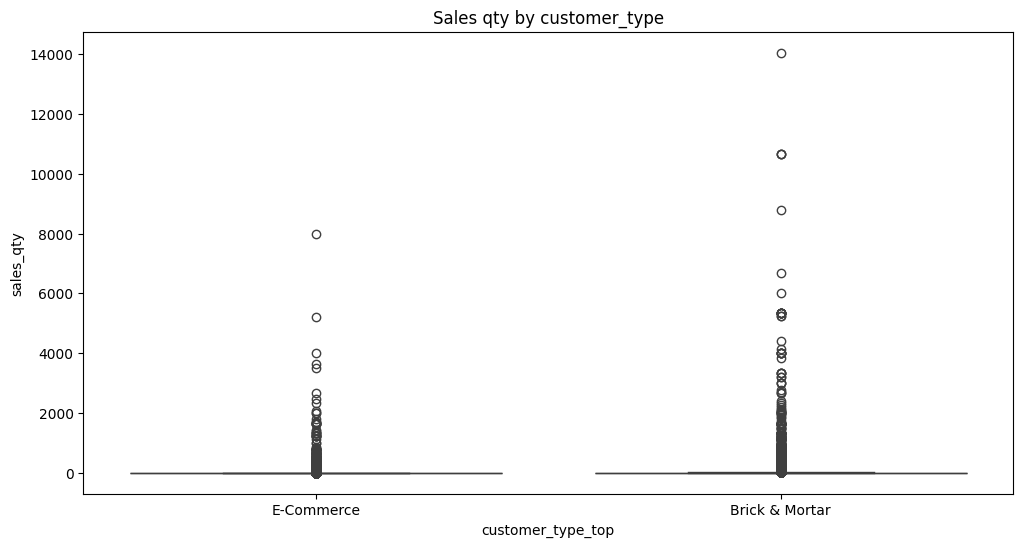

In [ ]:
for cat in cat_cols:
  print(f"Plotting {cat}")
  plt.figure(figsize=(12, 6))
  plt.title(f"Sales qty by {cat}")
  sns.boxplot(data=grouped, x=cat+'_top', y='sales_qty')
  plt.show()

### Sales amount + cat

Plotting product_code


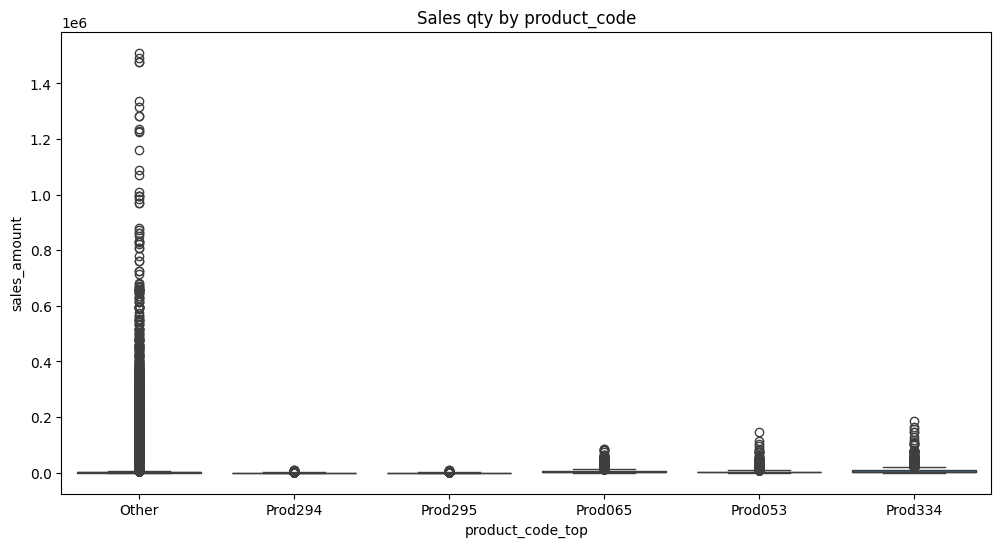

Plotting sales_qty


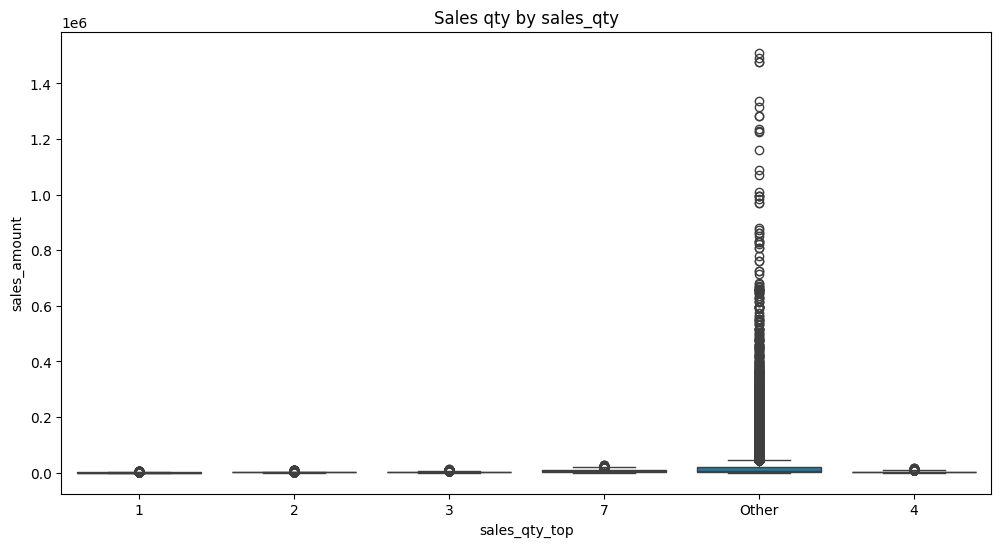

Plotting customer_name


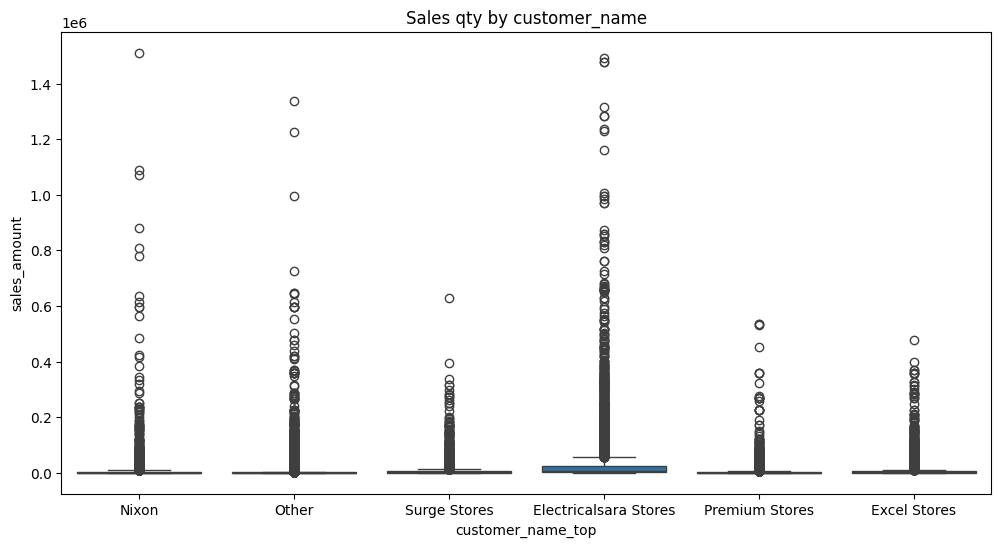

Plotting customer_type


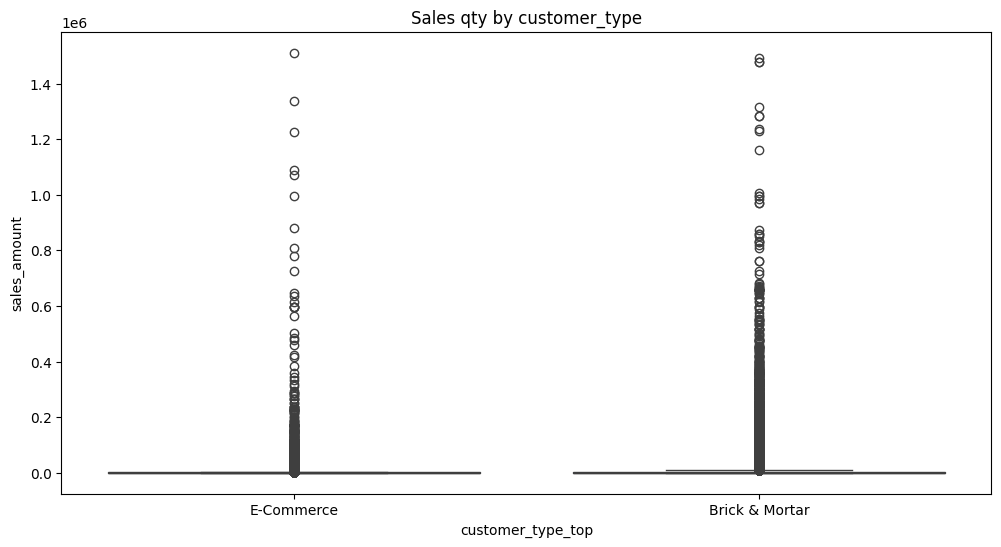

Plotting markets_name


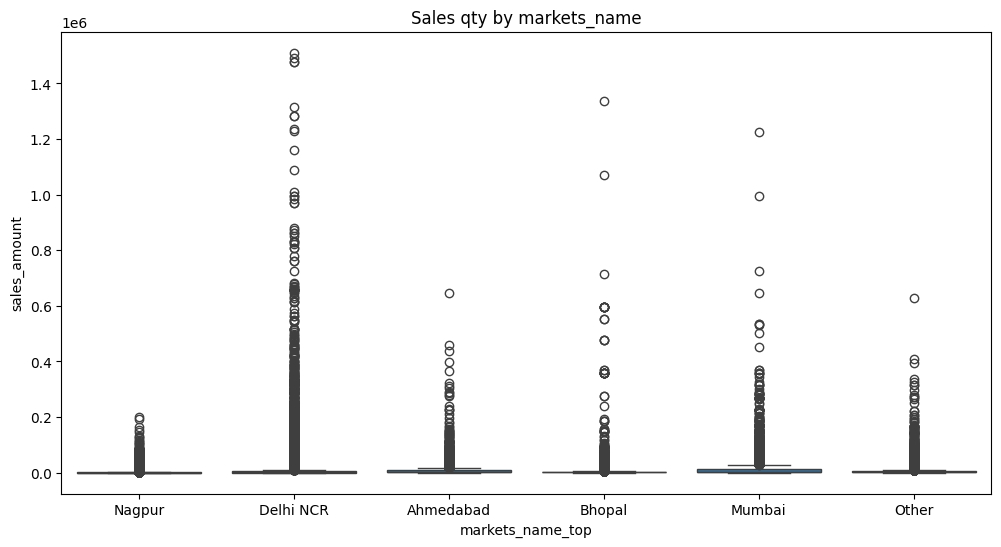

Plotting zone


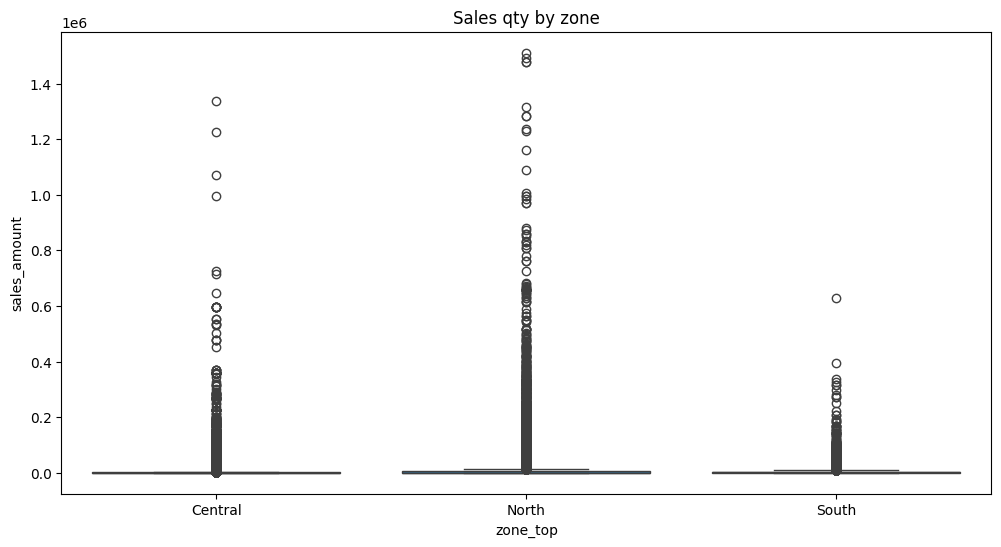

Plotting customer_type


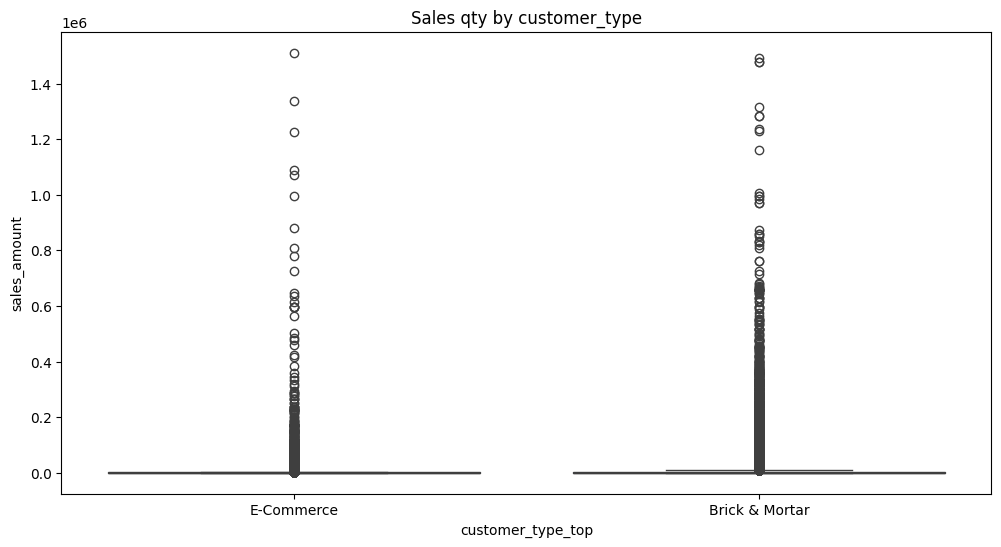

In [ ]:
for cat in cat_cols:
  print(f"Plotting {cat}")
  plt.figure(figsize=(12, 6))
  plt.title(f"Sales qty by {cat}")
  sns.boxplot(data=grouped, x=cat+'_top', y='sales_amount')
  plt.show()

### Profit margin pctg + cat

Plotting product_code


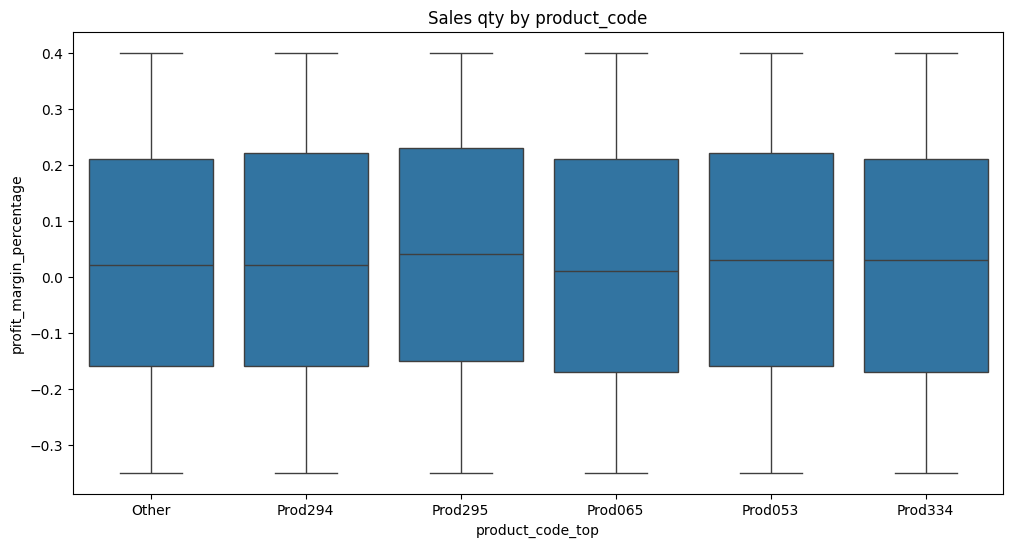

Plotting sales_qty


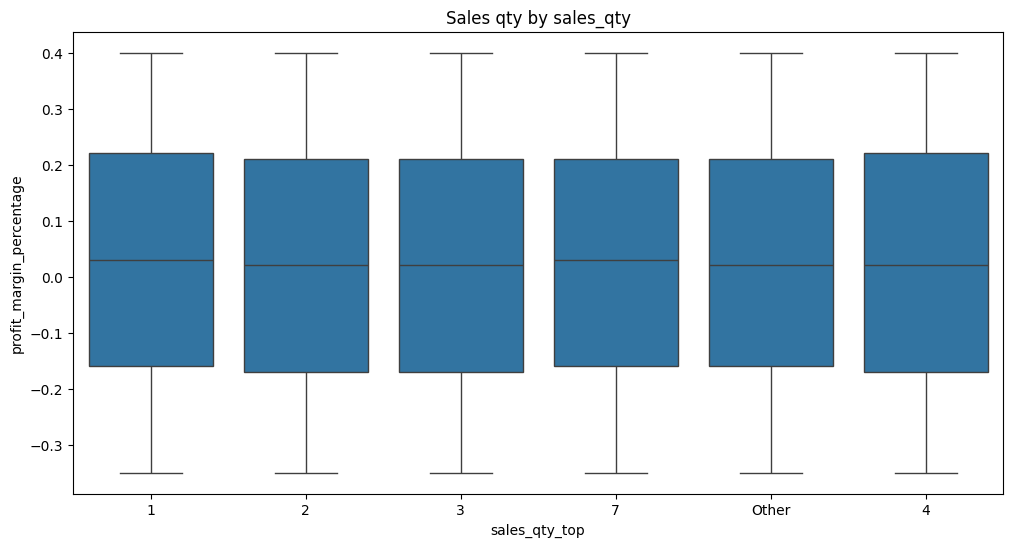

Plotting customer_name


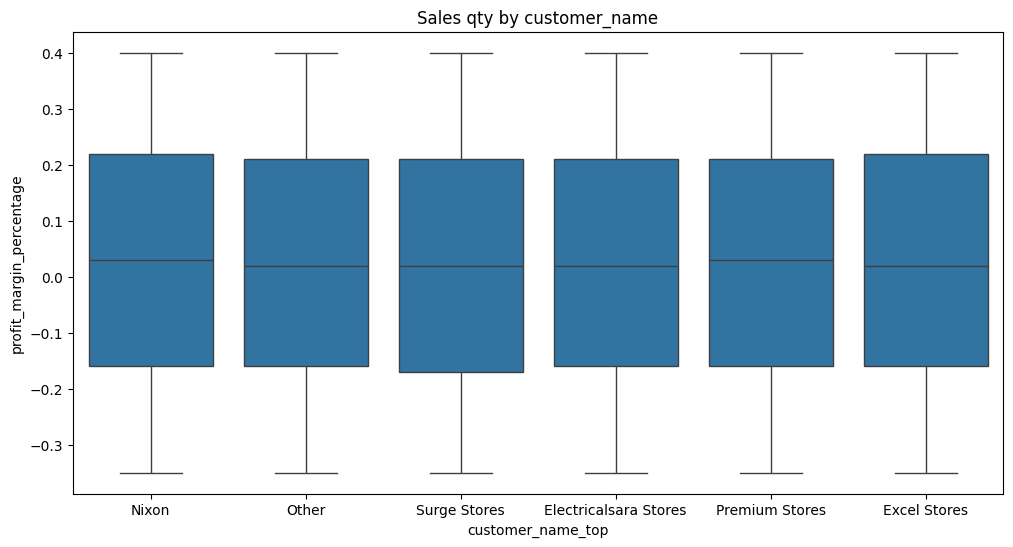

Plotting customer_type


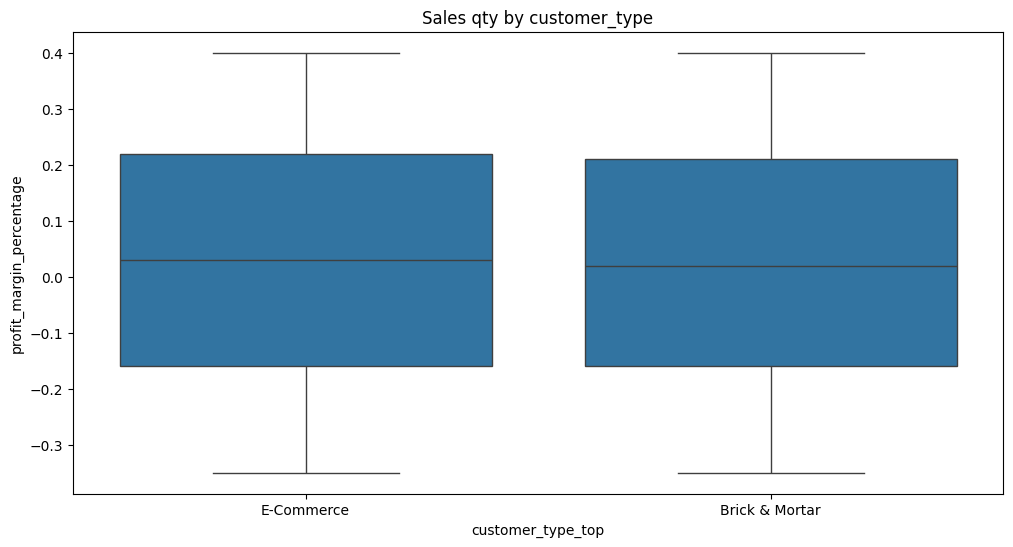

Plotting markets_name


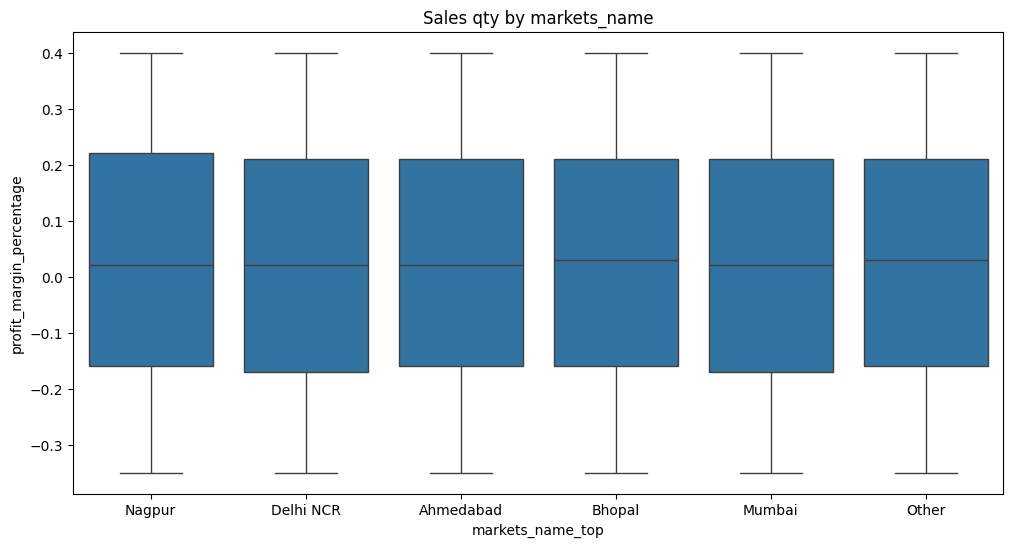

Plotting zone


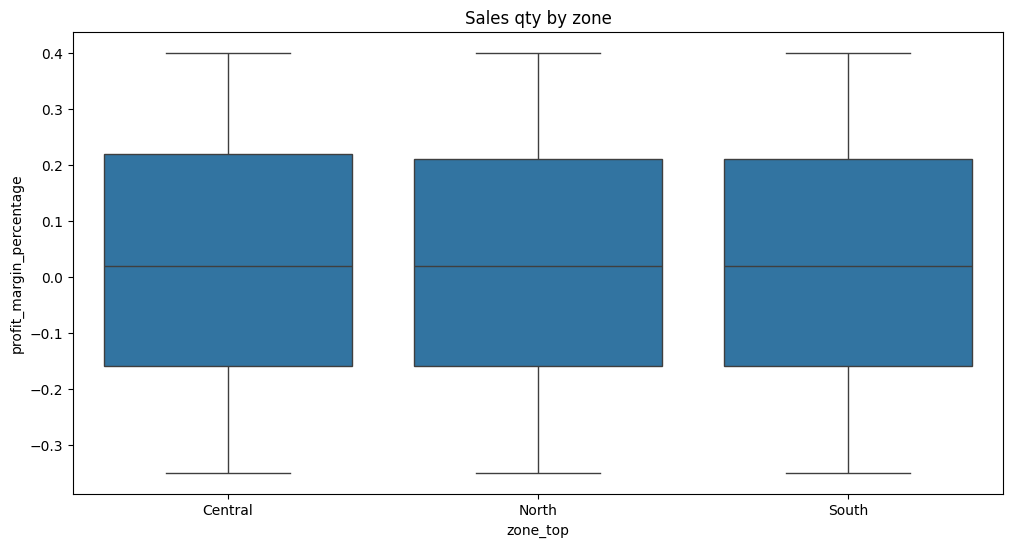

Plotting customer_type


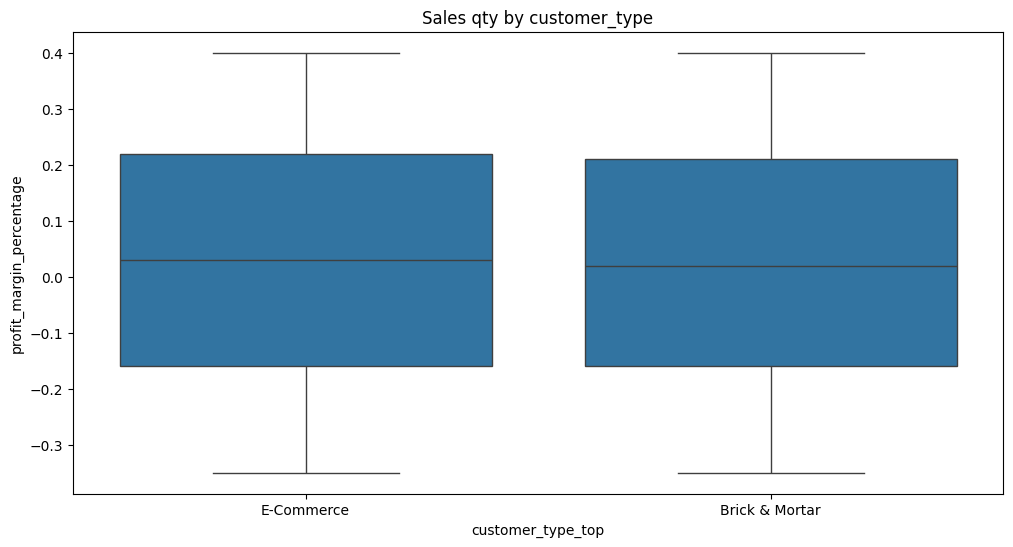

In [ ]:
for cat in cat_cols:
  print(f"Plotting {cat}")
  plt.figure(figsize=(12, 6))
  plt.title(f"Sales qty by {cat}")
  sns.boxplot(data=grouped, x=cat+'_top', y='profit_margin_percentage')
  plt.show()

### Profit margin + cat

Plotting product_code


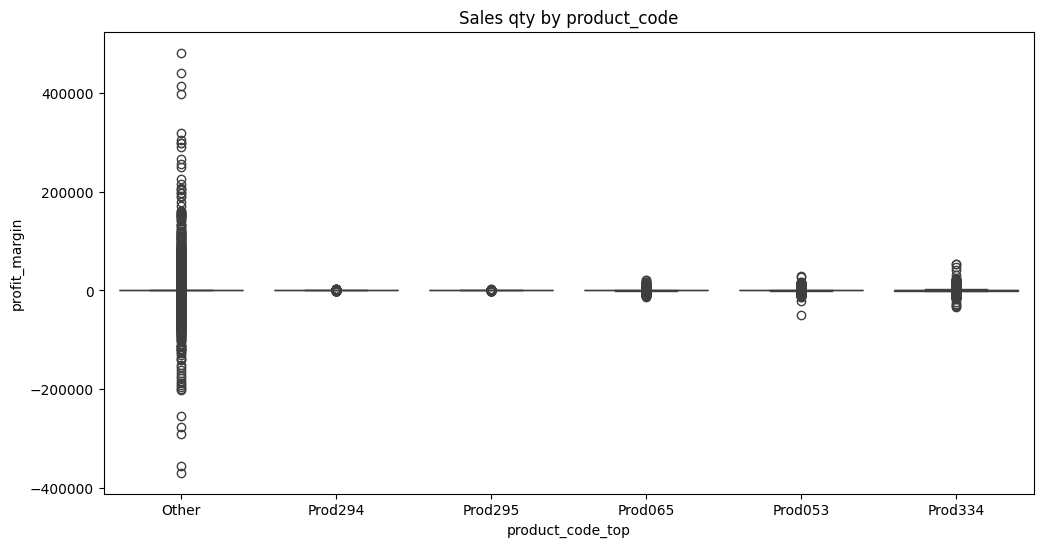

Plotting sales_qty


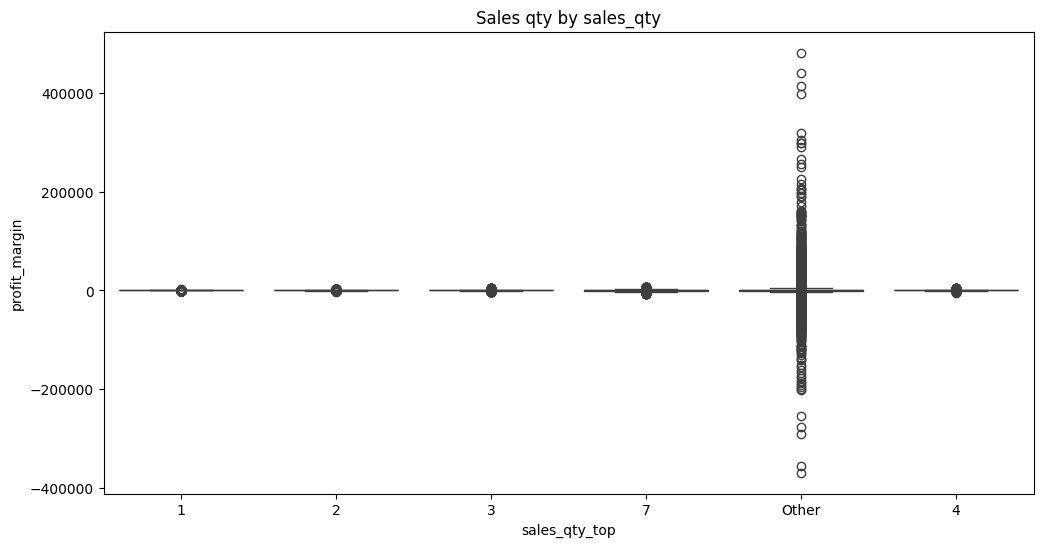

Plotting customer_name


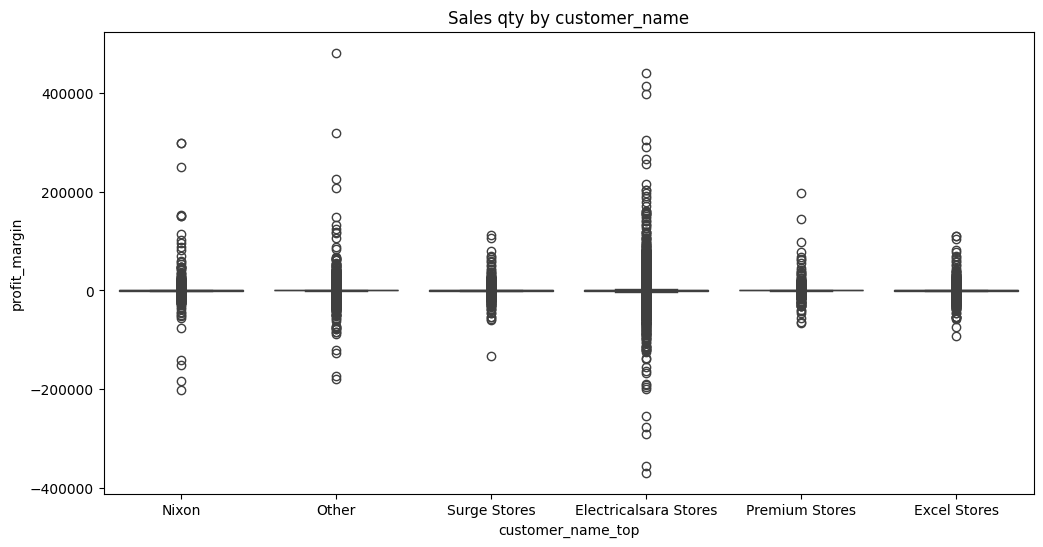

Plotting customer_type


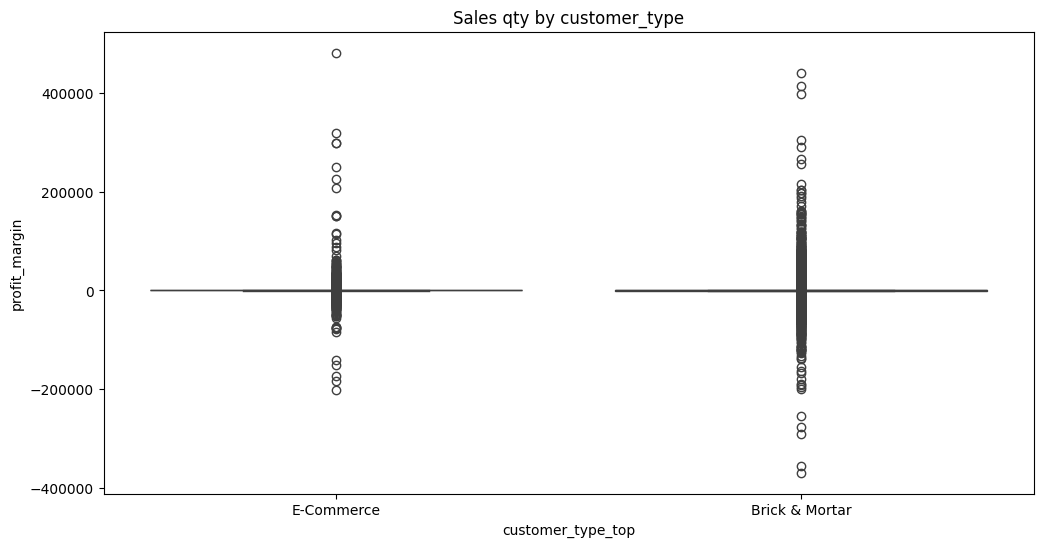

Plotting markets_name


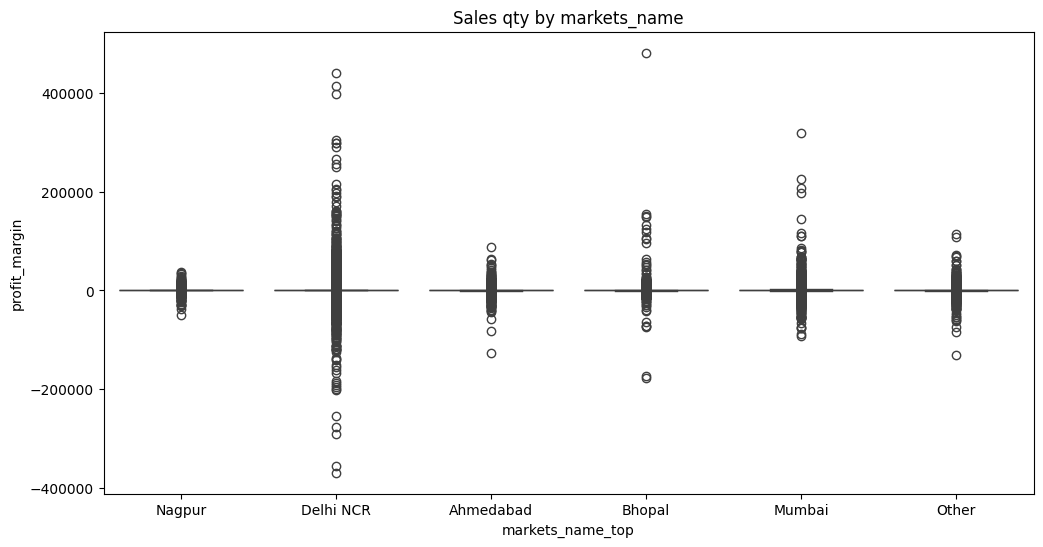

Plotting zone


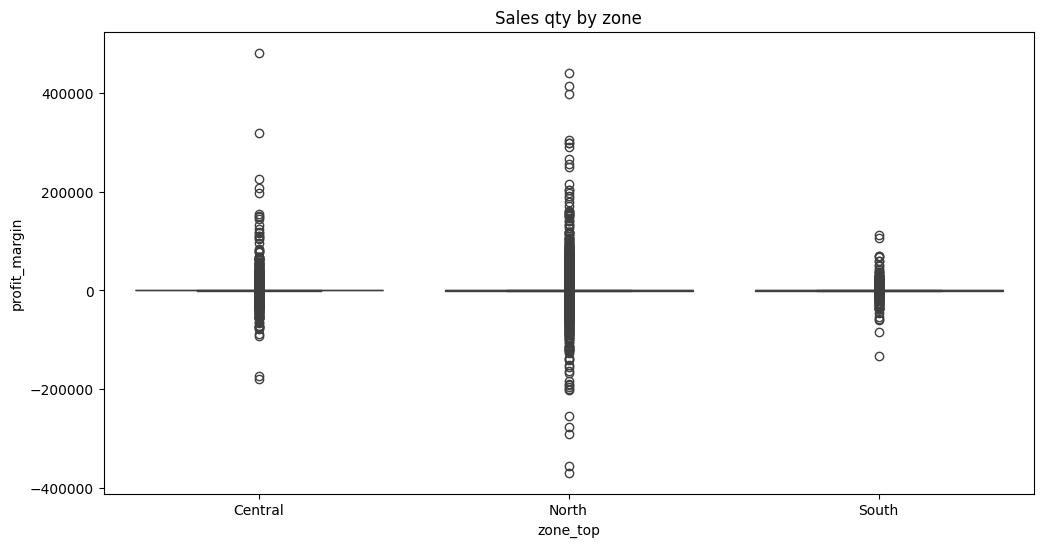

Plotting customer_type


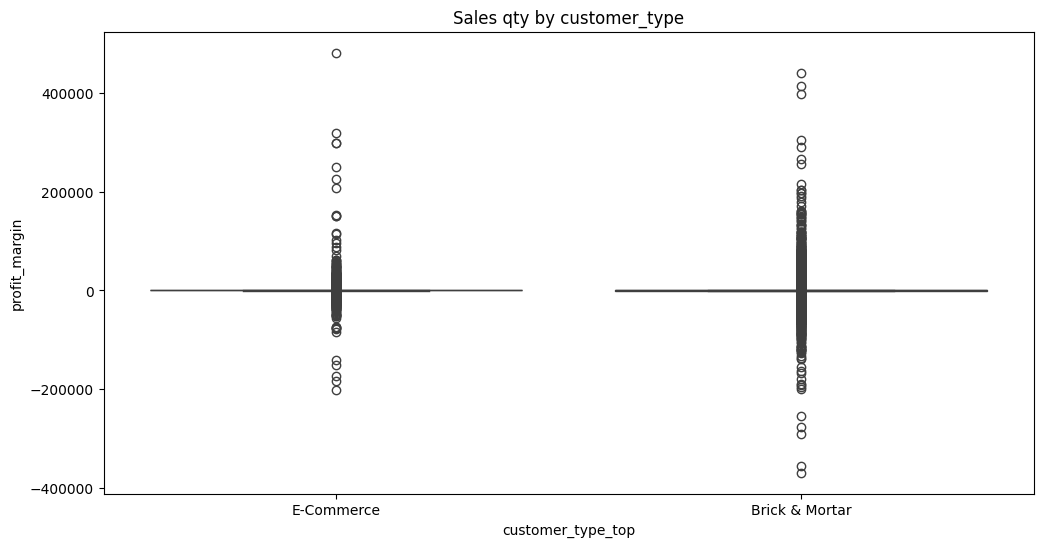

In [ ]:
for cat in cat_cols:
  print(f"Plotting {cat}")
  plt.figure(figsize=(12, 6))
  plt.title(f"Sales qty by {cat}")
  sns.boxplot(data=grouped, x=cat+'_top', y='profit_margin')
  plt.show()

## NAN values

In [ ]:
df.isna().sum()

product_code                    0
market_code                     0
order_date                      0
sales_qty                       0
sales_amount                    0
currency                        0
profit_margin_percentage        0
profit_margin                   0
cost_price                      0
customer_code                   0
year                            0
transaction_count               0
is_weekend                      0
customer_name                   0
customer_type                   0
product_type                58744
markets_code                    0
markets_name                    0
zone                            0
dtype: int64

In [ ]:
(df['product_type'].isna().sum() / len(df)) * 100

np.float64(38.03998005530121)

In [ ]:
code_to_type = df.dropna(subset=['product_type']).drop_duplicates('product_code').set_index('product_code')['product_type'].to_dict()
code_to_type

{'Prod279': 'Distribution',
 'Prod278': 'Distribution',
 'Prod056': 'Own Brand',
 'Prod131': 'Distribution',
 'Prod055': 'Own Brand',
 'Prod271': 'Own Brand',
 'Prod263': 'Distribution',
 'Prod065': 'Own Brand',
 'Prod058': 'Own Brand',
 'Prod057': 'Own Brand',
 'Prod270': 'Own Brand',
 'Prod269': 'Own Brand',
 'Prod053': 'Own Brand',
 'Prod054': 'Own Brand',
 'Prod121': 'Distribution',
 'Prod095': 'Own Brand',
 'Prod255': 'Own Brand',
 'Prod275': 'Own Brand',
 'Prod267': 'Distribution',
 'Prod265': 'Distribution',
 'Prod227': 'Own Brand',
 'Prod264': 'Distribution',
 'Prod120': 'Distribution',
 'Prod100': 'Own Brand',
 'Prod117': 'Distribution',
 'Prod064': 'Own Brand',
 'Prod075': 'Distribution',
 'Prod134': 'Own Brand',
 'Prod254': 'Own Brand',
 'Prod105': 'Own Brand',
 'Prod123': 'Own Brand',
 'Prod116': 'Distribution',
 'Prod114': 'Distribution',
 'Prod238': 'Own Brand',
 'Prod250': 'Distribution',
 'Prod079': 'Own Brand',
 'Prod113': 'Distribution',
 'Prod276': 'Own Brand',
 'Pro

In [ ]:
df['product_type'] = df['product_type'].fillna(df['product_code'].map(code_to_type))


In [ ]:
(df['product_type'].isna().sum() / len(df)) * 100

np.float64(38.03998005530121)

In [ ]:
nan_df = df[df['product_type'].isna()]
for i in df.columns:
  print(nan_df[i].value_counts(),'\n')


product_code
Prod334    3890
Prod295    3632
Prod294    3407
Prod300    3315
Prod280    3294
Prod318    3128
Prod286    3123
Prod292    2923
Prod290    2879
Prod281    2321
Prod283    2228
Prod297    2034
Prod337    1974
Prod288    1907
Prod296    1782
Prod306    1701
Prod326    1418
Prod327    1237
Prod316    1235
Prod307    1085
Prod302    1067
Prod312     907
Prod304     846
Prod301     760
Prod332     738
Prod324     652
Prod303     615
Prod339     578
Prod298     476
Prod310     360
Prod293     287
Prod319     229
Prod291     226
Prod284     222
Prod333     209
Prod317     208
Prod313     178
Prod308     178
Prod287     171
Prod320     152
Prod289     148
Prod329     140
Prod285     128
Prod338     125
Prod311     122
Prod328     121
Prod323      92
Prod321      43
Prod305      41
Prod336      38
Prod322      32
Prod331      29
Prod309      27
Prod325      26
Prod330      22
Prod314      18
Prod315      12
Prod335       4
Prod282       4
Name: count, dtype: int64 

market_code
Mar

In [ ]:
df['product_type'] = df['product_type'].fillna('Other')
(df['product_type'].isna().sum() / len(df)) * 100

np.float64(0.0)

In [ ]:
df.groupby(['market_code', df['order_date'].dt.to_period('M')]).size().unstack()

order_date   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  \
market_code                                                                  
Mark001         33.0     21.0     24.0     40.0     34.0     28.0     47.0   
Mark002        382.0    413.0    359.0    396.0    422.0    369.0    343.0   
Mark003        529.0    677.0    687.0    642.0    638.0    760.0    739.0   
Mark004       1535.0   1996.0   1648.0   1793.0   1504.0   1633.0   1716.0   
Mark005        126.0    158.0    181.0    149.0    144.0    155.0    111.0   
Mark006          NaN      NaN      NaN      NaN      NaN      3.0      3.0   
Mark007        287.0    359.0    369.0    370.0    331.0    339.0    375.0   
Mark008          4.0      5.0      1.0      1.0     10.0      7.0      7.0   
Mark009         12.0     18.0     11.0     20.0     19.0     15.0     14.0   
Mark010        215.0    192.0    192.0    185.0    208.0    205.0    182.0   
Mark011       1011.0   1457.0   1307.0   1523.0   1506.0   1519.0   1436.0   
Mark012          5.0     15.0     18.0     18.0     18.0     20.0      8.0   
Mark013          2.0      NaN      6.0      2.0      1.0      6.0      4.0   
Mark014         74.0     99.0    105.0     91.0     90.0     95.0     80.0   
Mark015          7.0      9.0      6.0      8.0      6.0      6.0      4.0   

order_date   2018-05  2018-06  2018-07  ...  2020-03  2020-04  2020-05  \
market_code                             ...                              
Mark001         42.0     32.0     22.0  ...     23.0     30.0     34.0   
Mark002        328.0    345.0    336.0  ...    297.0    306.0    328.0   
Mark003        612.0    705.0    632.0  ...    593.0    574.0    476.0   
Mark004       1812.0   1909.0   1848.0  ...    834.0   1028.0    892.0   
Mark005        121.0    160.0    119.0  ...     36.0     46.0     46.0   
Mark006          2.0      3.0      NaN  ...      NaN      NaN      NaN   
Mark007        368.0    354.0    424.0  ...    387.0    372.0    386.0   
Mark008          5.0      5.0      5.0  ...      3.0      5.0      1.0   
Mark009         20.0     20.0     14.0  ...     18.0      8.0      8.0   
Mark010        187.0    197.0    159.0  ...    117.0    116.0    128.0   
Mark011       1617.0   1630.0   1703.0  ...   1335.0   1246.0   1355.0   
Mark012         15.0     15.0     16.0  ...     12.0     10.0      7.0   
Mark013          3.0     10.0      4.0  ...      NaN      2.0      1.0   
Mark014         69.0     81.0     65.0  ...     65.0     48.0     63.0   
Mark015          NaN      NaN      NaN  ...      5.0      NaN      NaN   

order_date   2020-06  2020-07  2020-08  2020-09  2020-10  2020-11  2020-12  
market_code                                                                 
Mark001         27.0      NaN      NaN      NaN      NaN      NaN      NaN  
Mark002        202.0      1.0      1.0      1.0      1.0      NaN      NaN  
Mark003        362.0      NaN      NaN      3.0      4.0      NaN      NaN  
Mark004        619.0     63.0     32.0     30.0     25.0     36.0     23.0  
Mark005         22.0      NaN      NaN      NaN      NaN      NaN      NaN  
Mark006          NaN      NaN      NaN      NaN      NaN      NaN      NaN  
Mark007        254.0      NaN      NaN      NaN      NaN      NaN      2.0  
Mark008          NaN      NaN      NaN      NaN      NaN      NaN      NaN  
Mark009          9.0      NaN      NaN      NaN      NaN      NaN      NaN  
Mark010         90.0      1.0      NaN      NaN      2.0      3.0      NaN  
Mark011       1290.0    153.0    108.0    132.0    112.0     98.0    101.0  
Mark012          4.0      NaN      NaN      NaN      NaN      NaN      NaN  
Mark013          3.0      NaN      NaN      NaN      NaN      NaN      NaN  
Mark014         23.0      NaN      NaN      NaN      NaN      NaN      NaN  
Mark015          5.0      NaN      NaN      NaN      NaN      NaN      NaN  

[15 rows x 39 columns]

In [ ]:
df.groupby('market_code')['sales_amount'].agg(['count', 'mean', 'sum']).sort_values('sum', ascending=False)


count           mean        sum
market_code                                 
Mark004      44739   11612.569436  519534744
Mark002      11329   13247.871215  150085133
Mark003      20044    6600.866394  132307766
Mark011      53153    1041.828871   55376330
Mark007      13230    3181.009448   42084755
Mark010       4928    3817.737013   18813808
Mark001       1028   17551.266537   18042702
Mark013         96  172138.437500   16525290
Mark005       2811    4831.949128   13582609
Mark014       2034    3656.255162    7436823
Mark009        402   11015.902985    4428393
Mark008        104   29750.067308    3094007
Mark012        403    6465.995037    2605796
Mark015        112    7980.866071     893857
Mark006         14   26651.071429     373115

<Axes: xlabel='product_code', ylabel='sales_amount'>

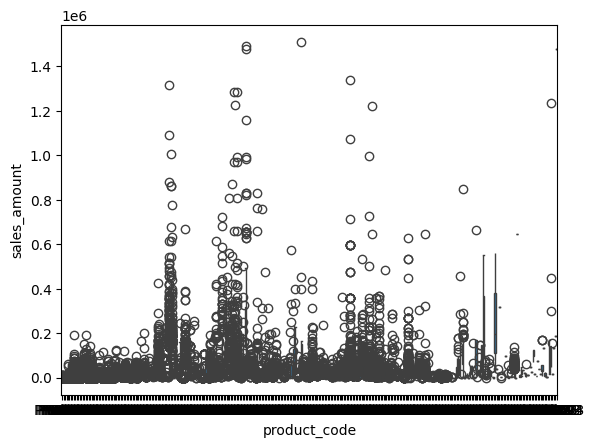

In [ ]:
import seaborn as sns
sns.boxplot(data=df, x='product_code', y='sales_amount')


In [ ]:
df.groupby('product_code')['sales_amount'].agg(['count', 'mean', 'sum']).sort_values('sum', ascending=False)


count           mean       sum
product_code                                
Prod318        3128   22048.338235  68967202
Prod316        1235   49298.341700  60883452
Prod324         652   63581.846626  41455364
Prod329         140  245582.007143  34381481
Prod334        3890    8089.716195  31468996
...             ...            ...       ...
Prod247           2      74.500000       149
Prod154           1     134.000000       134
Prod181           1     130.000000       130
Prod115           1     106.000000       106
Prod111           1      65.000000        65

[338 rows x 3 columns]

# 4. Data Preparation

In this section, I build some insights to create a dashboard.
I discovered that sales amount and cost price are not strongly correlated with profit, so I cannot use them for segmentation.
Then, I attempted to segment the data by negative versus positive profit, but I noticed that some data is not representative. Therefore, for the next section, I will implement a decision tree classifier to perform proper segmentation.

However, I drew some ideas from the positive vs. negative profit segmentation to help explain what a decision tree is to the non-technical team.

Additionally, I need to create a regression model to predict profit margin, so I can support better decision-making.


## Dashboard

## Usefull functions

In [ ]:
def percentage_of_losses_by_category(df=None, category_column=''):
    """
    Calculates the percentage of loss-making operations (negative profit_margin)
    for each category in the specified column.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing sales or transaction data, including a 'profit_margin' column.

    category_column : str
        The name of the column by which to group and calculate loss percentages (e.g., 'customer_type', 'product').

    Returns:
    --------
    pandas.Series
        A Series with the percentage of loss-making operations for each category,
        sorted in descending order.
    """
    df = df.copy()
    # Filter operations with negative profit margin (losses)
    neg_profit = df[df['profit_margin'] < 0]

    # Total operations per category (including profitable and unprofitable)
    total_by_category = df[category_column].value_counts()

    # Loss-making operations per category
    losses_by_category = neg_profit[category_column].value_counts()

    # Calculate percentage of loss-making operations per category
    loss_percentage = (losses_by_category / total_by_category * 100).sort_values(ascending=False)

    return loss_percentage


In [ ]:
def main_stats_by_cat(df, cat_col):
    """
    Computes the top 5 categories for each key performance metric.

    This function groups the data by a categorical column and calculates aggregate metrics
    including total sales, total profit, profit-to-revenue ratio, and contribution percentages.
    It then selects the top 5 categories for each metric and returns them in a side-by-side format.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing at least the specified category column, 'sales_amount', and 'profit_margin'.

    cat_col : str
        The name of the categorical column used for grouping (e.g., 'market').

    Returns:
    --------
    pandas.DataFrame
        A DataFrame with the top 5 categories for each metric, shown in pairs of category name and metric value.
    """

    # Group by category and sum sales and profits
    grouped = df.groupby(cat_col)[['sales_amount', 'profit_margin']].sum()

    # Compute derived performance metrics
    grouped['profit_revenue_ratio'] = grouped['profit_margin'] / grouped['sales_amount']
    grouped['profit_contribution'] = grouped['profit_margin'] / grouped['profit_margin'].sum()
    grouped['revenue_contribution'] = grouped['sales_amount'] / grouped['sales_amount'].sum()

    # Collect top 5 rows for each metric separately
    to_join = []
    for col in grouped.columns:
        top5 = grouped[col].nlargest(5)
        df_top5 = top5.reset_index()
        df_top5.columns = [f'{cat_col}_{col}', col]
        to_join.append(df_top5)

    # Concatenate results horizontally, aligning by rank position
    df_combined = pd.concat(to_join, axis=1)

    return df_combined


In [ ]:
def annual_aggregate_by_category(
    df=None,
    date_column='order_date',
    category_column='market_name',
    value_column='cost_price',
    agg_func='mean'
):
    """
    Calculates annual aggregation (e.g., mean, sum, count) of a numeric column, grouped by a category column.
    Does not require setting the date as index and handles repeated dates.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame containing at least a date column, a category column, and a numeric value column.

    date_column : str, default='order_date'
        The name of the column containing date values.

    category_column : str, default='market_name'
        The name of the column to group by (e.g., region, customer_type, product).

    value_column : str, default='cost_price'
        The numeric column to aggregate.

    agg_func : str or function, default='mean'
        The aggregation function to apply ('mean', 'sum', 'count', etc.). Can also be a callable.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame with the aggregated result per category and year.
        Columns: [category_column, year, aggregated_value]
    """
    # Ensure the date column is in datetime format
    df = df.copy()
    df[date_column] = pd.to_datetime(df[date_column])

    # Extract the year from the date column
    df['year'] = df[date_column].dt.year

    # Group by category and year, then apply the aggregation function
    result = (
        df.groupby([category_column, 'year'])[value_column]
          .agg(agg_func)
          .reset_index()
          .sort_values(by=[category_column, 'year'])
    ).round()

    return result


### Business Problem

<ipython-input-123-a54cc07f7600>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df.resample('M', on='order_date')['sales_amount'].sum().reset_index()


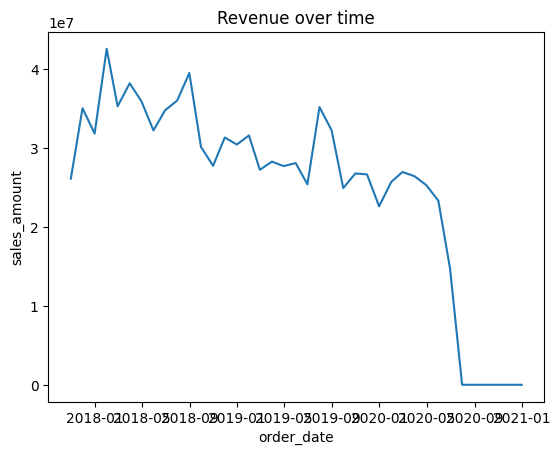

' Another problem statement '

In [ ]:
#Our Revenue over time has been decreasing
df_resampled = df.resample('M', on='order_date')['sales_amount'].sum().reset_index()

sns.lineplot(data=df_resampled, x='order_date', y='sales_amount')
plt.title('Revenue over time')
plt.show()
''' Another problem statement '''

<ipython-input-124-9d25c20e26d9>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df.resample('M', on='order_date')['profit_margin'].sum().reset_index()


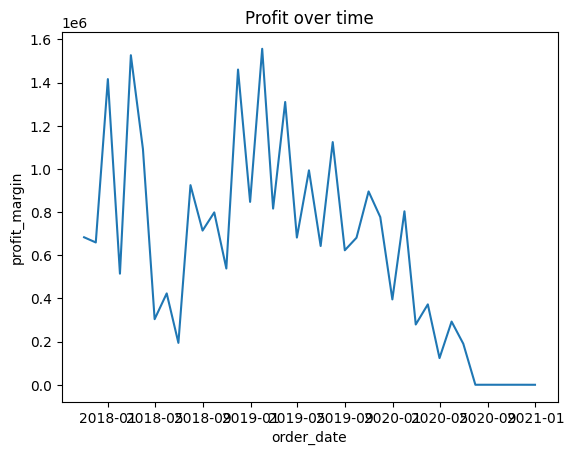

In [ ]:
#So our profit
df_resampled = df.resample('M', on='order_date')['profit_margin'].sum().reset_index()

sns.lineplot(data=df_resampled, x='order_date', y='profit_margin')
plt.title('Profit over time')
plt.show()

<ipython-input-24-143fbbc8238e>:29: FutureWarning: The provided callable <function sum at 0x7a8ba0bece00> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  revenue_by_month = df.groupby('order_month')[metric_col].agg(agg_func)


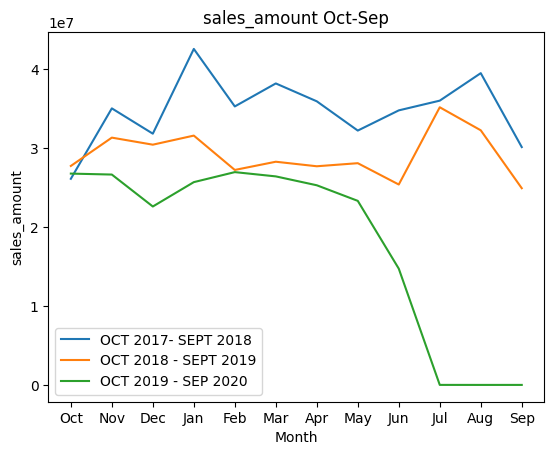

[   order_month  sales_amount month
 0   2019-10-01      26744955   Oct
 1   2019-11-01      26623725   Nov
 2   2019-12-01      22581846   Dec
 3   2020-01-01      25664596   Jan
 4   2020-02-01      26931944   Feb
 5   2020-03-01      26391041   Mar
 6   2020-04-01      25267920   Apr
 7   2020-05-01      23294778   May
 8   2020-06-01      14717345   Jun
 9   2020-07-01          8472   Jul
 10  2020-08-01          5375   Aug
 11  2020-09-01          6474   Sep,
    order_month  sales_amount month
 0   2018-10-01      27713450   Oct
 1   2018-11-01      31296202   Nov
 2   2018-12-01      30404126   Dec
 3   2019-01-01      31553402   Jan
 4   2019-02-01      27206009   Feb
 5   2019-03-01      28246165   Mar
 6   2019-04-01      27673431   Apr
 7   2019-05-01      28061536   May
 8   2019-06-01      25363748   Jun
 9   2019-07-01      35137734   Jul
 10  2019-08-01      32223583   Aug
 11  2019-09-01      24895945   Sep,
    order_month  sales_amount month
 0   2017-10-01      26087

In [ ]:
#We have less revenue over the years
metric_last_years(df=df,metric_col='sales_amount',date_col='order_date')

### Main business stats

In [ ]:
cat_cols

['product_code',
 'sales_qty',
 'customer_name',
 'customer_type',
 'markets_name',
 'zone',
 'customer_type']

In [ ]:
numerical

['sales_qty',
 'sales_amount',
 'profit_margin_percentage',
 'profit_margin',
 'cost_price']

#### The markets that generate the highest total profit or revenue are not necessarily the ones with the highest profit per unit of revenue. This suggests the presence of distinct market segments.

In [ ]:
markets_stats = main_stats_by_cat(df=df, cat_col='markets_name')
markets_stats

markets_name_sales_amount  sales_amount markets_name_profit_margin  \
0                 Delhi NCR     519534744                  Delhi NCR   
1                    Mumbai     150085133                     Mumbai   
2                 Ahmedabad     132307766                  Ahmedabad   
3                    Bhopal      58610045                     Bhopal   
4                    Nagpur      55376330                     Nagpur   

   profit_margin markets_name_profit_revenue_ratio  profit_revenue_ratio  \
0    11939783.71                             Surat              0.048614   
1     4872685.27                             Patna              0.041157   
2     2848293.37                      Bhubaneshwar              0.039823   
3     2287172.23                            Bhopal              0.039024   
4     1423320.74                             Kochi              0.037383   

  markets_name_profit_contribution  profit_contribution  \
0                        Delhi NCR             0.484286   
1                           Mumbai             0.197640   
2                        Ahmedabad             0.115529   
3                           Bhopal             0.092769   
4                           Nagpur             0.057731   

  markets_name_revenue_contribution  revenue_contribution  
0                         Delhi NCR              0.527347  
1                            Mumbai              0.152342  
2                         Ahmedabad              0.134297  
3                            Bhopal              0.059491  
4                            Nagpur              0.056209

#### We see the same pattern as in markets for profir revenue ratio

In [ ]:
product_stats = main_stats_by_cat(df=df, cat_col='product_code')
product_stats

product_code_sales_amount  sales_amount product_code_profit_margin  \
0                   Prod318      68967202                    Prod329   
1                   Prod316      60883452                    Prod318   
2                   Prod324      41455364                    Prod316   
3                   Prod329      34381481                    Prod040   
4                   Prod334      31468996                    Prod324   

   profit_margin product_code_profit_revenue_ratio  profit_revenue_ratio  \
0     1947587.05                           Prod001                  0.39   
1     1866343.37                           Prod037                  0.38   
2     1171377.79                           Prod111                  0.37   
3     1025736.71                           Prod153                  0.37   
4     1009946.10                           Prod151                  0.34   

  product_code_profit_contribution  profit_contribution  \
0                          Prod329             0.078996   
1                          Prod318             0.075700   
2                          Prod316             0.047512   
3                          Prod040             0.041605   
4                          Prod324             0.040964   

  product_code_revenue_contribution  revenue_contribution  
0                           Prod318              0.070004  
1                           Prod316              0.061799  
2                           Prod324              0.042079  
3                           Prod329              0.034898  
4                           Prod334              0.031942

#### The same for customer type, Brick and Mortat is top for all cat, except for profit revenue ratio

In [ ]:
customer_type_stats = main_stats_by_cat(df=df, cat_col='customer_type')
customer_type_stats

customer_type_sales_amount  sales_amount customer_type_profit_margin  \
0             Brick & Mortar     797159933              Brick & Mortar   
1                 E-Commerce     188025195                  E-Commerce   

   profit_margin customer_type_profit_revenue_ratio  profit_revenue_ratio  \
0    18216904.96                         E-Commerce              0.034237   
1     6437482.00                     Brick & Mortar              0.022852   

  customer_type_profit_contribution  profit_contribution  \
0                    Brick & Mortar             0.738891   
1                        E-Commerce             0.261109   

  customer_type_revenue_contribution  revenue_contribution  
0                     Brick & Mortar              0.809147  
1                         E-Commerce              0.190853

#### Same pattern for customer_name

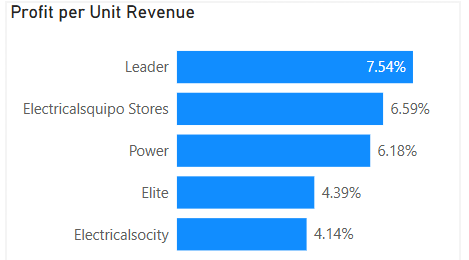

In [ ]:
customer_name_stats = main_stats_by_cat(df=df, cat_col='customer_name')
customer_name_stats



customer_name_sales_amount  sales_amount customer_name_profit_margin  \
0      Electricalsara Stores     439635137       Electricalsara Stores   
1         Electricalslytical      76675031                       Nixon   
2               Excel Stores      75799367          Electricalslytical   
3             Premium Stores      72147578              Premium Stores   
4                      Nixon      70581066                Excel Stores   

   profit_margin customer_name_profit_revenue_ratio  profit_revenue_ratio  \
0    10155152.81              Electricalsbea Stores              0.054479   
1     2708222.83            Electricalsquipo Stores              0.052549   
2     2211416.34                               Sage              0.044404   
3     1765996.79                         Expression              0.042384   
4     1553576.24                              Power              0.039427   

  customer_name_profit_contribution  profit_contribution  \
0             Electricalsara Stores             0.411900   
1                             Nixon             0.109848   
2                Electricalslytical             0.089697   
3                    Premium Stores             0.071630   
4                      Excel Stores             0.063014   

  customer_name_revenue_contribution  revenue_contribution  
0              Electricalsara Stores              0.446246  
1                 Electricalslytical              0.077828  
2                       Excel Stores              0.076939  
3                     Premium Stores              0.073233  
4                              Nixon              0.071642

#### Zone

In [ ]:
zone_stats = main_stats_by_cat(df=df, cat_col='zone')
zone_stats

zone_sales_amount  sales_amount zone_profit_margin  profit_margin  \
0             North     675553315              North    15062297.67   
1           Central     264071508            Central     8583178.24   
2             South      45560305              South     1008911.05   

  zone_profit_revenue_ratio  profit_revenue_ratio zone_profit_contribution  \
0                   Central              0.032503                    North   
1                     North              0.022296                  Central   
2                     South              0.022145                    South   

   profit_contribution zone_revenue_contribution  revenue_contribution  
0             0.610938                     North              0.685712  
1             0.348140                   Central              0.268043  
2             0.040922                     South              0.046245

#### Each of our top 5 products accounts for 2% of total sales. We currently offer 338 products in total

In [ ]:
print(len(df['product_code'].unique()))
freq_prod = df['product_code'].value_counts(ascending=False, normalize=True) * 100
freq_prod

338


product_code
Prod065    2.559138
Prod334    2.518990
Prod053    2.467833
Prod295    2.351920
Prod294    2.206220
             ...   
Prod173    0.000648
Prod200    0.000648
Prod028    0.000648
Prod144    0.000648
Prod073    0.000648
Name: proportion, Length: 338, dtype: float64

#### We have 38 customers, here are most frequent

In [ ]:

print(len(df['customer_name'].unique()))
freq_prod = df['customer_name'].value_counts(ascending=False, normalize=True) * 100
freq_prod.head()



38


customer_name
Premium Stores           12.464142
Electricalsara Stores    10.329800
Excel Stores              7.040867
Nixon                     6.906823
Surge Stores              5.501629
Name: proportion, dtype: float64

### Where are our top customers? * Come back to this map

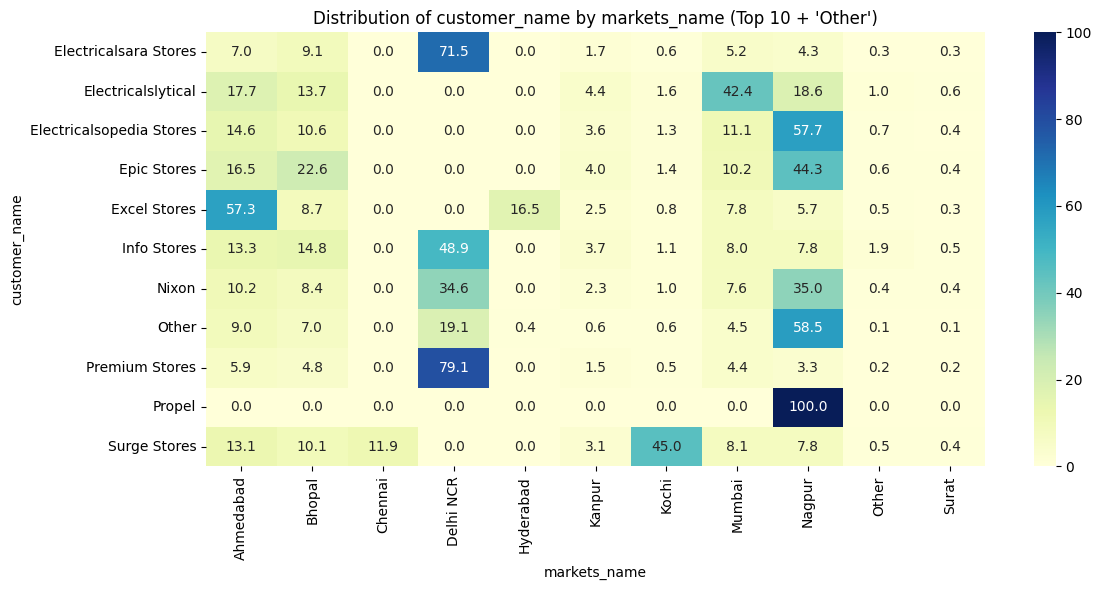

In [ ]:
plot_distribution_heatmap(df=df,row_col='customer_name',col_col='markets_name')



#### Revenue over the years

In [ ]:
print('Total revenue')
print(df['sales_amount'].sum())
df.resample('YE', on='order_date')['sales_amount'].sum().reset_index()

Total revenue
985185128


order_date  sales_amount
0 2017-12-31      92881903
1 2018-12-31     413687163
2 2019-12-31     336312079
3 2020-12-31     142303983

In [ ]:
print('AVG revenue')
print(df['sales_amount'].median())
df.resample('YE', on='order_date')['sales_amount'].median().reset_index()

AVG revenue
468.0


order_date  sales_amount
0 2017-12-31         500.0
1 2018-12-31         472.0
2 2019-12-31         463.0
3 2020-12-31         449.0

#### Sales qty over the years

In [ ]:
print('Total qty')
print(df['sales_qty'].sum())
df.resample('YE', on='order_date')['sales_qty'].sum().reset_index()



Total qty
2435221


order_date  sales_qty
0 2017-12-31     234367
1 2018-12-31     997497
2 2019-12-31     851076
3 2020-12-31     352281

In [ ]:
print('AVG qty')
print(df['sales_qty'].mean())
df.resample('YE', on='order_date')['sales_qty'].mean().reset_index()

AVG qty
15.769399133571202


order_date  sales_qty
0 2017-12-31  16.102164
1 2018-12-31  16.418352
2 2019-12-31  15.278269
3 2020-12-31  15.047027

#### Profit margin

In [ ]:
print('Total profit_margin')
print(df['profit_margin'].sum())
df.resample('YE', on='order_date')['profit_margin'].sum().reset_index()

Total profit_margin
24654386.959999997


order_date  profit_margin
0 2017-12-31     2758255.53
1 2018-12-31     9337296.15
2 2019-12-31    10495721.85
3 2020-12-31     2063113.43

In [ ]:
print('AVG profit_margin')
print(df['profit_margin'].mean())
df.resample('YE', on='order_date')['profit_margin'].mean().reset_index()

AVG profit_margin
159.6507538189565


order_date  profit_margin
0 2017-12-31     189.505705
1 2018-12-31     153.687699
2 2019-12-31     188.416154
3 2020-12-31      88.122050

#### Cost price

In [ ]:
print('Total cost_price')
print(df['cost_price'].sum())
df.resample('YE', on='order_date')['cost_price'].sum().reset_index()

Total cost_price
960530741.0400001


order_date    cost_price
0 2017-12-31  9.012365e+07
1 2018-12-31  4.043499e+08
2 2019-12-31  3.258164e+08
3 2020-12-31  1.402409e+08

In [ ]:
print('AVG cost_price')
print(df['cost_price'].mean())
df.resample('YE', on='order_date')['cost_price'].mean().reset_index()



AVG cost_price
6219.966333866488


order_date   cost_price
0 2017-12-31  6191.937305
1 2018-12-31  6655.417115
2 2019-12-31  5848.960724
3 2020-12-31  5990.127694

#### Most of our opperations are under Brick and Mortar Cat

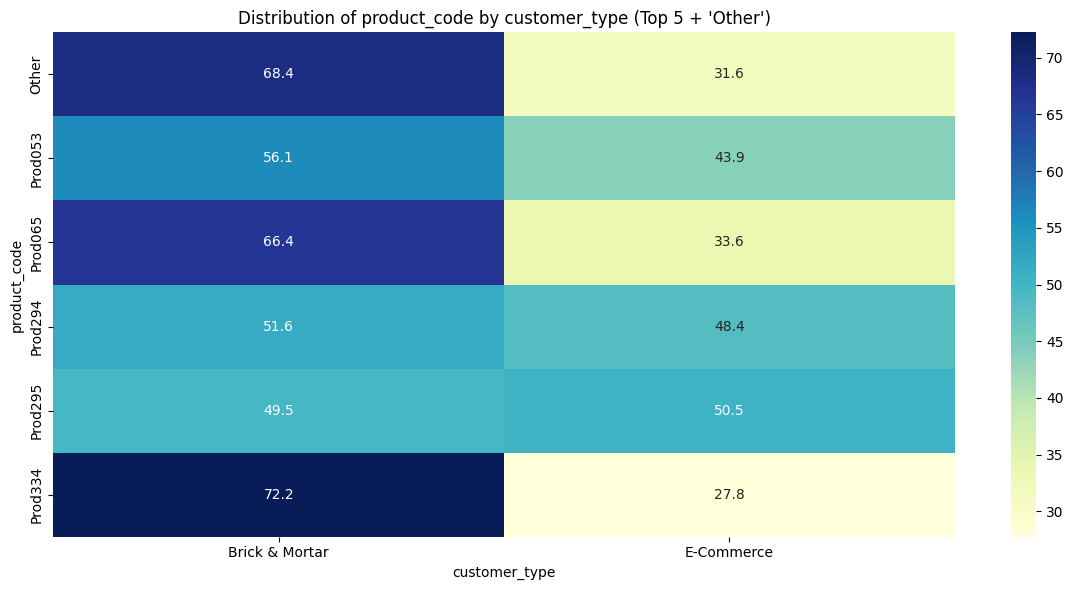

In [ ]:
plot_distribution_heatmap(df=df,
                               row_col='product_code',
                               col_col='customer_type',
                               top_n=5)

#### Our most frequent clients are under brick and mortat cat

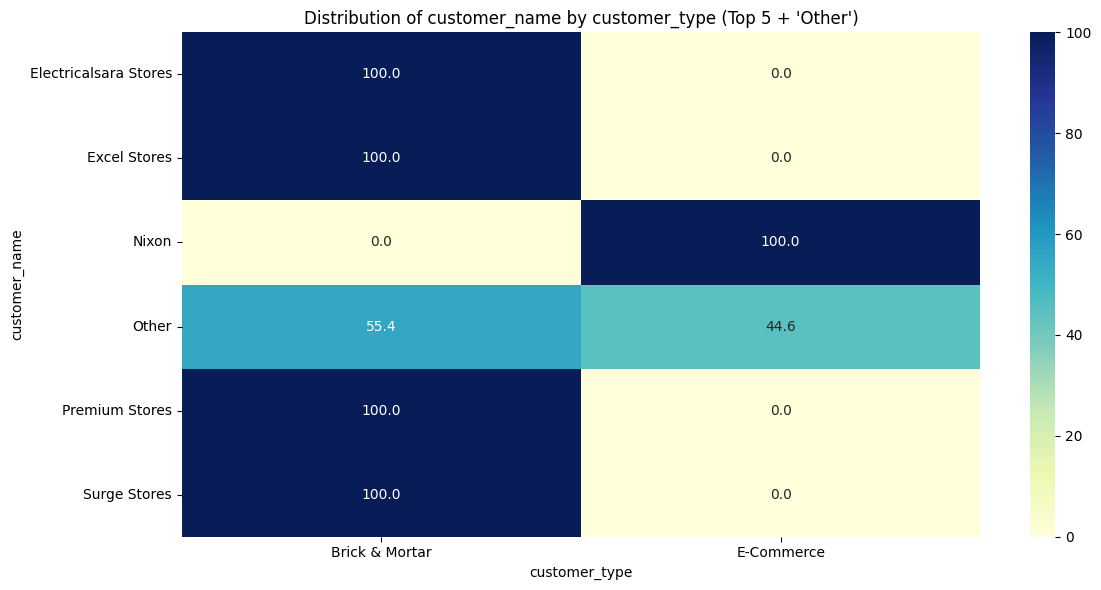

In [ ]:
plot_distribution_heatmap(df=df,
                               row_col='customer_name',
                               col_col='customer_type',
                               top_n=5)



#### How many neg profit trasactions we've done?

In [ ]:
percentage_of_losses_by_category(df=df, category_column='customer_type')

customer_type
Brick & Mortar    46.197132
E-Commerce        45.916062
Name: count, dtype: float64

In [ ]:
percentage_of_losses_by_category(df=df, category_column='markets_name').head(10)

markets_name
Bengaluru       50.000000
Lucknow         48.076923
Bhubaneshwar    46.428571
Delhi NCR       46.427055
Mumbai          46.341248
Kanpur          46.282462
Chennai         46.011673
Bhopal          45.992796
Nagpur          45.974827
Ahmedabad       45.889044
Name: count, dtype: float64

#### Income over the years by market

In [ ]:
income_market = annual_aggregate_by_category(
    df,
    date_column='order_date',
    category_column='markets_name',
    value_column='sales_amount',
    agg_func='sum'
)
temp_mask = markets_stats['markets_name_sales_amount'].values
top5_income_market = income_market[income_market['markets_name'].isin(temp_mask)]

<Axes: xlabel='year', ylabel='sales_amount'>

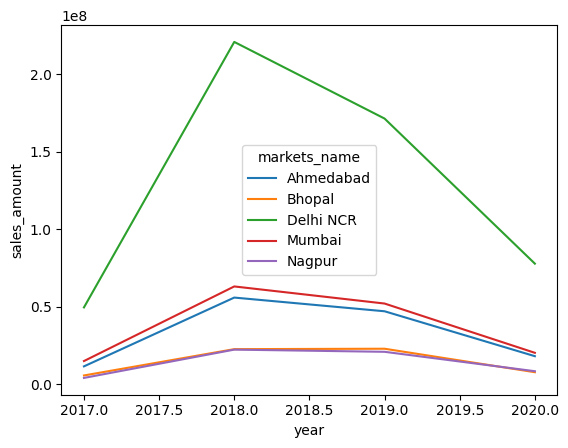

In [ ]:

sns.lineplot(data=top5_income_market, x='year',y='sales_amount',hue='markets_name')

<Axes: xlabel='year', ylabel='profit_margin'>

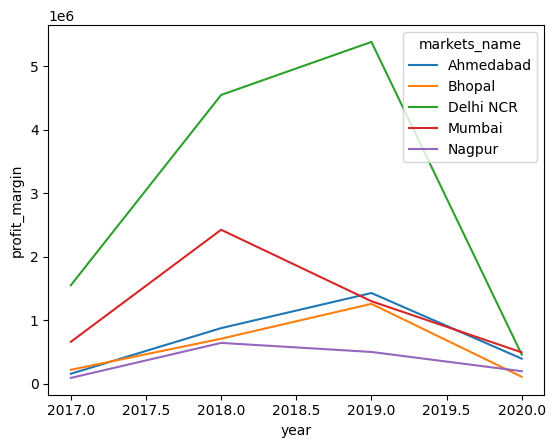

In [ ]:
income_market = annual_aggregate_by_category(
    df,
    date_column='order_date',
    category_column='markets_name',
    value_column='profit_margin',
    agg_func='sum'
)
temp_mask = markets_stats['markets_name_profit_margin'].values
top5_income_market = income_market[income_market['markets_name'].isin(temp_mask)]
sns.lineplot(data=top5_income_market, x='year',y='profit_margin',hue='markets_name')

<Axes: xlabel='year', ylabel='profit_margin'>

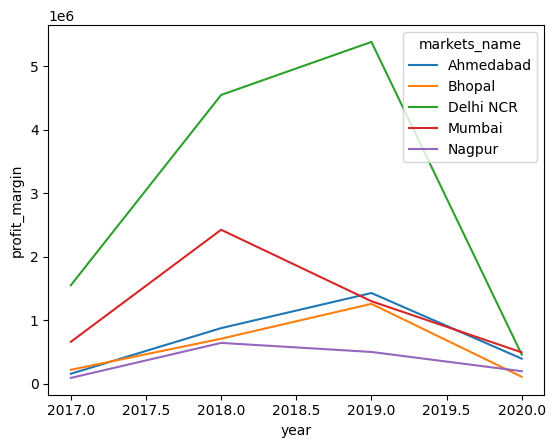

In [ ]:
income_market = annual_aggregate_by_category(
    df,
    date_column='order_date',
    category_column='markets_name',
    value_column='profit_margin',
    agg_func='sum'
)
temp_mask = markets_stats['markets_name_profit_margin'].values
top5_income_market = income_market[income_market['markets_name'].isin(temp_mask)]
sns.lineplot(data=top5_income_market, x='year',y='profit_margin',hue='markets_name')

In [ ]:
df.head()

product_code market_code order_date  sales_qty  sales_amount currency  \
0      Prod279     Mark011 2017-10-11          1           102      INR   
1      Prod279     Mark011 2017-10-18          1           102      INR   
2      Prod279     Mark011 2017-10-19          1           102      INR   
3      Prod279     Mark011 2017-11-08          1           102      INR   
4      Prod279     Mark011 2018-03-09          1           102      INR   

   profit_margin_percentage  profit_margin  cost_price customer_code  year  \
0                      0.39          39.78       62.22        Cus020  2017   
1                     -0.12         -12.24      114.24        Cus020  2017   
2                      0.29          29.58       72.42        Cus020  2017   
3                      0.36          36.72       65.28        Cus020  2017   
4                     -0.35         -35.70      137.70        Cus033  2018   

   transaction_count  is_weekend customer_name customer_type  product_type  \
0                  1       False         Nixon    E-Commerce  Distribution   
1                  1       False         Nixon    E-Commerce  Distribution   
2                  1       False         Nixon    E-Commerce  Distribution   
3                  1       False         Nixon    E-Commerce  Distribution   
4                  1       False       All-Out    E-Commerce  Distribution   

  markets_code markets_name     zone  
0      Mark011       Nagpur  Central  
1      Mark011       Nagpur  Central  
2      Mark011       Nagpur  Central  
3      Mark011       Nagpur  Central  
4      Mark011       Nagpur  Central

## Segmentation

<Axes: xlabel='cost_price', ylabel='sales_amount'>

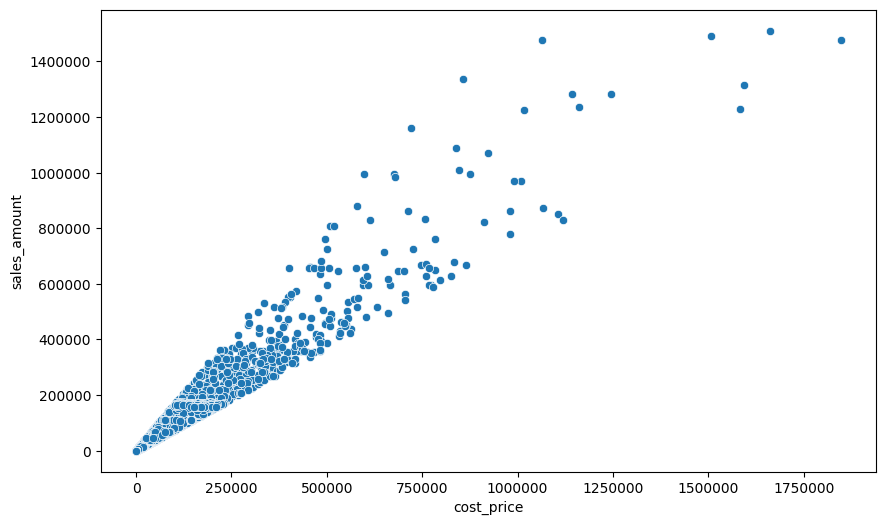

In [ ]:
plt.figure(figsize=(10,6))

plt.ticklabel_format(style='plain', axis='both', useOffset=False)
sns.scatterplot(data=df, x='cost_price',y='sales_amount')


<Figure size 1000x600 with 0 Axes>

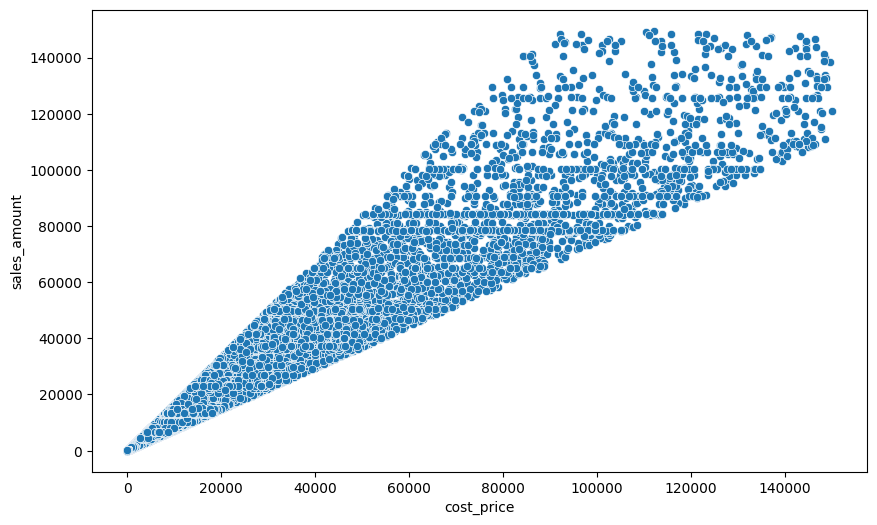

<Figure size 1000x600 with 0 Axes>

In [ ]:
#Most of our sales are on this area
plt.figure(figsize=(10,6))
temp = df[(df['cost_price']<150000)& (df['sales_amount']<150000)]
plt.ticklabel_format(style='plain', axis='both', useOffset=False)
sns.scatterplot(data=temp, x='cost_price',y='sales_amount')
# IS 5: I have two types of data to compare with profit
# Where we have most of our data and
# Where we have 'outliers'

plt.figure(figsize=(10,6))

In [ ]:
df['cost_price'].mean(), df['sales_amount'].mean()

(np.float64(6219.966333866488), np.float64(6379.617087685444))

In [ ]:
# Creating seg
cond = (df['cost_price']<500000)& (df['sales_amount']<400000)
df['group'] = np.where(cond, 'Most', 'Extreme')
df['group'].value_counts(normalize=True) * 100


group
Most       99.914523
Extreme     0.085477
Name: proportion, dtype: float64

### Comparison sales amount vs cost

In [ ]:
most_data = df[df['group']== 'Most']
most_data

product_code market_code order_date  sales_qty  sales_amount currency  \
0           Prod279     Mark011 2017-10-11          1           102      INR   
1           Prod279     Mark011 2017-10-18          1           102      INR   
2           Prod279     Mark011 2017-10-19          1           102      INR   
3           Prod279     Mark011 2017-11-08          1           102      INR   
4           Prod279     Mark011 2018-03-09          1           102      INR   
...             ...         ...        ...        ...           ...      ...   
154424      Prod280     Mark011 2020-01-09          1            28      INR   
154425      Prod281     Mark011 2020-01-09          1            28      INR   
154426      Prod280     Mark011 2020-02-08          1            28      INR   
154427      Prod281     Mark011 2020-03-08          1            28      INR   
154428      Prod300     Mark011 2020-03-08          1            42      INR   

        profit_margin_percentage  profit_margin  cost_price customer_code  \
0                           0.39          39.78       62.22        Cus020   
1                          -0.12         -12.24      114.24        Cus020   
2                           0.29          29.58       72.42        Cus020   
3                           0.36          36.72       65.28        Cus020   
4                          -0.35         -35.70      137.70        Cus033   
...                          ...            ...         ...           ...   
154424                     -0.19          -5.32       33.32        Cus037   
154425                      0.19           5.32       22.68        Cus037   
154426                      0.07           1.96       26.04        Cus037   
154427                      0.14           3.92       24.08        Cus037   
154428                     -0.21          -8.82       50.82        Cus037   

        year  transaction_count  is_weekend customer_name customer_type  \
0       2017                  1       False         Nixon    E-Commerce   
1       2017                  1       False         Nixon    E-Commerce   
2       2017                  1       False         Nixon    E-Commerce   
3       2017                  1       False         Nixon    E-Commerce   
4       2018                  1       False       All-Out    E-Commerce   
...      ...                ...         ...           ...           ...   
154424  2020                  1       False        Propel    E-Commerce   
154425  2020                  1       False        Propel    E-Commerce   
154426  2020                  1        True        Propel    E-Commerce   
154427  2020                  1        True        Propel    E-Commerce   
154428  2020                  1        True        Propel    E-Commerce   

        product_type markets_code markets_name     zone group  
0       Distribution      Mark011       Nagpur  Central  Most  
1       Distribution      Mark011       Nagpur  Central  Most  
2       Distribution      Mark011       Nagpur  Central  Most  
3       Distribution      Mark011       Nagpur  Central  Most  
4       Distribution      Mark011       Nagpur  Central  Most  
...              ...          ...          ...      ...   ...  
154424         Other      Mark011       Nagpur  Central  Most  
154425         Other      Mark011       Nagpur  Central  Most  
154426         Other      Mark011       Nagpur  Central  Most  
154427         Other      Mark011       Nagpur  Central  Most  
154428         Other      Mark011       Nagpur  Central  Most  

[154295 rows x 20 columns]

In [ ]:
extreme_data = df[df['group']== 'Extreme']
extreme_data

product_code market_code order_date  sales_qty  sales_amount currency  \
99900       Prod318     Mark013 2017-12-14        960        714667      INR   
99903       Prod318     Mark013 2018-01-29       1440       1072000      INR   
99904       Prod318     Mark013 2018-02-23       1798       1338264      INR   
99907       Prod318     Mark013 2018-03-16        800        595556      INR   
99911       Prod318     Mark013 2018-04-19        800        595556      INR   
...             ...         ...        ...        ...           ...      ...   
143943      Prod316     Mark004 2019-03-01        240        421375      INR   
143947      Prod316     Mark004 2019-03-21        323        457190      INR   
143985      Prod316     Mark004 2019-10-09        240        421375      INR   
144015      Prod316     Mark004 2020-04-09        320        516875      INR   
144022      Prod316     Mark004 2020-05-08        320        516875      INR   

        profit_margin_percentage  profit_margin  cost_price customer_code  \
99900                       0.09       64320.03   650346.97        Cus006   
99903                       0.14      150080.00   921920.00        Cus020   
99904                       0.36      481775.04   856488.96        Cus024   
99907                       0.00           0.00   595556.00        Cus022   
99911                      -0.30     -178666.80   774222.80        Cus017   
...                          ...            ...         ...           ...   
143943                     -0.27     -113771.25   535146.25        Cus006   
143947                      0.35      160016.50   297173.50        Cus006   
143985                      0.00           0.00   421375.00        Cus006   
144015                     -0.12      -62025.00   578900.00        Cus006   
144022                     -0.22     -113712.50   630587.50        Cus006   

        year  transaction_count  is_weekend          customer_name  \
99900   2017                  1       False  Electricalsara Stores   
99903   2018                  1       False                  Nixon   
99904   2018                  1       False                  Power   
99907   2018                  1       False     Electricalslytical   
99911   2018                  1       False            Epic Stores   
...      ...                ...         ...                    ...   
143943  2019                  1       False  Electricalsara Stores   
143947  2019                  1       False  Electricalsara Stores   
143985  2019                  1       False  Electricalsara Stores   
144015  2020                  1       False  Electricalsara Stores   
144022  2020                  1       False  Electricalsara Stores   

         customer_type product_type markets_code markets_name     zone  \
99900   Brick & Mortar        Other      Mark013       Bhopal  Central   
99903       E-Commerce        Other      Mark013       Bhopal  Central   
99904       E-Commerce        Other      Mark013       Bhopal  Central   
99907       E-Commerce        Other      Mark013       Bhopal  Central   
99911   Brick & Mortar        Other      Mark013       Bhopal  Central   
...                ...          ...          ...          ...      ...   
143943  Brick & Mortar        Other      Mark004    Delhi NCR    North   
143947  Brick & Mortar        Other      Mark004    Delhi NCR    North   
143985  Brick & Mortar        Other      Mark004    Delhi NCR    North   
144015  Brick & Mortar        Other      Mark004    Delhi NCR    North   
144022  Brick & Mortar        Other      Mark004    Delhi NCR    North   

          group  
99900   Extreme  
99903   Extreme  
99904   Extreme  
99907   Extreme  
99911   Extreme  
...         ...  
143943  Extreme  
143947  Extreme  
143985  Extreme  
144015  Extreme  
144022  Extreme  

[132 rows x 20 columns]

In [ ]:
markets_most = main_stats_by_cat(df=most_data, cat_col='markets_name')
markets_most

markets_name_sales_amount  sales_amount markets_name_profit_margin  \
0                 Delhi NCR     449356072                  Delhi NCR   
1                    Mumbai     143936516                     Mumbai   
2                 Ahmedabad     130763613                  Ahmedabad   
3                    Nagpur      55376330                     Bhopal   
4                    Bhopal      48782102                     Nagpur   

   profit_margin markets_name_profit_revenue_ratio  profit_revenue_ratio  \
0    10162511.19                             Surat              0.048614   
1     3671675.32                             Kochi              0.045935   
2     3050701.37                             Patna              0.041157   
3     1607589.74                      Bhubaneshwar              0.039823   
4     1423320.74                            Bhopal              0.032954   

  markets_name_profit_contribution  profit_contribution  \
0                        Delhi NCR             0.475051   
1                           Mumbai             0.171634   
2                        Ahmedabad             0.142606   
3                           Bhopal             0.075148   
4                           Nagpur             0.066534   

  markets_name_revenue_contribution  revenue_contribution  
0                         Delhi NCR              0.501263  
1                            Mumbai              0.160563  
2                         Ahmedabad              0.145869  
3                            Nagpur              0.061773  
4                            Bhopal              0.054417

#### The expensive data is not what bring us the biggest profit

#### I have to inspect Surat market

In [ ]:
markets_extreme = main_stats_by_cat(df=extreme_data, cat_col='markets_name')
markets_extreme

markets_name_sales_amount  sales_amount markets_name_profit_margin  \
0                 Delhi NCR      70178672                  Delhi NCR   
1                    Bhopal       9827943                     Mumbai   
2                    Mumbai       6148617                     Bhopal   
3                 Ahmedabad       1544153                     Kanpur   
4                     Kochi        628657                      Kochi   

   profit_margin markets_name_profit_revenue_ratio  profit_revenue_ratio  \
0     1777272.52                            Mumbai              0.195330   
1     1201009.95                            Bhopal              0.069148   
2      679582.49                         Delhi NCR              0.025325   
3      -61500.00                         Ahmedabad             -0.131080   
4     -132017.97                            Kanpur             -0.150000   

  markets_name_profit_contribution  profit_contribution  \
0                        Delhi NCR             0.544852   
1                           Mumbai             0.368189   
2                           Bhopal             0.208337   
3                           Kanpur            -0.018854   
4                            Kochi            -0.040472   

  markets_name_revenue_contribution  revenue_contribution  
0                         Delhi NCR              0.790852  
1                            Bhopal              0.110752  
2                            Mumbai              0.069290  
3                         Ahmedabad              0.017401  
4                             Kochi              0.007084

In [ ]:
((extreme_data['profit_margin_percentage'] < 0).sum() / len(extreme_data)) * 100

np.float64(49.24242424242424)

In [ ]:
((most_data['profit_margin_percentage'] < 0).sum() / len(most_data)) * 100

np.float64(46.10259567711202)

In [ ]:
most_data['profit_margin'].sum(), extreme_data['profit_margin'].sum()

(np.float64(21392447.97), np.float64(3261938.99))

### Comparison sales amount vs profit margin

<Axes: xlabel='sales_amount', ylabel='profit_margin'>

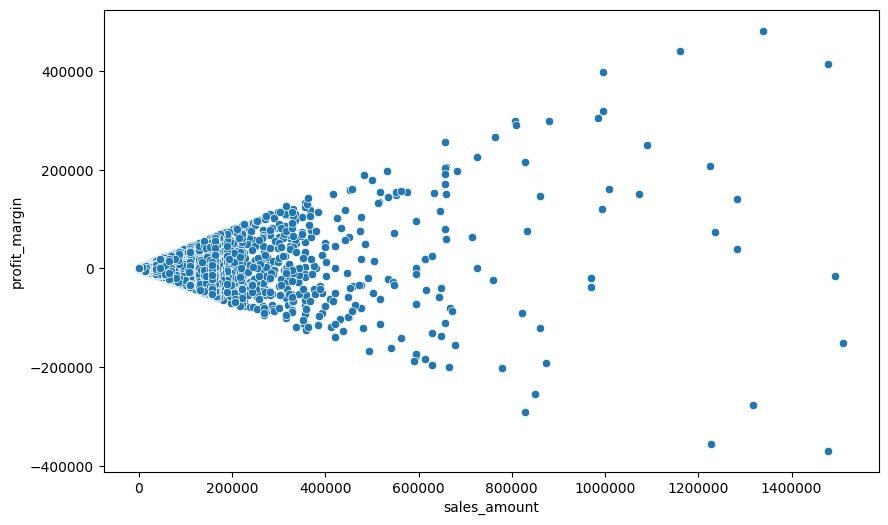

In [ ]:
plt.figure(figsize=(10,6))

plt.ticklabel_format(style='plain', axis='both', useOffset=False)
sns.scatterplot(data=df, y='profit_margin',x='sales_amount')

In [ ]:
cond = df['profit_margin'] <= 0
df['neg_pos_profit'] = np.where(cond, 'Neg', 'Pos')
df['neg_pos_profit'].value_counts(normalize=True)

neg_pos_profit
Pos    0.5254
Neg    0.4746
Name: proportion, dtype: float64

<Axes: xlabel='cost_price', ylabel='sales_amount'>

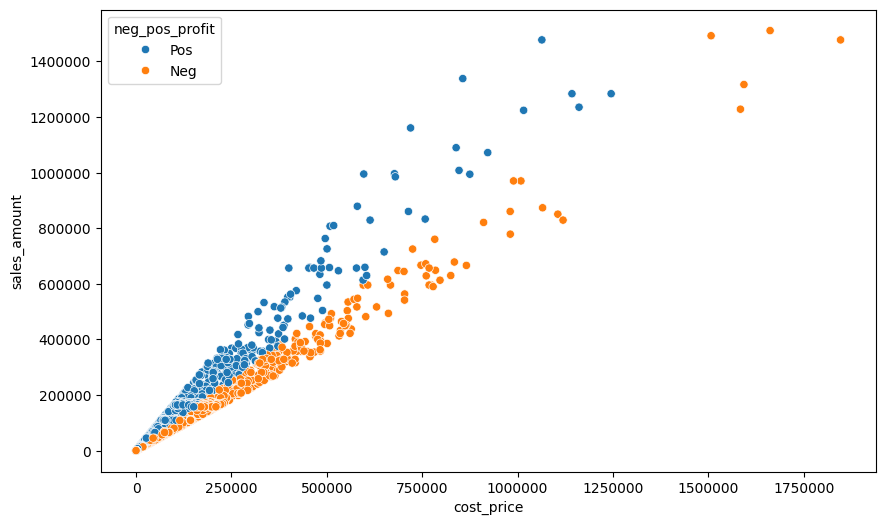

In [ ]:
plt.figure(figsize=(10,6))
plt.ticklabel_format(style='plain', axis='both', useOffset=False)
sns.scatterplot(data=df, x='cost_price',y='sales_amount',hue='neg_pos_profit')

In [ ]:
neg = df[df['neg_pos_profit']=='Neg']
neg.head(2)

product_code market_code order_date  sales_qty  sales_amount currency  \
1      Prod279     Mark011 2017-10-18          1           102      INR   
4      Prod279     Mark011 2018-03-09          1           102      INR   

   profit_margin_percentage  profit_margin  cost_price customer_code  ...  \
1                     -0.12         -12.24      114.24        Cus020  ...   
4                     -0.35         -35.70      137.70        Cus033  ...   

   transaction_count  is_weekend  customer_name customer_type  product_type  \
1                  1       False          Nixon    E-Commerce  Distribution   
4                  1       False        All-Out    E-Commerce  Distribution   

  markets_code markets_name     zone group neg_pos_profit  
1      Mark011       Nagpur  Central  Most            Neg  
4      Mark011       Nagpur  Central  Most            Neg  

[2 rows x 21 columns]

In [ ]:
pos = df[df['neg_pos_profit']=='Pos']
pos.head(2)

product_code market_code order_date  sales_qty  sales_amount currency  \
0      Prod279     Mark011 2017-10-11          1           102      INR   
2      Prod279     Mark011 2017-10-19          1           102      INR   

   profit_margin_percentage  profit_margin  cost_price customer_code  ...  \
0                      0.39          39.78       62.22        Cus020  ...   
2                      0.29          29.58       72.42        Cus020  ...   

   transaction_count  is_weekend  customer_name customer_type  product_type  \
0                  1       False          Nixon    E-Commerce  Distribution   
2                  1       False          Nixon    E-Commerce  Distribution   

  markets_code markets_name     zone group neg_pos_profit  
0      Mark011       Nagpur  Central  Most            Pos  
2      Mark011       Nagpur  Central  Most            Pos  

[2 rows x 21 columns]

#### Fortunatlely the markets where we have pos postive margin are the markets where we have the biggest sales amounts

In [ ]:
markets_pos = main_stats_by_cat(df=pos, cat_col='markets_name')
markets_pos

markets_name_sales_amount  sales_amount markets_name_profit_margin  \
0                 Delhi NCR     262517088                  Delhi NCR   
1                    Mumbai      81195107                     Mumbai   
2                 Ahmedabad      69173499                  Ahmedabad   
3                    Bhopal      32017233                     Bhopal   
4                    Nagpur      29250937                     Nagpur   

   profit_margin markets_name_profit_revenue_ratio  profit_revenue_ratio  \
0    55803753.46                         Bengaluru              0.279199   
1    16761757.89                             Patna              0.221981   
2    13693526.33                         Delhi NCR              0.212572   
3     6542961.44                             Kochi              0.207859   
4     5931837.71                            Mumbai              0.206438   

  markets_name_profit_contribution  profit_contribution  \
0                        Delhi NCR             0.526371   
1                           Mumbai             0.158106   
2                        Ahmedabad             0.129165   
3                           Bhopal             0.061717   
4                           Nagpur             0.055952   

  markets_name_revenue_contribution  revenue_contribution  
0                         Delhi NCR              0.513911  
1                            Mumbai              0.158950  
2                         Ahmedabad              0.135416  
3                            Bhopal              0.062678  
4                            Nagpur              0.057262

#### Neg profit markets: 'Bhubaneshwar', 'Bengaluru', 'Surat', 'Lucknow', 'Patna'

In [ ]:
markets_neg = main_stats_by_cat(df=neg, cat_col='markets_name')
markets_neg

markets_name_sales_amount  sales_amount markets_name_profit_margin  \
0                 Delhi NCR     257017656               Bhubaneshwar   
1                    Mumbai      68890026                  Bengaluru   
2                 Ahmedabad      63134267                      Surat   
3                    Bhopal      26592812                    Lucknow   
4                    Nagpur      26125393                      Patna   

   profit_margin markets_name_profit_revenue_ratio  profit_revenue_ratio  \
0      -58865.80                      Bhubaneshwar             -0.142987   
1      -93244.92                            Bhopal             -0.160035   
2     -188112.87                         Hyderabad             -0.169235   
3     -284712.57                         Delhi NCR             -0.170665   
4     -371110.28                         Ahmedabad             -0.171780   

  markets_name_profit_contribution  profit_contribution  \
0                        Delhi NCR             0.539124   
1                           Mumbai             0.146126   
2                        Ahmedabad             0.133297   
3                           Nagpur             0.055413   
4                           Bhopal             0.052307   

  markets_name_revenue_contribution  revenue_contribution  
0                         Delhi NCR              0.541817  
1                            Mumbai              0.145226  
2                         Ahmedabad              0.133093  
3                            Bhopal              0.056060  
4                            Nagpur              0.055075

<ipython-input-171-d243c09875b7>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = neg.resample('M', on='order_date')['profit_margin'].sum().reset_index()


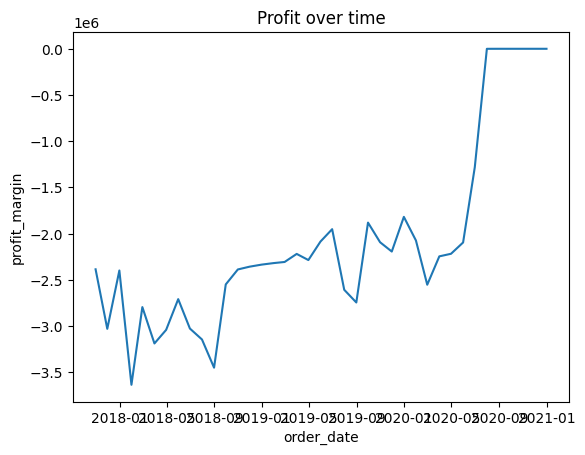

' Another problem statement '

In [ ]:
#Our Revenue over time has been decreasing

# Resample para sumar las ventas por día (puedes cambiar 'D' por 'M' para por mes, por ejemplo)
df_resampled = neg.resample('M', on='order_date')['profit_margin'].sum().reset_index()

# Graficar
sns.lineplot(data=df_resampled, x='order_date', y='profit_margin')
plt.title('Profit over time')
plt.show()
''' Another problem statement '''

#### Second solution: Increase volume for the sales with pos profit

<ipython-input-172-7dd8d48566d7>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = pos.resample('M', on='order_date')['profit_margin'].sum().reset_index()


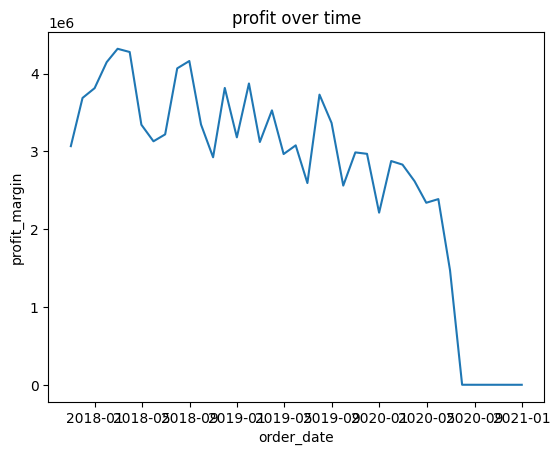

' Another problem statement '

In [ ]:
#Our Revenue over time has been decreasing

df_resampled = pos.resample('M', on='order_date')['profit_margin'].sum().reset_index()


sns.lineplot(data=df_resampled, x='order_date', y='profit_margin')
plt.title('profit over time')
plt.show()
''' Another problem statement '''

<ipython-input-173-0e2872b83ace>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = pos.resample('M', on='order_date')['sales_amount'].sum().reset_index()


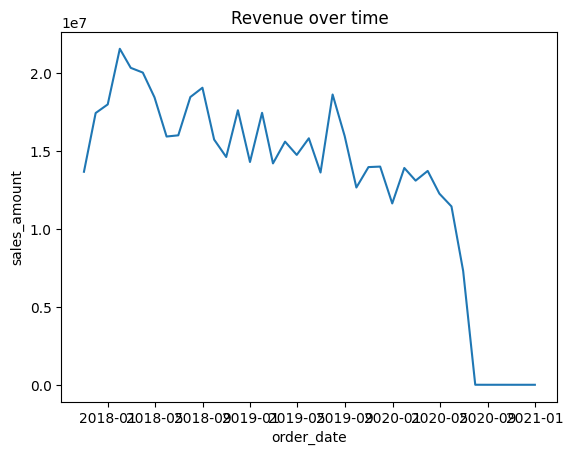

' Another problem statement '

In [ ]:
#Our Revenue over time has been decreasing


df_resampled = pos.resample('M', on='order_date')['sales_amount'].sum().reset_index()

sns.lineplot(data=df_resampled, x='order_date', y='sales_amount')
plt.title('Revenue over time')
plt.show()
''' Another problem statement '''

### Stats for neg profit margin vs pos profit margin CHECKING IF REPRESENTATIVE

#### Neg products_ 247, 181, 69, 217, 222 BUT NOT REPRESENTATIVE

In [ ]:
product_stats = main_stats_by_cat(df=neg, cat_col='product_code')
product_stats

product_code_sales_amount  sales_amount product_code_profit_margin  \
0                   Prod318      32452237                    Prod247   
1                   Prod316      31202981                    Prod181   
2                   Prod324      20018065                    Prod069   
3                   Prod329      16936854                    Prod217   
4                   Prod332      15022165                    Prod222   

   profit_margin product_code_profit_revenue_ratio  profit_revenue_ratio  \
0           0.00                           Prod247                  0.00   
1          -5.20                           Prod015                 -0.01   
2          -6.39                           Prod183                 -0.01   
3          -6.62                           Prod217                 -0.01   
4         -11.82                           Prod069                 -0.03   

  product_code_profit_contribution  profit_contribution  \
0                          Prod316             0.068020   
1                          Prod318             0.065724   
2                          Prod324             0.044589   
3                          Prod329             0.032275   
4                          Prod334             0.031532   

  product_code_revenue_contribution  revenue_contribution  
0                           Prod318              0.068412  
1                           Prod316              0.065779  
2                           Prod324              0.042200  
3                           Prod329              0.035704  
4                           Prod332              0.031668

In [ ]:
mask = df['product_code'].isin(product_stats['product_code_profit_margin'].values)
mask.sum()

np.int64(9)

In [ ]:
df[mask]['product_code'].value_counts()

product_code
Prod069    3
Prod217    2
Prod247    2
Prod222    1
Prod181    1
Name: count, dtype: int64

#### Pos products: 318, 316, 324, 329, 334 NOT REPRESENTATIVE

In [ ]:
product_stats = main_stats_by_cat(df=pos, cat_col='product_code')
product_stats

product_code_sales_amount  sales_amount product_code_profit_margin  \
0                   Prod318      36514965                    Prod318   
1                   Prod316      29680471                    Prod316   
2                   Prod324      21437299                    Prod324   
3                   Prod329      17444627                    Prod329   
4                   Prod334      16917757                    Prod334   

   profit_margin product_code_profit_revenue_ratio  profit_revenue_ratio  \
0     7213766.06                           Prod001                  0.39   
1     6705624.50                           Prod074                  0.39   
2     4637777.80                           Prod037                  0.38   
3     4573546.59                           Prod087                  0.37   
4     3430484.86                           Prod111                  0.37   

  product_code_profit_contribution  profit_contribution  \
0                          Prod318             0.068044   
1                          Prod316             0.063251   
2                          Prod324             0.043746   
3                          Prod329             0.043140   
4                          Prod334             0.032358   

  product_code_revenue_contribution  revenue_contribution  
0                           Prod318              0.071483  
1                           Prod316              0.058103  
2                           Prod324              0.041966  
3                           Prod329              0.034150  
4                           Prod334              0.033119

In [ ]:
mask = df['product_code'].isin(product_stats['product_code_profit_margin'].values)
(mask.sum() / len(df)) * 100, mask.sum()

(np.float64(5.857136381591302), np.int64(9045))

#### Neg: E-Commerce por: Brick and Mortar

In [ ]:
customer_type_stats = main_stats_by_cat(df=neg, cat_col='customer_type')
customer_type_stats

customer_type_sales_amount  sales_amount customer_type_profit_margin  \
0             Brick & Mortar     387477547                  E-Commerce   
1                 E-Commerce      86885095              Brick & Mortar   

   profit_margin customer_type_profit_revenue_ratio  profit_revenue_ratio  \
0   -14969181.57                     Brick & Mortar             -0.171345   
1   -66392377.82                         E-Commerce             -0.172287   

  customer_type_profit_contribution  profit_contribution  \
0                    Brick & Mortar             0.816017   
1                        E-Commerce             0.183983   

  customer_type_revenue_contribution  revenue_contribution  
0                     Brick & Mortar              0.816838  
1                         E-Commerce              0.183162

In [ ]:
customer_type_stats = main_stats_by_cat(df=pos, cat_col='customer_type')
customer_type_stats

customer_type_sales_amount  sales_amount customer_type_profit_margin  \
0             Brick & Mortar     409682386              Brick & Mortar   
1                 E-Commerce     101140100                  E-Commerce   

   profit_margin customer_type_profit_revenue_ratio  profit_revenue_ratio  \
0    84609282.78                         E-Commerce              0.211654   
1    21406663.57                     Brick & Mortar              0.206524   

  customer_type_profit_contribution  profit_contribution  \
0                    Brick & Mortar             0.798081   
1                        E-Commerce             0.201919   

  customer_type_revenue_contribution  revenue_contribution  
0                     Brick & Mortar              0.802005  
1                         E-Commerce              0.197995

#### NOT REPRESENTATIVE Neg profit customers: 'Electricalsbea Stores', 'Expression', 'Electricalsquipo Stores','Sage', 'Electricalslance Stores'

In [ ]:
customer_name_stats_neg = main_stats_by_cat(df=neg, cat_col='customer_name')
customer_name_stats_neg



customer_name_sales_amount  sales_amount customer_name_profit_margin  \
0      Electricalsara Stores     217245885       Electricalsbea Stores   
1         Electricalslytical      36034792                      Leader   
2               Excel Stores      35885678                        Sage   
3             Premium Stores      34918592                  Expression   
4                      Nixon      32602896     Electricalsquipo Stores   

   profit_margin customer_name_profit_revenue_ratio  profit_revenue_ratio  \
0       -1602.96              Electricalsbea Stores             -0.131898   
1       -1787.79            Electricalsquipo Stores             -0.155274   
2       -3372.79                              Novus             -0.163475   
3       -4245.10                        Info Stores             -0.164863   
4       -6176.50                         Expression             -0.165669   

  customer_name_profit_contribution  profit_contribution  \
0             Electricalsara Stores             0.454176   
1                      Excel Stores             0.077438   
2                Electricalslytical             0.077103   
3                    Premium Stores             0.072274   
4                             Nixon             0.066489   

  customer_name_revenue_contribution  revenue_contribution  
0              Electricalsara Stores              0.457974  
1                 Electricalslytical              0.075965  
2                       Excel Stores              0.075650  
3                     Premium Stores              0.073612  
4                              Nixon              0.068730

In [ ]:
df['customer_name'].isin(customer_name_stats_neg['customer_name_profit_margin'].values)
mask.sum() / len(df)

np.float64(0.05857136381591302)

#### REPRESENTATIVE EACH POS profit customers: 'Electricalsara Stores', 'Electricalslytical', 'Nixon', 'Excel Stores', 'Premium Stores'

In [ ]:
customer_name_stats_pos = main_stats_by_cat(df=pos, cat_col='customer_name')
customer_name_stats_pos

customer_name_sales_amount  sales_amount customer_name_profit_margin  \
0      Electricalsara Stores     222389252       Electricalsara Stores   
1         Electricalslytical      40640239          Electricalslytical   
2               Excel Stores      39913689                       Nixon   
3                      Nixon      37978170                Excel Stores   
4             Premium Stores      37228986              Premium Stores   

   profit_margin customer_name_profit_revenue_ratio  profit_revenue_ratio  \
0    47107625.15                             Leader              0.228092   
1     8484641.65                               Sage              0.223201   
2     8117873.62                               Zone              0.215315   
3     7854069.22                              Power              0.215014   
4     7646355.14                              Nixon              0.213751   

  customer_name_profit_contribution  profit_contribution  \
0             Electricalsara Stores             0.444345   
1                Electricalslytical             0.080032   
2                             Nixon             0.076572   
3                      Excel Stores             0.074084   
4                    Premium Stores             0.072125   

  customer_name_revenue_contribution  revenue_contribution  
0              Electricalsara Stores              0.435355  
1                 Electricalslytical              0.079558  
2                       Excel Stores              0.078136  
3                              Nixon              0.074347  
4                     Premium Stores              0.072880

In [ ]:
mask = customer_name_stats_neg['customer_name_profit_margin'].isin(customer_name_stats_pos['customer_name_profit_margin'])
mask.sum()

np.int64(0)

In [ ]:
mask = df['customer_name'].isin(customer_name_stats_pos['customer_name_profit_margin'])
print((mask.sum() / len(df)) * 100)
df[mask]['customer_name'].value_counts(normalize=True)*100

40.79726990746437


customer_name
Premium Stores           30.551411
Electricalsara Stores    25.319831
Excel Stores             17.258182
Nixon                    16.929621
Electricalslytical        9.940954
Name: proportion, dtype: float64

In [ ]:
customer_name_stats_pos['customer_name_profit_margin'].values

array(['Electricalsara Stores', 'Electricalslytical', 'Nixon',
       'Excel Stores', 'Premium Stores'], dtype=object)

In [ ]:

zone_stats = main_stats_by_cat(df=neg, cat_col='zone')
zone_stats

zone_sales_amount  sales_amount zone_profit_margin  profit_margin  \
0             North     331577217              South    -3868747.31   
1           Central     121608231            Central   -20653378.80   
2             South      21177194              North   -56839433.28   

  zone_profit_revenue_ratio  profit_revenue_ratio zone_profit_contribution  \
0                   Central             -0.169835                    North   
1                     North             -0.171421                  Central   
2                     South             -0.182685                    South   

   profit_contribution zone_revenue_contribution  revenue_contribution  
0             0.698603                     North              0.698995  
1             0.253847                   Central              0.256361  
2             0.047550                     South              0.044643

In [ ]:
zone_stats = main_stats_by_cat(df=pos, cat_col='zone')
zone_stats

zone_sales_amount  sales_amount zone_profit_margin  profit_margin  \
0             North     343976098              North    71901730.95   
1           Central     142463277            Central    29236557.04   
2             South      24383111              South     4877658.36   

  zone_profit_revenue_ratio  profit_revenue_ratio zone_profit_contribution  \
0                     North              0.209031                    North   
1                   Central              0.205222                  Central   
2                     South              0.200042                    South   

   profit_contribution zone_revenue_contribution  revenue_contribution  
0             0.678216                     North              0.673377  
1             0.275775                   Central              0.278890  
2             0.046009                     South              0.047733

#### Pos profit markets representative each 'Delhi NCR', 'Mumbai', 'Ahmedabad', 'Bhopal', 'Nagpur'

In [ ]:
pos_market = main_stats_by_cat(df=pos, cat_col='markets_name')
pos_market

markets_name_sales_amount  sales_amount markets_name_profit_margin  \
0                 Delhi NCR     262517088                  Delhi NCR   
1                    Mumbai      81195107                     Mumbai   
2                 Ahmedabad      69173499                  Ahmedabad   
3                    Bhopal      32017233                     Bhopal   
4                    Nagpur      29250937                     Nagpur   

   profit_margin markets_name_profit_revenue_ratio  profit_revenue_ratio  \
0    55803753.46                         Bengaluru              0.279199   
1    16761757.89                             Patna              0.221981   
2    13693526.33                         Delhi NCR              0.212572   
3     6542961.44                             Kochi              0.207859   
4     5931837.71                            Mumbai              0.206438   

  markets_name_profit_contribution  profit_contribution  \
0                        Delhi NCR             0.526371   
1                           Mumbai             0.158106   
2                        Ahmedabad             0.129165   
3                           Bhopal             0.061717   
4                           Nagpur             0.055952   

  markets_name_revenue_contribution  revenue_contribution  
0                         Delhi NCR              0.513911  
1                            Mumbai              0.158950  
2                         Ahmedabad              0.135416  
3                            Bhopal              0.062678  
4                            Nagpur              0.057262

In [ ]:
mask = df['markets_name'].isin(pos_market['markets_name_profit_margin'].values)
(mask.sum() / len(df)) * 100

np.float64(92.33553717937926)

In [ ]:
df[mask]['markets_name'].value_counts(normalize=True) * 100

markets_name
Nagpur       37.276546
Delhi NCR    31.375753
Ahmedabad    14.056988
Bhopal        9.345611
Mumbai        7.945102
Name: proportion, dtype: float64

#### Neg profit NOT REPRESENTATIVE

In [ ]:
neg_market = main_stats_by_cat(df=neg, cat_col='markets_name')
neg_market

markets_name_sales_amount  sales_amount markets_name_profit_margin  \
0                 Delhi NCR     257017656               Bhubaneshwar   
1                    Mumbai      68890026                  Bengaluru   
2                 Ahmedabad      63134267                      Surat   
3                    Bhopal      26592812                    Lucknow   
4                    Nagpur      26125393                      Patna   

   profit_margin markets_name_profit_revenue_ratio  profit_revenue_ratio  \
0      -58865.80                      Bhubaneshwar             -0.142987   
1      -93244.92                            Bhopal             -0.160035   
2     -188112.87                         Hyderabad             -0.169235   
3     -284712.57                         Delhi NCR             -0.170665   
4     -371110.28                         Ahmedabad             -0.171780   

  markets_name_profit_contribution  profit_contribution  \
0                        Delhi NCR             0.539124   
1                           Mumbai             0.146126   
2                        Ahmedabad             0.133297   
3                           Nagpur             0.055413   
4                           Bhopal             0.052307   

  markets_name_revenue_contribution  revenue_contribution  
0                         Delhi NCR              0.541817  
1                            Mumbai              0.145226  
2                         Ahmedabad              0.133093  
3                            Bhopal              0.056060  
4                            Nagpur              0.055075

In [ ]:
mask = df['markets_name'].isin(neg_market['markets_name_profit_margin'].values)
(mask.sum() / len(df)) * 100

np.float64(0.6702195859532335)

#### Folowing stats shows that both markets are equally important in terms of volume and revenue

In [ ]:

print(len(neg['product_code'].unique()))
freq_prod = neg['product_code'].value_counts(ascending=False, normalize=True) * 100
freq_prod



316


product_code
Prod065    2.637432
Prod334    2.506447
Prod053    2.412302
Prod295    2.222647
Prod294    2.202180
             ...   
Prod107    0.001364
Prod186    0.001364
Prod029    0.001364
Prod142    0.001364
Prod073    0.001364
Name: proportion, Length: 316, dtype: float64

In [ ]:
print(len(pos['product_code'].unique()))
freq_prod = pos['product_code'].value_counts(ascending=False, normalize=True) * 100
freq_prod

314


product_code
Prod334    2.530319
Prod053    2.517994
Prod065    2.488415
Prod295    2.468695
Prod294    2.209870
             ...   
Prod012    0.001232
Prod189    0.001232
Prod050    0.001232
Prod008    0.001232
Prod144    0.001232
Name: proportion, Length: 314, dtype: float64

In [ ]:
print(len(neg['customer_name'].unique()))
freq_prod = neg['customer_name'].value_counts(ascending=False, normalize=True) * 100
freq_prod.head()

38


customer_name
Premium Stores           12.416258
Electricalsara Stores    10.437844
Excel Stores              7.041792
Nixon                     6.902621
Surge Stores              5.531375
Name: proportion, dtype: float64

In [ ]:
print(len(pos['customer_name'].unique()))
freq_prod = pos['customer_name'].value_counts(ascending=False, normalize=True) * 100
freq_prod.head()



38


customer_name
Premium Stores           12.507395
Electricalsara Stores    10.232203
Excel Stores              7.040032
Nixon                     6.910619
Surge Stores              5.474758
Name: proportion, dtype: float64

In [ ]:

print('Total qty')
print(neg['sales_qty'].sum())
neg.resample('YE', on='order_date')['sales_qty'].sum().reset_index()

Total qty
1163490


order_date  sales_qty
0 2017-12-31     114530
1 2018-12-31     466866
2 2019-12-31     406576
3 2020-12-31     175518

In [ ]:
print('Total qty')
print(pos['sales_qty'].sum())
pos.resample('YE', on='order_date')['sales_qty'].sum().reset_index()

Total qty
1271731


order_date  sales_qty
0 2017-12-31     119837
1 2018-12-31     530631
2 2019-12-31     444500
3 2020-12-31     176763

In [ ]:

print('Total revenue')
print(neg['sales_amount'].sum())
neg.resample('YE', on='order_date')['sales_amount'].sum().reset_index()

Total revenue
474362642


order_date  sales_amount
0 2017-12-31      43826527
1 2018-12-31     201771337
2 2019-12-31     158170156
3 2020-12-31      70594622

In [ ]:
print('Total revenue')
print(pos['sales_amount'].sum())
pos.resample('YE', on='order_date')['sales_amount'].sum().reset_index()


Total revenue
510822486


order_date  sales_amount
0 2017-12-31      49055376
1 2018-12-31     211915826
2 2019-12-31     178141923
3 2020-12-31      71709361

In [ ]:
print('Total profit_margin')
print(neg['profit_margin'].sum())
neg.resample('YE', on='order_date')['profit_margin'].sum().reset_index()

Total profit_margin
-81361559.38999999


order_date  profit_margin
0 2017-12-31    -7809766.01
1 2018-12-31   -34598000.65
2 2019-12-31   -26490546.41
3 2020-12-31   -12463246.32

In [ ]:

print('Total profit_margin')
print(pos['profit_margin'].sum())
pos.resample('YE', on='order_date')['profit_margin'].sum().reset_index()


Total profit_margin
106015946.35


order_date  profit_margin
0 2017-12-31    10568021.54
1 2018-12-31    43935296.80
2 2019-12-31    36986268.26
3 2020-12-31    14526359.75


# 5. Modeling

To build the decision tree model, I followed a step-by-step process:

1. **Preparing the Data:** First, I organized and cleaned the data to make sure it was ready for analysis. This included selecting relevant columns like profit, product, market, customer, and sales details.

2. **Training the Model:** Using the cleaned data, I “trained” the decision tree. This means the model learned patterns from past sales—identifying which factors tend to lead to positive or negative profit.

3. **Testing the Model:** After training, I tested the model with a portion of the data it hadn’t seen before. This helps check how accurate the model is at predicting profits.

4. **Evaluating Results:** I reviewed the model’s performance to ensure it made reliable predictions. If needed, I adjusted the model to improve accuracy.

5. **Using the Model:** Finally, the decision tree can now classify future sales as likely profitable or not, based on the input factors. This helps guide decisions on where to focus efforts and resources.



In [ ]:
df.head()

product_code market_code order_date  sales_qty  sales_amount currency  \
0      Prod279     Mark011 2017-10-11          1           102      INR   
1      Prod279     Mark011 2017-10-18          1           102      INR   
2      Prod279     Mark011 2017-10-19          1           102      INR   
3      Prod279     Mark011 2017-11-08          1           102      INR   
4      Prod279     Mark011 2018-03-09          1           102      INR   

   profit_margin_percentage  profit_margin  cost_price customer_code  ...  \
0                      0.39          39.78       62.22        Cus020  ...   
1                     -0.12         -12.24      114.24        Cus020  ...   
2                      0.29          29.58       72.42        Cus020  ...   
3                      0.36          36.72       65.28        Cus020  ...   
4                     -0.35         -35.70      137.70        Cus033  ...   

   transaction_count  is_weekend  customer_name customer_type  product_type  \
0                  1       False          Nixon    E-Commerce  Distribution   
1                  1       False          Nixon    E-Commerce  Distribution   
2                  1       False          Nixon    E-Commerce  Distribution   
3                  1       False          Nixon    E-Commerce  Distribution   
4                  1       False        All-Out    E-Commerce  Distribution   

  markets_code markets_name     zone group neg_pos_profit  
0      Mark011       Nagpur  Central  Most            Pos  
1      Mark011       Nagpur  Central  Most            Neg  
2      Mark011       Nagpur  Central  Most            Pos  
3      Mark011       Nagpur  Central  Most            Pos  
4      Mark011       Nagpur  Central  Most            Neg  

[5 rows x 21 columns]

In [ ]:
#SALES AMOUNT SHOULD NOT BE HERE
x = df[['cost_price',
       'customer_name', 'customer_type', 'product_type',
       'markets_name','group']].copy()
x.describe(include='all')

cost_price   customer_name   customer_type product_type  \
count   1.544270e+05          154427          154427       154427   
unique           NaN              38               2            3   
top              NaN  Premium Stores  Brick & Mortar    Own Brand   
freq             NaN           19248          103961        61179   
mean    6.219966e+03             NaN             NaN          NaN   
std     2.921888e+04             NaN             NaN          NaN   
min     3.050000e+00             NaN             NaN          NaN   
25%     1.460100e+02             NaN             NaN          NaN   
50%     4.587000e+02             NaN             NaN          NaN   
75%     2.681115e+03             NaN             NaN          NaN   
max     1.846742e+06             NaN             NaN          NaN   

       markets_name   group  
count        154427  154427  
unique           14       2  
top          Nagpur    Most  
freq          53153  154295  
mean            NaN     NaN  
std             NaN     NaN  
min             NaN     NaN  
25%             NaN     NaN  
50%             NaN     NaN  
75%             NaN     NaN  
max             NaN     NaN

## Mapping Customers

In [ ]:
common_customers =  x['customer_name'].value_counts(normalize=True).head().index
common_customers

Index(['Premium Stores', 'Electricalsara Stores', 'Excel Stores', 'Nixon',
       'Surge Stores'],
      dtype='object', name='customer_name')

In [ ]:
mask = common_customers.isin(customer_name_stats_pos['customer_name_profit_margin'].values)
mask

array([ True,  True,  True,  True, False])

In [ ]:
pos_profit_customer = ['Electricalsara Stores', 'Electricalslytical',
                       'Nixon', 'Excel Stores', 'Premium Stores']

def map_pos_profit_customer(customer):
  if customer in pos_profit_customer:
    return 'Pos_Profit'
  return 'Other'

x['map_customer'] = x['customer_name'].apply(map_pos_profit_customer)


In [ ]:
x['map_customer'].value_counts(normalize=True)

map_customer
Other         0.592027
Pos_Profit    0.407973
Name: proportion, dtype: float64

## Mapping markets

In [ ]:
pos_markets = ['Delhi NCR', 'Mumbai', 'Ahmedabad']
def map_pos_profit_market(market):
  if market in pos_markets:
    return 'Pos_Profit'
  return 'Other'

x['map_market'] = x['markets_name'].apply(map_pos_profit_market)

In [ ]:
x['map_market'].value_counts(normalize=True)

map_market
Other         0.507133
Pos_Profit    0.492867
Name: proportion, dtype: float64

## Creating model

In [ ]:
x.columns

Index(['cost_price', 'customer_name', 'customer_type', 'product_type',
       'markets_name', 'group', 'map_customer', 'map_market'],
      dtype='object')

In [ ]:
y = df[['neg_pos_profit']]
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
x= pd.get_dummies(x,columns=['customer_name', 'customer_type',
       'product_type', 'markets_name', 'group', 'map_customer', 'map_market'],  drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [ ]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)



DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_test)

y_pred

array(['Neg', 'Pos', 'Pos', ..., 'Neg', 'Pos', 'Pos'], dtype=object)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6327786051932914

Classification Report:
               precision    recall  f1-score   support

         Neg       0.61      0.62      0.62     14637
         Pos       0.65      0.64      0.65     16249

    accuracy                           0.63     30886
   macro avg       0.63      0.63      0.63     30886
weighted avg       0.63      0.63      0.63     30886



In [ ]:
'''from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(clf,
          feature_names=x.columns,
          class_names=clf.classes_,
          filled=True)
plt.show()

'''

'from sklearn.tree import plot_tree\nimport matplotlib.pyplot as plt\n\nplt.figure(figsize=(20, 10))\nplot_tree(clf,\n          feature_names=x.columns,\n          class_names=clf.classes_,\n          filled=True)\nplt.show()\n\n'

## Important note
This is not the final model, we need to work on it with AI team to improve its accuracy AND we need to implement another model that predicts profit margin

# 6 From Brainstorm to Power BI

After completing the data analysis and building the decision tree model, I'll use all these insights to design a clear and interactive dashboard in Power BI.
In this section I do a draft of how the dashboard will look like.

This dashboard brings together the key findings in one place, making it easy to understand the current situation and the impact of different factors on profit. It allows stakeholders to explore the data visually, see trends over time, and compare markets, products, and customers.





## Introduce business problem

<ipython-input-269-7e2a9c828a83>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df.resample('M', on='order_date')['sales_amount'].sum().reset_index()


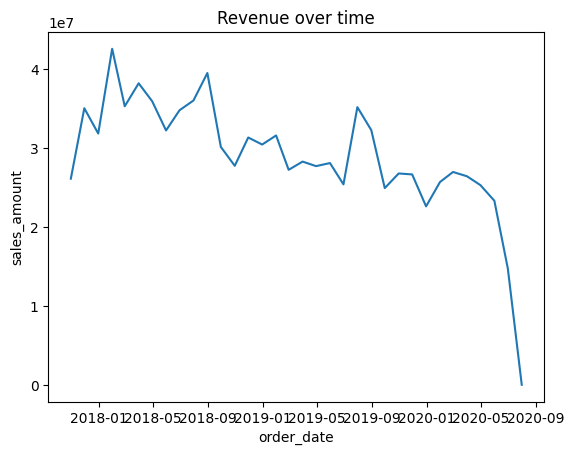

<ipython-input-269-7e2a9c828a83>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df.resample('M', on='order_date')['profit_margin'].sum().reset_index()


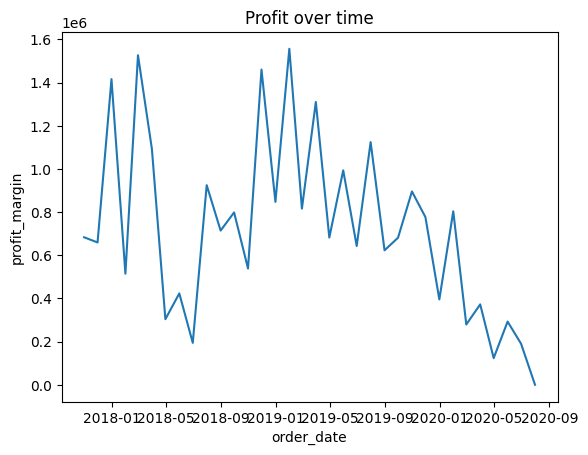

<ipython-input-24-143fbbc8238e>:29: FutureWarning: The provided callable <function sum at 0x7a8ba0bece00> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  revenue_by_month = df.groupby('order_month')[metric_col].agg(agg_func)


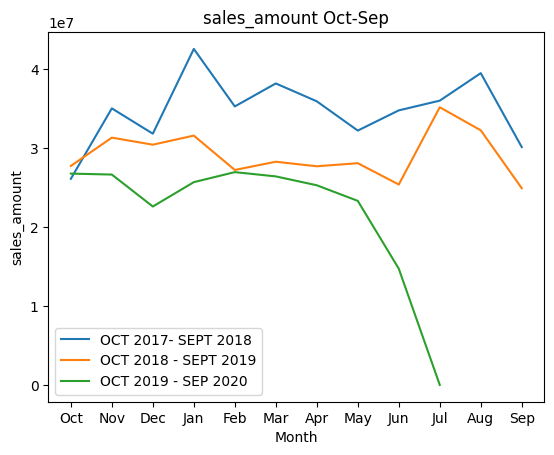

[  order_month  sales_amount month
 0  2019-10-01      26744955   Oct
 1  2019-11-01      26623725   Nov
 2  2019-12-01      22581846   Dec
 3  2020-01-01      25664596   Jan
 4  2020-02-01      26931944   Feb
 5  2020-03-01      26391041   Mar
 6  2020-04-01      25267920   Apr
 7  2020-05-01      23294778   May
 8  2020-06-01      14717345   Jun
 9  2020-07-01          8472   Jul,
    order_month  sales_amount month
 0   2018-10-01      27713450   Oct
 1   2018-11-01      31296202   Nov
 2   2018-12-01      30404126   Dec
 3   2019-01-01      31553402   Jan
 4   2019-02-01      27206009   Feb
 5   2019-03-01      28246165   Mar
 6   2019-04-01      27673431   Apr
 7   2019-05-01      28061536   May
 8   2019-06-01      25363748   Jun
 9   2019-07-01      35137734   Jul
 10  2019-08-01      32223583   Aug
 11  2019-09-01      24895945   Sep,
    order_month  sales_amount month
 0   2017-10-01      26087017   Oct
 1   2017-11-01      34998210   Nov
 2   2017-12-01      31796676   Dec
 

In [ ]:
#Our Revenue over time has been decreasing
df_resampled = df.resample('M', on='order_date')['sales_amount'].sum().reset_index()

sns.lineplot(data=df_resampled, x='order_date', y='sales_amount')
plt.title('Revenue over time')
plt.show()
#So our profit
df_resampled = df.resample('M', on='order_date')['profit_margin'].sum().reset_index()

sns.lineplot(data=df_resampled, x='order_date', y='profit_margin')
plt.title('Profit over time')
plt.show()
#We have less revenue over the years
metric_last_years(df=df,metric_col='sales_amount',date_col='order_date')

In [ ]:
df.groupby('year')['customer_code'].nunique()

year
2017    10
2018    19
2019    33
2020    38
Name: customer_code, dtype: int64

## Comparison: Revenue, qty, count, profit, cost, profit per unit revenue
Here I want to discuss our performance and state that our clients or markets with higest revenue or cost price are not the ones with highest profit and all of them are not the ones with higest profit per unit revenue
Then I'll analyse in the following section our outliers of revenue and do segmentation for revenue (high vs low) and do segmentation for the ones with gigh profit per unit revenue vs most revenue.
Then I'll recommend to focuss on the ones with profit per unit revenue and in addition follow the desc tree strategy if aproved

## General stats Be carefull the median lies

In [ ]:
#Average sales per day
df['order_date'].value_counts().median()

204.0

In [ ]:
len(df)

153713

In [ ]:
df['year'] = df['order_date'].dt.year
#Sales over the years
df.groupby('year').size()

year
2017    14555
2018    60755
2019    55705
2020    23412
dtype: int64

In [ ]:
#Total sales
len(df)

154427

In [ ]:
#profit margin
print('Total profit_margin')
print(round(df['profit_margin'].sum(),0))
print('Median profit_margin')
print(round(df['profit_margin'].median(),0))
df.resample('YE', on='order_date')['profit_margin'].sum().reset_index()

Total profit_margin
24654387.0
Median profit_margin
5.0


order_date  profit_margin
0 2017-12-31     2758255.53
1 2018-12-31     9337296.15
2 2019-12-31    10495721.85
3 2020-12-31     2063113.43

In [ ]:
print('Total revenue')
print(df['sales_amount'].sum())
print('Average revenue')
print(df['sales_amount'].median())
df.resample('YE', on='order_date')['sales_amount'].sum().reset_index()
#Now do revenue over customers, market...

Total revenue
985185128
Average revenue
468.0


order_date  sales_amount
0 2017-12-31      92881903
1 2018-12-31     413687163
2 2019-12-31     336312079
3 2020-12-31     142303983

In [ ]:
#Cost price
print('Total cost price')
print(df['cost_price'].sum())
print('Average revenue')
print(df['cost_price'].median())
df.resample('YE', on='order_date')['cost_price'].sum().reset_index().round()

Total cost price
960530741.0400001
Average revenue
458.7


order_date   cost_price
0 2017-12-31   90123647.0
1 2018-12-31  404349867.0
2 2019-12-31  325816357.0
3 2020-12-31  140240870.0

In [ ]:
#qty
print('Total qty sold')
print(df['sales_qty'].sum())
print('Average qty per transaction')
print(df['sales_qty'].median())
df.resample('YE', on='order_date')['sales_qty'].sum().reset_index().round()

Total qty sold
2435221
Average qty per transaction
1.0


order_date  sales_qty
0 2017-12-31     234367
1 2018-12-31     997497
2 2019-12-31     851076
3 2020-12-31     352281

### Since our revenue... cost price been decreasing

<ipython-input-24-143fbbc8238e>:29: FutureWarning: The provided callable <function sum at 0x7a8ba0bece00> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  revenue_by_month = df.groupby('order_month')[metric_col].agg(agg_func)


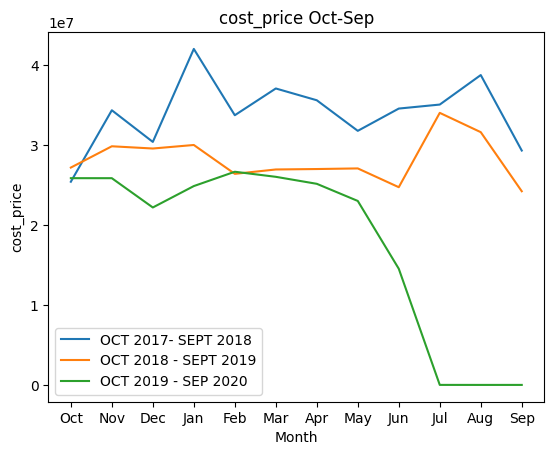

[   order_month   cost_price month
 0   2019-10-01  25849526.14   Oct
 1   2019-11-01  25847042.67   Nov
 2   2019-12-01  22186365.73   Dec
 3   2020-01-01  24861129.17   Jan
 4   2020-02-01  26652658.06   Feb
 5   2020-03-01  26018554.64   Mar
 6   2020-04-01  25144219.65   Apr
 7   2020-05-01  23001968.53   May
 8   2020-06-01  14527203.08   Jun
 9   2020-07-01      8294.31   Jul
 10  2020-08-01      5114.57   Aug
 11  2020-09-01      6270.72   Sep,
    order_month   cost_price month
 0   2018-10-01  27174852.49   Oct
 1   2018-11-01  29836177.20   Nov
 2   2018-12-01  29557019.87   Dec
 3   2019-01-01  29997242.42   Jan
 4   2019-02-01  26389970.06   Feb
 5   2019-03-01  26936418.75   Mar
 6   2019-04-01  26991484.18   Apr
 7   2019-05-01  27068348.83   May
 8   2019-06-01  24720924.02   Jun
 9   2019-07-01  34013681.69   Jul
 10  2019-08-01  31600590.10   Aug
 11  2019-09-01  24214762.56   Sep,
    order_month   cost_price month
 0   2017-10-01  25403752.98   Oct
 1   2017-11-01  3

In [ ]:
metric_last_years(df=df,metric_col='cost_price',date_col='order_date')

## By cat

In [ ]:
df['markets_name'].nunique()

14

In [ ]:
temp = df.groupby('product_code')[['sales_amount','sales_qty']].sum()
temp.sort_values(by='sales_qty')

sales_amount  sales_qty
product_code                         
Prod111                 65          1
Prod115                106          1
Prod082                532          1
Prod222                394          1
Prod230                264          1
...                    ...        ...
Prod245            9274471      72935
Prod318           68967202      74195
Prod237            7309867     114171
Prod239           11090225     170463
Prod090           13418863     277960

[338 rows x 2 columns]

### Be carefull, those are not representative

In [ ]:
#Freq product
print('We have 338 products')
print(len(df['product_code'].unique()))
freq_prod = df['product_code'].value_counts(ascending=False, normalize=True) * 100
freq_prod.head()

We have 338 products
338


product_code
Prod065    2.559138
Prod334    2.518990
Prod053    2.467833
Prod295    2.351920
Prod294    2.206220
Name: proportion, dtype: float64

In [ ]:
product_stats = main_stats_by_cat(df=df, cat_col='product_code')
product_stats

product_code_sales_amount  sales_amount product_code_profit_margin  \
0                   Prod318      68967202                    Prod329   
1                   Prod316      60883452                    Prod318   
2                   Prod324      41455364                    Prod316   
3                   Prod329      34381481                    Prod040   
4                   Prod334      31468996                    Prod324   

   profit_margin product_code_profit_revenue_ratio  profit_revenue_ratio  \
0     1947587.05                           Prod001                  0.39   
1     1866343.37                           Prod037                  0.38   
2     1171377.79                           Prod111                  0.37   
3     1025736.71                           Prod153                  0.37   
4     1009946.10                           Prod151                  0.34   

  product_code_profit_contribution  profit_contribution  \
0                          Prod329             0.078996   
1                          Prod318             0.075700   
2                          Prod316             0.047512   
3                          Prod040             0.041605   
4                          Prod324             0.040964   

  product_code_revenue_contribution  revenue_contribution  
0                           Prod318              0.070004  
1                           Prod316              0.061799  
2                           Prod324              0.042079  
3                           Prod329              0.034898  
4                           Prod334              0.031942

### Check it representative before Power BI

In [ ]:
#Freq customer
print('We have 38 customers')
print(len(df['customer_name'].unique()))
freq_prod = df['customer_name'].value_counts(ascending=False, normalize=True) * 100
freq_prod.head()

We have 38 customers
38


customer_name
Premium Stores           12.464142
Electricalsara Stores    10.329800
Excel Stores              7.040867
Nixon                     6.906823
Surge Stores              5.501629
Name: proportion, dtype: float64

In [ ]:
customer_name_stats = main_stats_by_cat(df=df, cat_col='customer_name')
customer_name_stats

customer_name_sales_amount  sales_amount customer_name_profit_margin  \
0      Electricalsara Stores     439635137       Electricalsara Stores   
1         Electricalslytical      76675031                       Nixon   
2               Excel Stores      75799367          Electricalslytical   
3             Premium Stores      72147578              Premium Stores   
4                      Nixon      70581066                Excel Stores   

   profit_margin customer_name_profit_revenue_ratio  profit_revenue_ratio  \
0    10155152.81              Electricalsbea Stores              0.054479   
1     2708222.83            Electricalsquipo Stores              0.052549   
2     2211416.34                               Sage              0.044404   
3     1765996.79                         Expression              0.042384   
4     1553576.24                              Power              0.039427   

  customer_name_profit_contribution  profit_contribution  \
0             Electricalsara Stores             0.411900   
1                             Nixon             0.109848   
2                Electricalslytical             0.089697   
3                    Premium Stores             0.071630   
4                      Excel Stores             0.063014   

  customer_name_revenue_contribution  revenue_contribution  
0              Electricalsara Stores              0.446246  
1                 Electricalslytical              0.077828  
2                       Excel Stores              0.076939  
3                     Premium Stores              0.073233  
4                              Nixon              0.071642

In [ ]:
#Freq type of business
print('We have 38 customers')
print(len(df['customer_type'].unique()))
freq_prod = df['customer_type'].value_counts(ascending=False, normalize=True) * 100
freq_prod.head()

We have 38 customers
2


customer_type
Brick & Mortar    67.320482
E-Commerce        32.679518
Name: proportion, dtype: float64

In [ ]:
customer_type_stats = main_stats_by_cat(df=df, cat_col='customer_type')
customer_type_stats

customer_type_sales_amount  sales_amount customer_type_profit_margin  \
0             Brick & Mortar     797159933              Brick & Mortar   
1                 E-Commerce     188025195                  E-Commerce   

   profit_margin customer_type_profit_revenue_ratio  profit_revenue_ratio  \
0    18216904.96                         E-Commerce              0.034237   
1     6437482.00                     Brick & Mortar              0.022852   

  customer_type_profit_contribution  profit_contribution  \
0                    Brick & Mortar             0.738891   
1                        E-Commerce             0.261109   

  customer_type_revenue_contribution  revenue_contribution  
0                     Brick & Mortar              0.809147  
1                         E-Commerce              0.190853

In [ ]:
print('DO NOT INCLUDE THIS DATA NAN VALUES')
print(len(df['product_type'].unique()))
freq_prod = df['product_type'].value_counts(ascending=False, normalize=True) * 100
freq_prod.head()

DO NOT INCLUDE THIS DATA NAN VALUES
3


product_type
Own Brand       39.616777
Other           38.039980
Distribution    22.343243
Name: proportion, dtype: float64

In [ ]:
print('We have 14 markets (+ Zones)')
print(len(df['markets_name'].unique()))
freq_prod = df['markets_name'].value_counts(ascending=False, normalize=True) * 100
freq_prod.head()

We have 14 markets (+ Zones)
14


markets_name
Nagpur       34.419499
Delhi NCR    28.970970
Ahmedabad    12.979596
Bhopal        8.629320
Mumbai        7.336152
Name: proportion, dtype: float64

In [ ]:
markets_stats = main_stats_by_cat(df=df, cat_col='markets_name')
markets_stats

markets_name_sales_amount  sales_amount markets_name_profit_margin  \
0                 Delhi NCR     519534744                  Delhi NCR   
1                    Mumbai     150085133                     Mumbai   
2                 Ahmedabad     132307766                  Ahmedabad   
3                    Bhopal      58610045                     Bhopal   
4                    Nagpur      55376330                     Nagpur   

   profit_margin markets_name_profit_revenue_ratio  profit_revenue_ratio  \
0    11939783.71                             Surat              0.048614   
1     4872685.27                             Patna              0.041157   
2     2848293.37                      Bhubaneshwar              0.039823   
3     2287172.23                            Bhopal              0.039024   
4     1423320.74                             Kochi              0.037383   

  markets_name_profit_contribution  profit_contribution  \
0                        Delhi NCR             0.484286   
1                           Mumbai             0.197640   
2                        Ahmedabad             0.115529   
3                           Bhopal             0.092769   
4                           Nagpur             0.057731   

  markets_name_revenue_contribution  revenue_contribution  
0                         Delhi NCR              0.527347  
1                            Mumbai              0.152342  
2                         Ahmedabad              0.134297  
3                            Bhopal              0.059491  
4                            Nagpur              0.056209

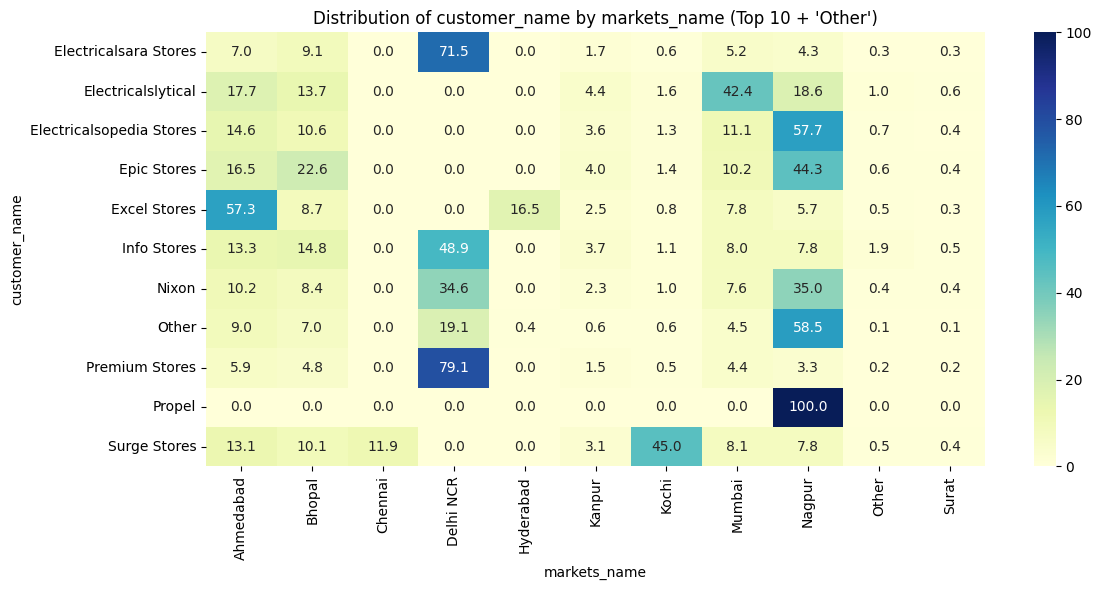

In [ ]:
#Change this to a map
plot_distribution_heatmap(df=df,row_col='customer_name',col_col='markets_name')

### Repeat this for each (qty, profit, revenue, profit per unit revenue)

In [ ]:
#Where are our top customers by qty, profit, revenue, profit per unit revenue
customer_revenue = customer_name_stats['customer_name_sales_amount'].values
df[df['customer_name'].isin(customer_revenue)].groupby('markets_name').size().sort_values(ascending=False)

markets_name
Delhi NCR    30336
Ahmedabad    10675
Nagpur        6832
Mumbai        5988
Bhopal        5076
Hyderabad     1794
Kanpur        1365
Kochi          489
Surat          198
Patna          192
Lucknow         47
Bengaluru       10
dtype: int64

## What make us have big revenue

### It is not qty or number of transactions (insert the table for number of transactions done before)

<ipython-input-24-143fbbc8238e>:29: FutureWarning: The provided callable <function sum at 0x7a8ba0bece00> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  revenue_by_month = df.groupby('order_month')[metric_col].agg(agg_func)


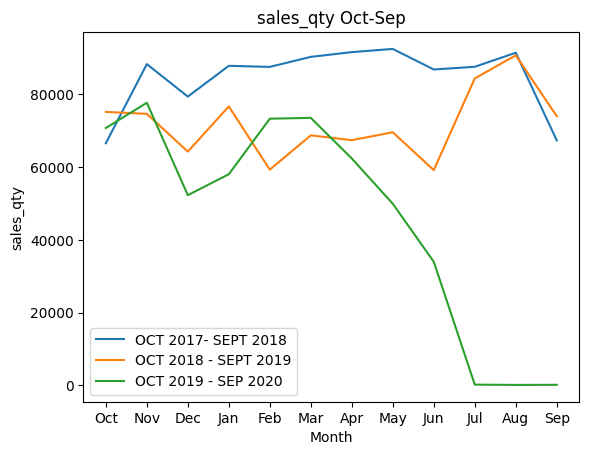

[   order_month  sales_qty month
 0   2019-10-01      70781   Oct
 1   2019-11-01      77718   Nov
 2   2019-12-01      52315   Dec
 3   2020-01-01      58073   Jan
 4   2020-02-01      73340   Feb
 5   2020-03-01      73569   Mar
 6   2020-04-01      62409   Apr
 7   2020-05-01      49954   May
 8   2020-06-01      34004   Jun
 9   2020-07-01        218   Jul
 10  2020-08-01        141   Aug
 11  2020-09-01        166   Sep,
    order_month  sales_qty month
 0   2018-10-01      75207   Oct
 1   2018-11-01      74680   Nov
 2   2018-12-01      64299   Dec
 3   2019-01-01      76718   Jan
 4   2019-02-01      59331   Feb
 5   2019-03-01      68762   Mar
 6   2019-04-01      67435   Apr
 7   2019-05-01      69605   May
 8   2019-06-01      59202   Jun
 9   2019-07-01      84406   Jul
 10  2019-08-01      90767   Aug
 11  2019-09-01      74036   Sep,
    order_month  sales_qty month
 0   2017-10-01      66595   Oct
 1   2017-11-01      88353   Nov
 2   2017-12-01      79419   Dec
 3   201

In [ ]:
metric_last_years(df=df,metric_col='sales_qty',date_col='order_date')

## Searching how we could back to big revenue... but that wouldn't solve our problem

### This is why that wouldn't solve the problem,
so instead of comparing high vs low sales amount, I'll compare pos vs neg profit... but as a second solution we could do a regression to the past of high sales amount and we could bet on clients with big profit per unit amount

#### #FOR TECHNICAL TEAM: IM USING SALES AMOUNT VS COST SINCE THEIR correlation is strong

In [ ]:
df['sales_amount'].corr(df['cost_price'])

np.float64(0.973912619607631)

[]

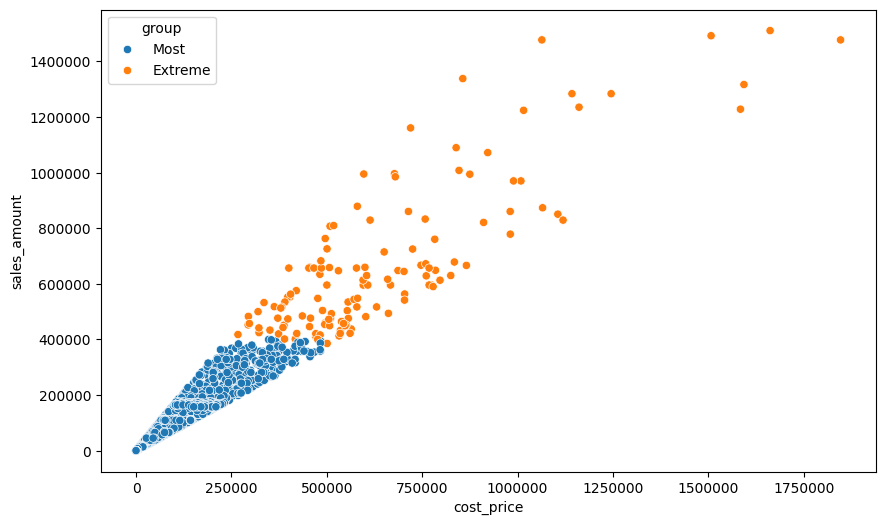

In [ ]:
plt.figure(figsize=(10,6))
plt.ticklabel_format(style='plain', axis='both', useOffset=False)
sns.scatterplot(data=df, x='cost_price',y='sales_amount',hue='group')
plt.plot()

#We can zoom in

In [ ]:
cond = df['sales_amount']<50000
df['group'] = np.where(cond, 'Most', 'Extreme')
df['group'].value_counts(normalize=True) * 100

group
Most       97.569726
Extreme     2.430274
Name: proportion, dtype: float64

In [ ]:
most_data = df[df['group'] == 'Most'].copy()
most_data.head()

product_code market_code order_date  sales_qty  sales_amount currency  \
0      Prod279     Mark011 2017-10-11          1           102      INR   
1      Prod279     Mark011 2017-10-18          1           102      INR   
2      Prod279     Mark011 2017-10-19          1           102      INR   
3      Prod279     Mark011 2017-11-08          1           102      INR   
4      Prod279     Mark011 2018-03-09          1           102      INR   

   profit_margin_percentage  profit_margin  cost_price customer_code  ...  \
0                      0.39          39.78       62.22        Cus020  ...   
1                     -0.12         -12.24      114.24        Cus020  ...   
2                      0.29          29.58       72.42        Cus020  ...   
3                      0.36          36.72       65.28        Cus020  ...   
4                     -0.35         -35.70      137.70        Cus033  ...   

   transaction_count  is_weekend  customer_name customer_type  product_type  \
0                  1       False          Nixon    E-Commerce  Distribution   
1                  1       False          Nixon    E-Commerce  Distribution   
2                  1       False          Nixon    E-Commerce  Distribution   
3                  1       False          Nixon    E-Commerce  Distribution   
4                  1       False        All-Out    E-Commerce  Distribution   

  markets_code markets_name     zone group neg_pos_profit  
0      Mark011       Nagpur  Central  Most            Pos  
1      Mark011       Nagpur  Central  Most            Neg  
2      Mark011       Nagpur  Central  Most            Pos  
3      Mark011       Nagpur  Central  Most            Pos  
4      Mark011       Nagpur  Central  Most            Neg  

[5 rows x 21 columns]

In [ ]:
extreme = df[df['group'] == 'Most'].copy()
extreme.head()

product_code market_code order_date  sales_qty  sales_amount currency  \
0      Prod279     Mark011 2017-10-11          1           102      INR   
1      Prod279     Mark011 2017-10-18          1           102      INR   
2      Prod279     Mark011 2017-10-19          1           102      INR   
3      Prod279     Mark011 2017-11-08          1           102      INR   
4      Prod279     Mark011 2018-03-09          1           102      INR   

   profit_margin_percentage  profit_margin  cost_price customer_code  ...  \
0                      0.39          39.78       62.22        Cus020  ...   
1                     -0.12         -12.24      114.24        Cus020  ...   
2                      0.29          29.58       72.42        Cus020  ...   
3                      0.36          36.72       65.28        Cus020  ...   
4                     -0.35         -35.70      137.70        Cus033  ...   

   transaction_count  is_weekend  customer_name customer_type  product_type  \
0                  1       False          Nixon    E-Commerce  Distribution   
1                  1       False          Nixon    E-Commerce  Distribution   
2                  1       False          Nixon    E-Commerce  Distribution   
3                  1       False          Nixon    E-Commerce  Distribution   
4                  1       False        All-Out    E-Commerce  Distribution   

  markets_code markets_name     zone group neg_pos_profit  
0      Mark011       Nagpur  Central  Most            Pos  
1      Mark011       Nagpur  Central  Most            Neg  
2      Mark011       Nagpur  Central  Most            Pos  
3      Mark011       Nagpur  Central  Most            Pos  
4      Mark011       Nagpur  Central  Most            Neg  

[5 rows x 21 columns]

In [ ]:
cust_most = main_stats_by_cat(df=most_data, cat_col='customer_name')
cust_most

customer_name_sales_amount  sales_amount customer_name_profit_margin  \
0      Electricalsara Stores     121436363       Electricalsara Stores   
1             Premium Stores      55198889              Premium Stores   
2         Electricalslytical      52683610                       Nixon   
3               Excel Stores      46053278          Electricalslytical   
4                      Nixon      40324256                Excel Stores   

   profit_margin customer_name_profit_revenue_ratio  profit_revenue_ratio  \
0     2769842.85              Electricalsbea Stores              0.054479   
1     1261564.63            Electricalsquipo Stores              0.052549   
2     1204154.70                               Sage              0.044404   
3     1103871.04                         Expression              0.042384   
4     1052309.71                              Novus              0.038451   

  customer_name_profit_contribution  profit_contribution  \
0             Electricalsara Stores             0.240819   
1                    Premium Stores             0.109685   
2                             Nixon             0.104693   
3                Electricalslytical             0.095974   
4                      Excel Stores             0.091491   

  customer_name_revenue_contribution  revenue_contribution  
0              Electricalsara Stores              0.248878  
1                     Premium Stores              0.113127  
2                 Electricalslytical              0.107972  
3                       Excel Stores              0.094384  
4                              Nixon              0.082643

In [ ]:
temp = cust_most['customer_name_sales_amount'].values
first = most_data[most_data['customer_name'].isin(temp)]

#### CHange to bar plot

In [ ]:
cust_extreme = main_stats_by_cat(df=extreme_data, cat_col='customer_name')
temp2 = cust_extreme['customer_name_sales_amount'].values
second = extreme_data[extreme_data['customer_name'].isin(temp2)]

<Axes: xlabel='customer_name', ylabel='sales_amount'>

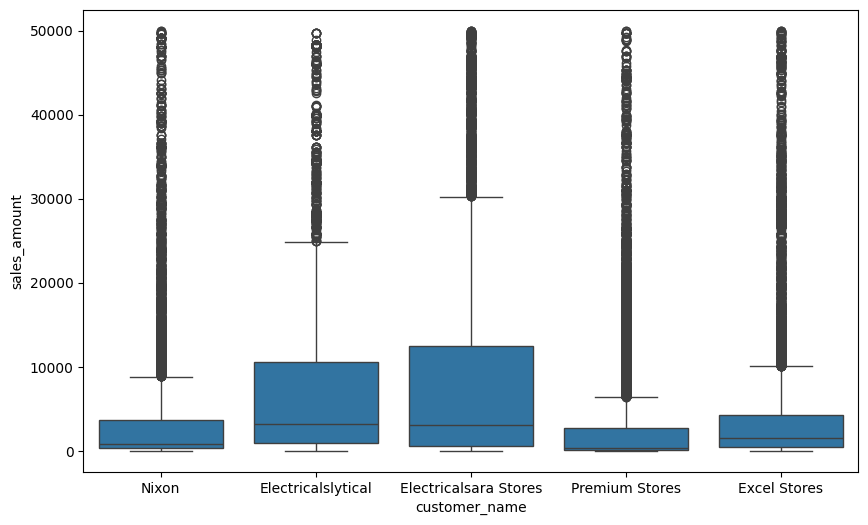

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=first, x='customer_name',y='sales_amount')

<Axes: xlabel='customer_name', ylabel='sales_amount'>

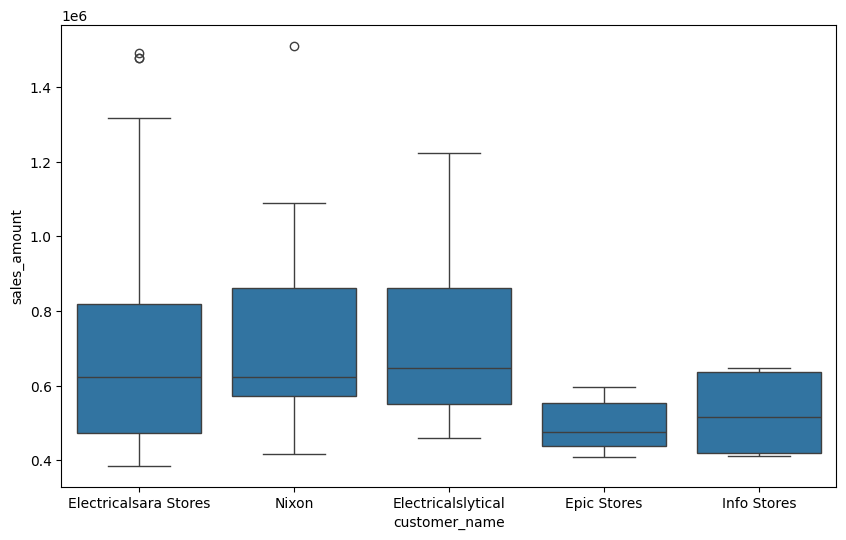

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=second, x='customer_name',y='sales_amount')

<Axes: xlabel='sales_amount', ylabel='profit_margin'>

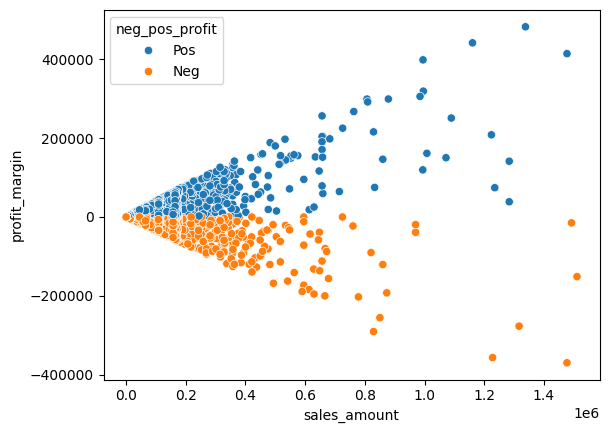

In [ ]:
sns.scatterplot(data=df, x='sales_amount',y='profit_margin',hue='neg_pos_profit')

#### Repeat what I did bust with this new segmentation

## Idea: Check box plots with big profit, comparing it with years before (ask for dashboards from past years)

# CSV FILE FOR POWER BI

In [ ]:
df.to_csv('merged_clean_transactions.csv',index=False)

In [ ]:
# KPI how many were pos
#Median of transactions per day
df['order_date'].value_counts().median()

190.0

##### Ignore the folowing lines

In [ ]:
df['month'] = df['order_date'].dt.month

<Axes: xlabel='order_date', ylabel='sales_amount'>

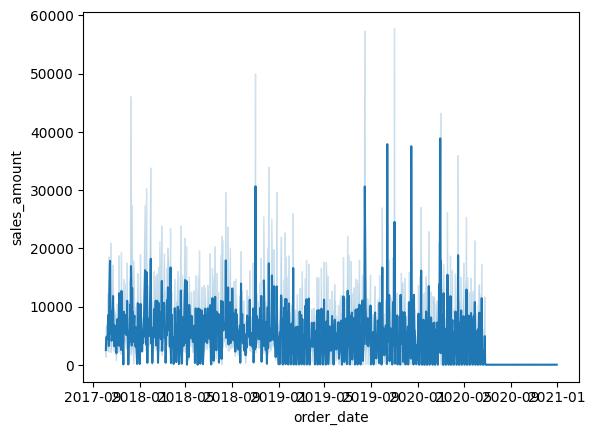

In [ ]:
sns.lineplot(data=df, x='order_date',y='sales_amount')

In [ ]:
a = len(df[df['year'] == 2017]['customer_code'].unique())
b = len(df[df['year'] == 2018]['customer_code'].unique())
c = len(df[df['year'] == 2019]['customer_code'].unique())
d = len(df[df['year'] == 2020]['customer_code'].unique())
a,b,c,d

(10, 19, 33, 38)

In [ ]:
x = df[df['year'] == 2017]['customer_code'].unique()


In [ ]:
df.groupby(['year','month'])['sales_amount'].sum()

year  month
2017  10       26087017
      11       34998210
      12       31796676
2018  1        42520492
      2        35243966
      3        38153155
      4        35891903
      5        32188350
      6        34744297
      7        35975169
      8        39454467
      9        30101586
      10       27713450
      11       31296202
      12       30404126
2019  1        31553402
      2        27206009
      3        28246165
      4        27673431
      5        28061536
      6        25363748
      7        35137734
      8        32223583
      9        24895945
      10       26744955
      11       26623725
      12       22581846
2020  1        25664596
      2        26931944
      3        26391041
      4        25267920
      5        23294778
      6        14717345
      7            8472
      8            5375
      9            6474
      10           5666
      11           5386
      12           4986
Name: sales_amount, dtype: int64

In [ ]:
df[['sales_amount','product_code']].groupby('product_code')['sales_amount'].sum().sort_values(ascending=False).head()

product_code
Prod318    68967202
Prod316    60883452
Prod324    41455364
Prod329    34381481
Prod334    31468996
Name: sales_amount, dtype: int64

In [ ]:
df.columns

Index(['product_code', 'market_code', 'order_date', 'sales_qty',
       'sales_amount', 'currency', 'profit_margin_percentage', 'profit_margin',
       'cost_price', 'customer_code', 'year', 'transaction_count',
       'is_weekend', 'customer_name', 'customer_type', 'product_type',
       'markets_code', 'markets_name', 'zone', 'group', 'neg_pos_profit',
       'month'],
      dtype='object')

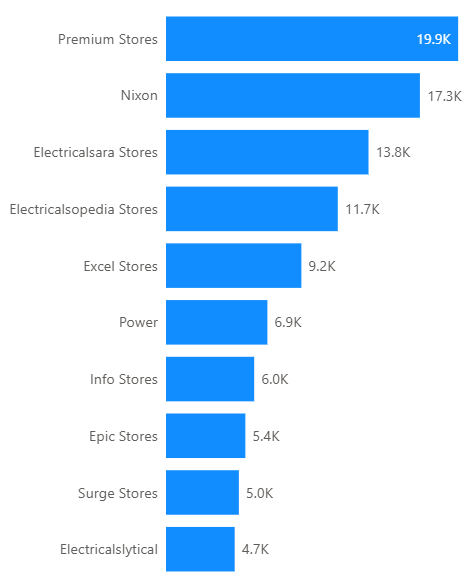